In [1]:
%matplotlib inline
import operator
import talib
import numpy as np
import pandas as pd
import time
from datetime import datetime, date, timedelta

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import seaborn
import matplotlib.pyplot as plt

import tqdm  # progressbar

from db import (db, get_prices_db, get_performance, get_log_performance, 
                prepare_pair, get_prices_remote, months_generator)

pd.set_option('display.max_rows', 500) # default 30
pd.set_option('display.max_columns', 80) # default 20
pd.set_option('max_colwidth', 100) # default 40

def zscore_std(series, name="z-score"):
    return ((series - series.mean()) / np.std(series)).rename(name)

def zscore_std_np(a):
    b = (a - a.mean()) / np.std(a)
    b[np.isnan(b)] = 0
    return b

/home/alex/env/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# get listed symbols with price above $10; average volume more than 300K; atr(13) > 0.3
sql = "SELECT symbol FROM listed " \
      "WHERE is_listed AND price > 10 AND avg_volume > 300000 AND atr > 0.3 " \
      "ORDER BY symbol LIMIT 10000"
r = db.query(sql)
listed_symbols = [s[0] for s in r]
symbol_list = listed_symbols[:]  # FIXME: for quick run only 50 assets

analyze_date = datetime(2016, 1, 1)  # last date
analyze_length = 370

all_prices = get_prices_db(symbol_list, analyze_date, analyze_length, is_adj=True)  # 360

# indices of db fields:
# symbol, dt, open, high, low, close, volume

# better pairs, if we use not adjusted prices (is_adj=False)
symbol_prices = {s: all_prices['close'][all_prices['symbol'] == s] for s in symbol_list} 
len(listed_symbols), len(symbol_prices)

(1864, 1864)

# Выбор относительных значений

Есть два варианта:
* Процентная доходность (get_performance()).
* Логарифмическая доходность (get_log_performance()).

Логарифмическая доходность больше похожа на график цены. 
Подробнее [здесь](http://smart-lab.ru/finansoviy-slovar/%D0%BB%D0%BE%D0%B3%D0%B0%D1%80%D0%B8%D1%84%D0%BC%20%D1%86%D0%B5%D0%BD%D1%8B).

Результат торговли парой также поменяются, в зависимости от выбранной доходности.

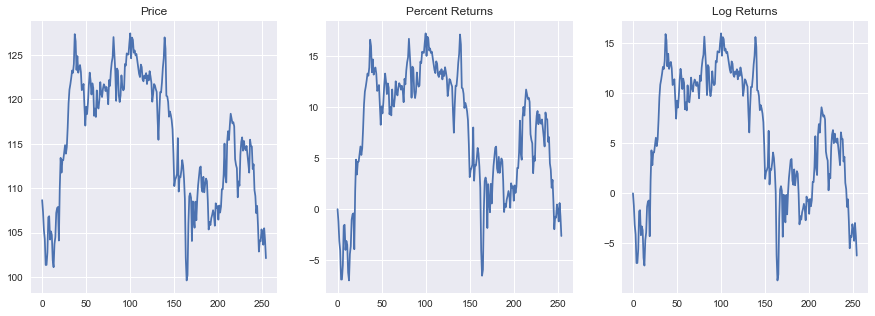

In [3]:
prices = symbol_prices['AAPL']
returns = get_performance(prices)
log_returns = get_log_performance(prices)

# one, two, three
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# change background
fig.set_facecolor('white')

axs[0].plot(prices)
axs[0].set_title('Price')
axs[1].plot(returns)
axs[1].set_title('Percent Returns')
axs[2].plot(log_returns)
axs[2].set_title('Log Returns')

plt.show()

# which performance use
func_performance = get_log_performance

# Подготовка цен

* Проверяем длину истории и берем минимум 95% активов.
* Все истории приводим к одной длине и отбрасываем короткие.
* Все истории цен приводим к относительным величинам.
* Удаляем все стационарные истории.

In [4]:
# get all lengths
all_lengths = [len(p) for s, p in symbol_prices.items()]
# get thresghold length for minimum 5% items
length_limit = int(np.percentile(all_lengths, 10))
# get cutted price histories
symbol_prices = {s: p[-length_limit:] for s, p in symbol_prices.items() if len(p) >= length_limit} 
# get performance for cutted price histories
symbol_performance = {s: func_performance(p[-length_limit:]) 
                      for s, p in symbol_prices.items() if len(p) >= length_limit} 

# check cointegration and remove found symbols
to_delete = []
for s, p in tqdm.tqdm(symbol_performance.items()):
    result = adfuller(p)
    score = result[0]
    pvalue = result[1]
    crit = result[4]
    #score, pvalue, score < crit['5%']
    if score < crit['5%']:
        # cointegrated
        to_delete.append(s)
        pass
if to_delete:
    for s in to_delete:
        del symbol_performance[s]

'Total stocks {0} with minimum length {1}. Removed {2} cointegrated histories.'.format(len(symbol_performance), length_limit, len(to_delete))

100%|██████████| 1770/1770 [00:20<00:00, 84.59it/s]


'Total stocks 1658 with minimum length 255. Removed 112 cointegrated histories.'

## Поиск пар с помощью средних

In [5]:
def get_diff(y):
    """
    Метод наименьших квадратов
    для поиска разницы между парами.
    """
    x = np.array([i for i in range(len(y))])
    arr = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(arr, y)[0]
    #print(m, c)
    return c
    
def check_coint_parts(X):
    """
    Проверяем стационарность на коротких отрезках.
    """
    parts = 4 if len(X) > 300 else 2
    step_size = len(X) // parts
    res = dict()
    for step in range(parts):
        begin = step * step_size
        end = step * step_size + step_size
        result = adfuller(X[begin:end])
        score, pvalue, crit = result[0], result[1], result[4]
        res[step] = {
            'begin': begin, 
            'end': end, 
            'coint': score < crit['5%'], 
            'pvalue': pvalue
        }
    return res
    
def find_pairs_ema_upgraded(symbol_prices, need_preparation=False):
    n = len(symbol_prices)
    symbols = sorted(list(symbol_prices.keys()))
    pairs = []
    
    for i in tqdm.tqdm(range(n)):
        for j in range(i+1, n):
            S1 = symbol_prices[symbols[i]]
            S2 = symbol_prices[symbols[j]]
            
            # подготавливаем ряды, если необходимо
            if need_preparation:
                S1, S2 = prepare_vectors(S1, S2, to_performance=True)
            
            # получаем скользящие средние
            period = 50
            ema1 = talib.EMA(S1, timeperiod=period)
            ema2 = talib.EMA(S2, timeperiod=period)

            spread = (ema1[period-1:] - ema2[period-1:])
            # среднее значение спреда MA
            spread_mean = abs(spread).mean()
            # медиана спреда MA
            spread_median = np.median(abs(spread))
            # максимальное значение 70% значений по модулю спреда MA
            spread_percentile = np.percentile(abs(spread), 70)  
            
            # добавляем пары со средним значением спреда EMA50 < 3
            # ИЛИ медианой спреда EMA50 < 3
            # ИЛИ процентилем 70% от спреда EMA50 < 4
            if spread_percentile < 4:
                # проверяем стационарность сигнальной линии zscore_std_np(S1-S2)
                result = adfuller(S1-S2)
                score, pvalue, crit = result[0], result[1], result[4]
                
                # параметры спреда
                spread_params = {
                    'median': spread_median, 
                    'mean': spread_mean, 
                    'percentile': spread_percentile, 
                    'pvalue': pvalue, 
                    'coint': score < crit['5%']    
                }                
                
                # проверяем стационарность коротких промежутков
                short_parts = check_coint_parts(S1-S2)
                
                pairs.append((symbols[i], symbols[j], 
                              spread_params, 
                              short_parts))
                
    return pairs

# Pairs search
## Поиск пар

**Внимание:** Искать только по относительным величинам, так как для цен порог разницы между средними всегда будет меняться.

In [16]:
pairs = find_pairs_ema_upgraded(symbol_performance)
"Found pairs {0}".format(len(pairs))

 89%|████████▉ | 1473/1658 [15:19<00:29,  6.32it/s]/home/alex/env/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:660: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/alex/env/lib/python3.5/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
100%|██████████| 1658/1658 [15:33<00:00,  1.78it/s]


'Found pairs 24848'

# Analyze found pairs
## Анализ найденных пар

Сбор наблюдений для найденных пар и фильтр.

In [17]:
def check_future_coint(s1, s2):
    """
    Disabled
    """
    analyze_date = datetime(2015, 7, 1)
    analyze_length = 370    
    symbol_list = [s1, s2]
    all_prices = get_prices_db(list(symbol_list), analyze_date, analyze_length)
    symbol_test_prices = {s: np.array([x[5] for x in all_prices if x[0] == s]) for s in symbol_list}
    S1 = symbol_test_prices[s1][-255:]
    S2 = symbol_test_prices[s2][-255:]
    result = adfuller(S1-S2)
    score, pvalue, crit = result[0], result[1], result[4]
    return score < crit['5%']

results = []
for s1, s2, spread_params, short_parts in tqdm.tqdm(pairs[:]):
    res = {
        'Symbol1': s1,
        'Symbol2': s2,
        'Median': spread_params['median'],
        'Mean': spread_params['mean'],
        'Percentile': spread_params['percentile'],
        'pvalue': spread_params['pvalue'],
        'coint': spread_params['coint'],
        'part_size': short_parts[0]['end'] - short_parts[0]['begin'],
        'part1': short_parts[0]['coint'],
        'part2': short_parts[1]['coint'],
        'part3': short_parts[2]['coint'] if 2 in short_parts else '',
        'part4': short_parts[3]['coint'] if 3 in short_parts else '',
        #'future': check_future_coint(s1, s2) if short_parts[0]['coint'] and short_parts[1]['coint'] else False,
    }
    P1, P2 = symbol_performance[s1], symbol_performance[s2]
    #P1, P2 = symbol_prices[s1], symbol_prices[s2]
    spread = P1 - P2
    
    res['std'] = np.std(spread)
    #res['std(-40)'] = np.std(spread[-40:])
    
    z = ((spread - spread.mean()) / np.std(spread))    
    res['x(0)'] = len(z[abs(np.insert(np.diff(np.sign(z)), 0, 0)) == 2])
    res['x(-1)'] = len(z[abs(np.insert(np.diff(np.sign(z+1)), 0, 0)) == 2]) 
    res['x(+1)'] = len(z[abs(np.insert(np.diff(np.sign(z-1)), 0, 0)) == 2])

    # get R-squared of OLS
    #Y = pd.Series(symbol_prices[s1])
    #X = pd.Series(symbol_prices[s2])
    Y = P1.copy()[:]
    X = P2.copy()[:]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    res['R^2'] = model.rsquared
    res['se'] = model.bse[1]

    results.append(res)
    
d = pd.DataFrame(results)

100%|██████████| 24848/24848 [00:20<00:00, 1221.03it/s]


In [18]:
assert len(d.index) > 0  # Pairs not found

# add field with pair
d['pair'] = "('" + d['Symbol1'] + "', '" + d['Symbol2'] + "')"

# фильтр низкой сигмы
fltr = d['std'] > 0.1
# только стационарные
fltr = (fltr) & (d['coint'] == True)
# фильтр стационарных коротких частей
#fltr = (fltr) & (d['part1'] == True) & (d['part2'] == True)
fltr = (fltr) & (d['part2'] == True)
#fltr = (fltr) & (d['part3'] == True) & (d['part4'] == True)

#fltr = (fltr) & (0.6 <= d['R^2']) & (d['R^2'] <= 0.93)

#fltr = (fltr) & (d['future'] == True)
#fltr = (fltr) & (d['Symbol2'] == 'XRT')

print("Total pairs: {0}".format(len(d[fltr])))
d[fltr].sort_values(['R^2'], ascending=False).head(5)

Total pairs: 1217


Mean    Median  Percentile       R^2 Symbol1 Symbol2  coint  part1  \
24605  0.340078  0.344006    0.380575  0.999278     VEU    VXUS   True   True   
18172  0.201340  0.193667    0.227823  0.999214    IXUS    VXUS   True   True   
12276  0.762583  0.756317    0.946717  0.996140    ERUS     RSX   True   True   
11346  0.836592  0.774803    1.213562  0.968697     EFA     EZU   True   True   
13167  1.505855  1.433257    1.666020  0.966538     EZU    IEFA   True   True   

       part2 part3 part4  part_size    pvalue        se       std  x(+1)  \
24605   True                    127  0.003002  0.001705  0.143906     37   
18172   True                    127  0.000010  0.001742  0.152925     29   
12276   True                    127  0.000004  0.003936  0.567312     33   
11346   True                    127  0.000027  0.011763  0.787733     26   
13167   True                    127  0.000008  0.011496  0.755806     39   

       x(-1)  x(0)              pair  
24605     25    51   ('VEU', 'VXUS')  
18172     48    76  ('IXUS', 'VXUS')  
12276     31    67   ('ERUS', 'RSX')  
11346     27    51    ('EFA', 'EZU')  
13167     27    33   ('EZU', 'IEFA')

## Best pairs

In [41]:
# columns
cols = ['pair', 'R^2', 'se', 'coint', 'part1', 'part2', 'pvalue', 'std', ]

fltr = (fltr) & (d['R^2'] <= 0.70)

d[cols][fltr].sort_values(['R^2'], ascending=False).head(30)

pair       R^2        se  coint  part1  part2    pvalue  \
22351    ('PPG', 'SPXL')  0.699965  0.030285   True  False   True  0.010043   
7787      ('CIT', 'SLB')  0.699844  0.022265   True  False   True  0.025010   
14874   ('GLYC', 'XPER')  0.699764  0.044730   True  False   True  0.000306   
23886     ('SSO', 'TXT')  0.699069  0.035238   True   True   True  0.004170   
21735     ('OUT', 'POL')  0.697531  0.039307   True  False   True  0.034466   
18699    ('KAMN', 'TXT')  0.697424  0.030359   True  False   True  0.003675   
14726    ('GILD', 'LEG')  0.697270  0.042464   True  False   True  0.004982   
18739     ('KAR', 'SCZ')  0.697145  0.035679   True  False   True  0.019294   
3149      ('APH', 'EFA')  0.696705  0.034731   True  False   True  0.006373   
14946  ('GNCMA', 'PFPT')  0.696483  0.038963   True  False   True  0.020176   
19255     ('KRG', 'XOM')  0.695593  0.033851   True  False   True  0.005052   
22601    ('RDN', 'RRGB')  0.695532  0.033601   True  False   True  0.001960   
11923     ('EOG', 'TEN')  0.695508  0.032584   True  False   True  0.019226   
12895     ('EWQ', 'MDY')  0.695151  0.042212   True  False   True  0.010550   
14950   ('GNCMA', 'TSO')  0.694618  0.034070   True  False   True  0.019665   
14871    ('GLYC', 'WEX')  0.694234  0.037362   True  False   True  0.002421   
1724      ('AHL', 'ECL')  0.694064  0.035648   True  False   True  0.004566   
10824    ('DRQ', 'LECO')  0.694017  0.038067   True  False   True  0.023556   
3995       ('AXS', 'XL')  0.693584  0.045191   True  False   True  0.001674   
8913      ('CSL', 'HDS')  0.693545  0.026688   True  False   True  0.010184   
20774    ('MNST', 'VLO')  0.692755  0.025914   True  False   True  0.010633   
6077     ('BUD', 'LAMR')  0.692150  0.044300   True  False   True  0.001248   
6938      ('CBG', 'VPL')  0.691757  0.044086   True  False   True  0.002769   
7155       ('CCK', 'RS')  0.690704  0.033743   True   True   True  0.000709   
18924     ('KEY', 'VGK')  0.690499  0.048918   True  False   True  0.004153   
10331     ('DIS', 'MPC')  0.690496  0.028878   True  False   True  0.000002   
24450     ('UAL', 'WPC')  0.690496  0.053732   True  False   True  0.005433   
4813       ('BG', 'SSL')  0.690344  0.033313   True  False   True  0.007918   
11813     ('EMN', 'MET')  0.689944  0.033928   True  False   True  0.003589   
22356    ('PPG', 'UPRO')  0.688765  0.031051   True  False   True  0.011601   

            std  
22351  4.767306  
7787   4.539120  
14874  5.608345  
23886  3.090191  
21735  5.364244  
18699  2.943969  
14726  3.399962  
18739  2.170669  
3149   2.505161  
14946  6.693224  
19255  3.450316  
22601  5.655972  
11923  5.249343  
12895  2.163493  
14950  7.050682  
14871  5.704946  
1724   2.556152  
10824  5.349794  
3995   2.632738  
8913   4.065606  
20774  6.210059  
6077   2.953297  
6938   3.341830  
7155   3.371866  
18924  3.304664  
10331  4.480282  
24450  5.131522  
4813   6.491808  
11813  3.217166  
22356  4.832180

## Worst pairs

In [20]:
d[cols][fltr].sort_values(['R^2'], ascending=False).tail(15)

pair       R^2        se  coint  part1  part2    pvalue  \
2976    ('AON', 'VRTX')  0.245823  0.035314   True  False   True  0.002459   
3367     ('ARW', 'LQD')  0.226976  0.182074   True  False   True  0.027358   
10075    ('DG', 'VRTX')  0.222588  0.053906   True  False   True  0.001376   
3396     ('ARW', 'TIP')  0.217557  0.232398   True  False   True  0.031081   
24006     ('SU', 'UAL')  0.210368  0.039533   True  False   True  0.024513   
20645   ('MKSI', 'MTB')  0.204719  0.065766   True  False   True  0.020961   
22144   ('PHM', 'SPXU')  0.186435  0.044274   True  False   True  0.000316   
5235    ('BLL', 'IDCC')  0.176435  0.041829   True  False   True  0.004500   
4769   ('BERY', 'LOGI')  0.160213  0.053159   True  False   True  0.040996   
21071   ('NATI', 'PEI')  0.158022  0.046000   True  False   True  0.001883   
5217     ('BLL', 'DOC')  0.136570  0.057557   True  False   True  0.014426   
24049   ('SYF', 'VRTX')  0.125312  0.041181   True  False   True  0.001826   
3107     ('APD', 'TLT')  0.115726  0.079054   True  False   True  0.037727   
21893    ('PCG', 'TOT')  0.113769  0.047723   True  False   True  0.014345   
21889    ('PCG', 'SMH')  0.019707  0.048517   True  False   True  0.046755   

            std  
2976   5.727293  
3367   4.526430  
10075  6.588108  
3396   4.613371  
24006  8.098601  
20645  4.238882  
22144  8.144454  
5235   5.854165  
4769   6.746756  
21071  5.652512  
5217   5.058079  
24049  6.480150  
3107   4.907400  
21893  5.129337  
21889  5.945313

## Анализ пар на графиках

''

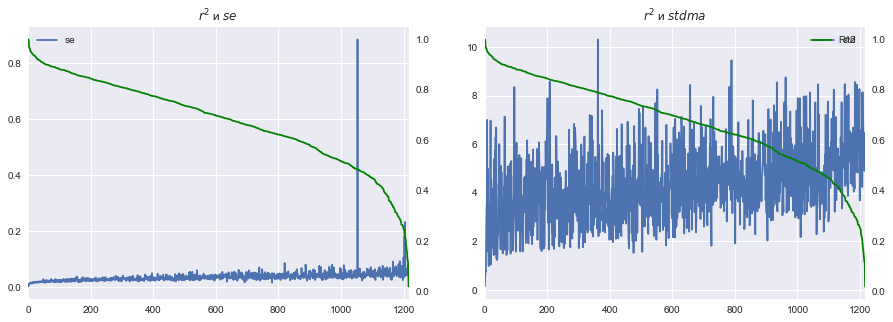

In [21]:
# reset filter
fltr = d['std'] > 0.1
fltr = (fltr) & (d['coint'] == True)
fltr = (fltr) & (d['part2'] == True)
df = d[fltr].copy()
df = df.sort_values(['R^2'], ascending=False).reset_index(range(len(df.index)))

# draw charts
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ax2 = axs[0].twinx()
axs[0].set_title('$r^2$ и $se$')
df[['se']].plot(ax=axs[0])
df[['R^2']].plot(ax=ax2, color='g', grid=False, legend=False)


ax2 = axs[1].twinx()
axs[1].set_title('$r^2$ и $std ma$')
df[['std']].plot(ax=axs[1])
df[['R^2']].plot(ax=ax2, color='g', grid=False)

"""
ax2 = axs[1][0].twinx()
df[['R^2']].plot(ax=axs[1][0])
df[['Percentile']].plot(ax=ax2, color='g', grid=False)
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA4gAAAFCCAYAAACzXPM1AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3XlAFOUbwPHvLrdyeaDiASqC940H3kqeaZnmWaZl6q+yO68uLS21sstM00rLNDXLPPLE+0RAEUFBQQVvOUUOuXZ/f6AIcuwCC7PA8/lH2Z1553lndnfmmfed91VptVotQgghhBBCCCEqPLXSAQghhBBCCCGEMA6SIAohhBBCCCGEACRBFEIIIYQQQgjxgCSIQgghhBBCCCEASRCFEEIIIYQQQjwgCaIQQgghhBBCCEASRCGEEEIIIYQQD5gqHYAQ5VlAQACfffYZpqam1KxZk4ULF2JmZqZ0WEIIIYRByflOiPJDpdVqtUoHIUR5defOHWxtbbG0tGTRokU0b96cAQMGKB2WEEIIYVByvhOi/JAupkKUoBo1amBpaQmAmZkZarV85YQQQpQ/xna+W7JkCZ988omiMQhRVsnVqhCl4Pr16xw9epTevXsrHYoQQghRYkrjfNejRw/OnTtX4DKhoaE0bty4xGIQojyTBFGIEpSRkUFCQgLTp09n/vz58jyGEEKIcqm0zncxMTFER0fTqFGjApeTBFGIopNBaoQwoL/++ovt27fj6OjInj17mDJlCt7e3kydOpWGDRsWu/yrV68yd+5czpw5Q1paGq1bt2blypUAbNiwgVWrVnH79m3atm3LwoULqVatWrG3KYQQQjxOifPdnDlzGDJkCBqNhk6dOmFubs7Ro0dRq9WsWLGCVatWYWJiwqxZswgPD8fV1TUr1p07d1K3bl22b99O1apVWbJkCUePHmXlypUkJyczd+5c+vXrR3R0NB988AEBAQEkJyfTqVMnvvrqK6ytrYtdJyHKCmlBFMKAQkJC8Pf3x9PTE29vb6pVq0ZAQAA//vgj48aNY/v27bnW8fb2ZvDgwVl/f/zxx/Tp0yfP8qdPn07Pnj05duwYx48fZ+rUqQAsW7aMdevWsXTpUo4fP07NmjX59ttvS6aSQgghKjwlznfOzs7MmDGD/v37c/r0aby9vTE1NWXJkiXs37+fLVu2sGPHDlavXo2Dg0NWUhcSEkJgYCADBgzgxIkTuLm5MWnSJAD27NnDq6++ytKlSwFISEhg3LhxHDhwgP379xMbG8u6desMvfuEMGrSgiiEAQUHBzNx4kQ8PT0BeOaZZ3jmmWf0Xt/X15d9+/Zhbm6e5/tXr14lIyODjIwMLCwsaN++PdHR0SxbtoxNmzbh7OwMwLPPPisP5wshhCgxSpzvHm63adOmWcvFxMTw66+/snnzZhwcHADo1asXZ86cyRHr5MmT8fDwAMDFxYXU1FTGjx8PgJubG+np6QA4OztnnUvNzc3p0qUL8fHxetdLiPJAWhCFMKCQkJAiD+udmprKvHnzmDZtWr7LfPnll+zdu5fu3bvz/vvvExcXx/Hjx0lNTWXEiBG4u7vj7u7Oyy+/jI2NTVGrIYQQQhRIifMdwPnz52nSpEnWcsePH6dhw4Y4OTllvRYVFZXj+cOQkBB69eqV9XdYWFiOv0NDQ7O6xe7YsYPRo0fj4eGBu7s7K1asoH79+kWqpxBllbQgCmEg169fJz09vcjPXixfvhxPT88C1/fw8MDDw4Po6GgmTZrEpk2bMDc354knnuD7778vauhCCCGE3pQ6340fP56LFy/mSBBjY2NzPG+flpbG3r17mT59elasaWlpNGjQIGuZ8+fPM3HixKy/Q0JCaNq0KcePH+err77im2++oVmzZgD06dMnR4ulEBWBtCAKYSDBwcG4ubkVae6nyMhIvLy8mDJlSr7L7N69mytXrqDVaklMTCQ+Pp4mTZrQrFkzvL29CQoKAjKfn/Dy8kKr1Ra5LkIIIUR+lDrf3b9/n/v37+c4vzVo0AA/Pz8uX77MvXv3mDNnDjdu3MDNzS3PWBMSErhx40aOFsbg4GCaNGlCSEgIjo6ONGnShPj4eN5//31iYmJwcXEpdD2FKMukBVEIA3l4gimKu3fvsmTJknyfxQDw8/Pj008/JTExkRo1auR4nuK1117j9ddfJzY2FhsbG3r37s0TTzxRpFiEEEKIgih5vhs9ejSDBg3C2tqaQ4cO0bVrV5588kmGDx+Og4MD/fr1w8LCIqtb6OOxBgcH4+TkhJWVFQAajYaLFy/StGlTWrZsyc6dO+nUqRONGjWiV69euLi4FBirEOWRSivNDEIIIYQQQgghkC6mQgghhBBCCCEekARRCCGEEEIIIQQgCaIQQgghhBBCiAckQRRCCCEUcObMGcaNGwdAeHg4Y8aMYezYscyePRuNRqNwdEIIISoqSRCFEEKIUrZixQo+/PBDUlJSAJg/fz5vvfUWa9euRavVsnfvXoUjFEIIUVFJgiiEEEKUMicnJxYvXpz1d1BQEB07dgSgR48eHDt2TKnQhBBCVHBGPQ9ienoGsbFJSodRoqpUqVTu6wgVo55Sx/KjItTTGOvo4GCjdAilpn///ly7di3rb61Wi0qlAqBy5crcu3dPZxlyjiwfKkIdoWLUU+pYfhhbPUv7/GjUCaKpqYnSIZS4ilBHqBj1lDqWHxWhnhWhjmWJWv2oQ09iYiK2trY61zE1NakQSbXUsfyoCPWUOpYfFaWeeTHqBFEIIYSoCJo1a4a3tzedOnXi0KFDdO7cWa/1IiN1tzSWZQ4ONlLHcqIi1FPqWH4YWz1LO1mVZxCFEEIIhc2YMYPFixczatQo0tLS6N+/v9IhCSGEqKCkBVEIIYRQQN26ddmwYQMADRo04I8//lA4IiGEEEJaEIUQQgghhBBCPCAJohBCCCGEEEIIQBJEIYQQQgghhBAPSIIohBBCCCGEEAKQBFEIIUQZcubMGcaNG5fr9X379jF8+HBGjRqVNfCLMA5//70+12spKSk8++wQBaIRQgjDOXXKl8GD+zJ16mRef30KL730PB9+OIO0tDTS09NZu/Z3tFotAAkJCUyf/jZTp05mypQXCQwMMGgshjw/yiimQgghyoQVK1awZcsWrKyscryelpbG/Pnz2bhxI1ZWVowZM4Y+ffpQvXp1hSIV2f32268MHz5K6TCEEKJEtG/vziefzM/6e86cDzhy5CCJiYns2LGNOnXq0rNnH9avX4O7ewdGjhxLRMQV5sz5gF9/XWOQGAx9fjTqFsSFRxaSkJagdBhCCCHyEBERziuvvMTUqZN59dWXuX37FsuW/cArr0xkypQX2bfPK8/1Qq/f5UxoVKG35+TkxOLFi3O9HhYWhpOTE3Z2dpibm9O+fXt8fHwKXX5Zs+PiDqVDyOXxz8Svvy4nPv4uX321gKSkJGbOfIfXXpvEokULlA5VCCEMLi0tjejoKGxsbNm8+R8WLVrMunVr0Gq1jBw5lqefHgZAenoG5uYWOdZNup/GXr9rpKRmFHq7hj4/GnUL4sy9M4m9d4933WcoHYoQQhi1DftC8Qm+o/fyJiYqMjK0BS7ToUkNRvZplO/7Pj7eNG3anFdffZMzZ05z+PABbt68ztKlv5CSksKUKS/SoUMnbGxscqz3+Wo/AH6d2UfveAH69+/PtWvXcr2ekJCQYxuVK1cmIaH831wctmEYAS+EYG9ZJc/3C/uZ0EdhPxNVqlTh33//5r33ZrJ27WoaNHBhypTXCAoK5NQpX4PGJoSo2OYc+5CtYf8apCy1WoVGo2WIy1DmdJlX4LJ+fr5MnTqZuLhYVCoVTz01jKioSNzdO1KjRk2aNm3G4cMH6dGjFwDR0VHMnfsRb7zxbo5y/th9gRPnbhMdf5+RvfP/nc2Loc+PRp0gAgRGnVU6BCGEEHkYPPhp1qz5jXfffZ3Kla1xdXUjJCSYqVMnA5Cens6tWzewsWlconFYW1uTmJiY9XdiYmKupLQ8up9+n4txF+hQq5PSoWR5/DMxZcprWe9dvRpBly5dAWjevAWmpkZ/CSKEEDo97GJ6924cb7/9Go6OtenWrUfW+9kTwbCwUGbPfp/XXnuTtm3b5yjnWmTmeex2TJLBYivq+dHof53vpsQpHYIQQhi9kX0aFdiy8zgHBxsiI+8Va5tHjhykdeu2vPTSZPbs2cny5T/i7t6JGTM+QKPRsGrVz9SpU7dY29CHi4sL4eHhxMXFUalSJXx9fZk4cWKJb9cYFHSOLOxnwhAe/0ysWfNb1gANDRo0IDDwLN279+LChWDS09NLNTYhRPk2p8s8na19+irKOdLOzp6PPprLG2/8jyZN1uZ6zu/y5Ut89NEMPvlkPq6ubgaJU5einh+NOkG0NrcmThJEIYQwSk2aNGPevNn89tsvaDQa5s5dyJ49O3j11ZdJTk6iR4/eVKpUucS2v3XrVpKSkhg1ahQzZ85k4sSJaLVahg8fTs2aNUtsu8bkbspdpUPI4fHPxOuvv8PNmzf49NOPmDHjQ+bNm80rr0zE2bk+ZmZmSocrhBAG1aBBQ559dhTffvsl8+YtzPHeTz/9QGpqKt999xWQ2bq3YMHX2ZYo+LGPwiju+VGlfXhrLx8ajYY5c+YQEhKCubk58+bNw9nZOccyMTExjBkzhi1btmBhYcHy5cs5fPgwAPHx8URFRXH06FFWrVrFX3/9RdWqVQH45JNPaNiwYb7bdvrGCa0GTr0QpLMiZZUh7uKXBRWhnlLH8qMi1FPJOr60YB+Q+xlEB4fy3y3UkFSfqJjf/UsmtpyidCglRr6L5UdFqKfUsfxQop4f/+LNtchE2rk5MHVYy1zxlCado5h6eXmRmprK+vXreffdd1mwIOfIY4cPH+all14iMjIy67XJkyezevVqVq9eTa1atVi4MDODDgwMZOHChVnvFZQcAtS2qc21hKtExIcXpW5CCCFEuXbw2gGlQxBCCFHO6EwQ/fz86N69OwBt2rQhMDAwZwFqNStXrsTe3j7Xurt378bW1pZu3boBEBQUxPLlyxkzZgw//fSTzuCeaPgEABdjQ3TXRAghhKhALEwsuHL3ktJhCCGEKEFRccmlvk2dzyAmJCRgbW2d9beJiQnp6elZo4917do133V/+uknvv76Ud/aJ598krFjx2Jtbc3UqVPZv38/vXv3znf9+vb1AUg1SyzXXY/Kc92yqwj1lDqWHxWhnkrXUentl3X17esTlRSpe0EhhBBGL69n/s6Hx/Lln6fZuujpUo1FZ4L4+PCoGo1Gr6GpQ0NDsbW1zXpeUavVMn78+KyhVXv27Mm5c+cKTBBrVK4BwH/ndzKw9jM6t1kWSV/u8kPqWH5UhHoaQx0f374kjIXjUNmBkOgQ4lPuYmthp3Q4QgghDECV7f8XriozWKfOLqbt2rXj0KFDAPj7++Pmpt+wrMeOHaNHj0dzgCQkJDB48GASExPRarV4e3vTokWLAsto7tAcgJ2XtxMpd0mFEEKILK5VXQFYePIzhSMRQghhaPeSUtl85LIi29aZIPbt2xdzc3NGjx7N/PnzmTVrFitXrmTv3r0Frnf58mXq1auX9beNjQ1vv/02L7zwAmPHjqVRo0b07NmzwDJcqrowvcP7xKfe5dktQ7iffl/PagkhhBDl27cDvqVWZUdWnF3Gn+f/UDocIYQQBvTH7guKbVtnX1G1Ws2nn36a4zUXF5dcy+3bty/H37Nnz861zNChQxk6dGihAny7/TRO3fbFK2I3h68doG/9AYVaXwghhCiPbC1sWTNoA/029mKJ/3eMafq80iEJIYQwkNsxSYptW2cLotJM1CZMavUKAB8cmcG91HiFIxJCCCGMQ0uH1nSt04MLsSH8HLBM6XCEEEIU1WOj1GgKnqq+RBl9ggjQo24vWju05Ur8ZVYF/ap0OEIIIYTRmNnxAwA+Pf4xiWmJOpYWQghh1B6MUqNRLj8sGwmiidqElQMyn6/Yefk/haMRQgghjId7rY486zaK+xn38b55XOlwhBBCGIBGwQyxTCSIAHVt6uFsWx+fW94sODlPBqwRQpQ5h87cYPHfAWgV7DYiyqdBDYYAMHHXC3jfPKFwNKKw7iakcDjghqJdyoQwRilpGUqHUCGVmQQRYGbHDzFVm/K17xe8c+B1ucgSQpQpq3YEc/piFLH3UpQORZQzfev3p7NjFxLTEhi+eTCnb/spHZIohK/W+bNyezCnQmRKLyEgs/XspQX7eGXRQe7EJRerrLT0jDKRMxhThGUqQRzuNpIzL4TQ2qEtGy+sZ5HvQqVDEkKIQlOpVLoXEqIQLEws2Dx0B8v7riRNk8aLO58nNPai0mEJPV2Pynx2VG4eCZHpfHhs1v8vFmOy+OSUdKZ8dZAfNwUaIqxS8fAKIT1Do1gMZSpBBHCo5MCvA1ZTo1JNvvD5nF1XdigdkhBCCKE4lUrFUNfhfOTxKTcSr/PUvwPQaJW7wBBCiKLKyPb8XXEa/yIftD76XSh7rfOp6ZIgFko9Gyc+7fo5AB8emcHVexEKRySEEEIYh6lt36SRvStRyZF84fM5GRp5hkcIUXZpjarzZelJkwSx8IY2Gk6Pur0Jj79C17XuLDz5mZwEhRBCCOD7PksxV5vzte8XPPFXD3kmUQgjsOXoZZZsOqt0GGVOGXh80CAef05SEsQiUKvUbBiyiR88f8LWwo5FvgsZue0ZvMJ3ka5JVzo8IYQQQjHutTriO+4soxqPJSj6LE/9O4BFvgsJj7+idGiiIPJ4crn27+HL+MlARKWqTCaXD8YpkGcQi0itUjOy8Ri8RhyiRfVWHL52gLH/jaDVb278cnZ5mRixSAghhCgJtSo7sthzGV/0+Aa1Ss3Ck5/R4Y9WPP3vQEkUhRBlhkz/UvrKdIL4UK3KjuwdcZhdw/fzfNPxRCVHMevwe4zcOpS/L2zgbkrRRz8SQgghyrIJLSYSNCGU7/sspY51XY7fOErPdZ1Z4D0Xn1vecjNViDIgPjEV/9AopcNQhvxElbpykSBC5uhtbWu25+vei/lv2B5c7Btx8Np+XvF6mc5r2rI59B+lQxRCCCEUYW1uw+gmz+H7/Flea/Mm6Zp0vvb7kif/6cvobcOITo5WOkQhRAHm/ubL9xsDuHwzXulQSp3cxCp95SZBzK5DrU4cG+PHvpFHeavdeySkJTBp9wRGbxvGvggv+aAJIYSokEzUJszuMpfgly6zcsAaOjl6sP/qXrqv68Dc47O5k3RH6RCFEHmIjr8PQMyDfysSuWovfeUyQYTMFsUW1VvyfueP+XfodtrXdGdfhBejtw1j0D+e7I/Yq3SIQogKSm5SCaVZm9vwZMMhbHr6P6Z1mEVy+n0Wn/6Gjn+0Ysahd4hPuat0iEIIAZTRgWaKwRjGqiq3CWJ27Wt2YMfwffzz9DY8nfrid9uXsf89y3+XtsrUGEIIISosU7Up0zrMImB8MB95fIqp2oyVgT8zYedzXLt3VenwhBBCbqoqoEIkiA91q9ODPwf/zYyOH5ChzeDFnc/R4Y9WfH/qa/Zc2cmluFClQxRCCCFKnY25La+3fQv/F87hWLk2R64fov3qFkzY8Rx/hazj8LWDJKUlKR2mECUiKi6Z2zHy+TZWxckPtdJBtUhMlQ5ACe+6z6Cvc39WBf7Cn8F/MO/EnKz3XO3d6FWvD+92mEFVy2rKBSmEEEKUMmtzG048d5p/LvzF8oClbL+8le2XtwJQybQSbWq04+WW/2Owy1MKRyqE4UxfdhyAX2f2UTgS3SpiY1pxWhANtb+0Wi0rdwTT1LkKHs1rGabQXNsokWKLpEImiACtHNrwde/FvOM+Hb/bPlyIDeHA1X0Ex5xnxdllbAn7l/HNX2JQwyE0rdoMlcoYegQLIYQQJcvK1Irnmr3AqCZj8b3tw7noQM5GnuHYjSOcuHmMYzeO4OnUl1GNx9LbyRM7C3ulQxZClGMaI0ic7iWlcSTgJkcCbpZYgviQMaQcFTZBfKiuTT3q2tQDYFqHWaRlpLHw5Gf8FLCEL3w+5wufz2lk78p7HWYytNFw1KoK1StXCCFEBWWqNqWzowedHT2yXrsQE8L/vCayN2IPeyP2YKo2ZZjrCN51n0EDu4YKRiuEEIZz+PR1th4O4+2RrTE1UVe4jqqS7TzGzMSMDz3mcO7FMJZ4Lqef8wBC4y7yvz0TabDCkQUn53Ej4brSYQohhBClzq1qY/aOOMyBUceZ1mEWDlY12BDyJ53WtGHAxt7surKDtIw0pcMss4yg4UAIo6PEIDVf/OHL+fBYQq9VzBGdK3wLYn5szG0Z0Xg0IxqP5nz0Ob71+5Jtl7bwte8XfOP7JV1qd6NTbQ+qWVajs2MXmlZrjqladqcQQojyTaVS0axac5pVa87rbd/m7wsbWHbmB07d8WPc9lFUs6zGwAaDcbatTz1bJ3rU7U11q+pKhy1EDhqtlvV7Q+nQpIbSoQgdlGy9e9jds6LdvJGMRg9NqzXjp34ribsfy5awf/nrwjqO3jjM0RuHs5axNLGkSdWmdKnTnXY12jPEZag8tyiEEKJcszS15LlmL/Bcsxfwv3OKjRfW88/Fjfxx/rccy9Wq7Ej7mh1oW6MdQ1yGSndUobjQa3fZ43uVPb6lP52LVquVa8RCqCjTXBhTLSVBLAR7yyq80PxFXmj+IrcSbxIad5Erdy9z8tYJgqICORcdhH/kaSBz7sUW1VvRpGoThrmOoIplVYWjF0IIIUpOmxrtaFOjHZ90+ZzAqAAik+/ge9uHs5FnCIoK5L9LW/jv0ha+9v2SAQ0GUrOSI/3qD6BL7W5ysSxKXVq6RrFtayl6i5QxJRGGFHQlhqu3ExjQyQnIOVBLsaa5KIM77OT5OzSqo+w8tJIgFlGtyo7UquxItzo9eL7ZeAASUu9x/MZRfvRfzNEbh/G77QPA7KMf8KzbKDxqd+UJ5/5Us5LpM4QQQpRPJmoTWtdoC8ATzv2zXr8UF8rm0E2sOLuMfy5uBGDpmcW42DdipNsYOjl64FG7qySLolSU1fnxymtr2qJ1/gD0blsHC3OTHO8ZRY1L+WdprdfF0t3gYyRBNCBrcxv61h9A3/oDuJsSR0R8OLuu7GD1uVWsDV7N2uDVVLGowpim4xjUYAjutTooHbIQQihGullVLA3tG/G2+zTebP8u1xOuERQVyIaQP9l+eSvzT84FwKN2V4a7jmRAgyepUUmeDRPlVHGaEMs5TR4JcGkkxdciE1jyz1kmP9WcBo622bZd4ps2SjKKaQmxs7CnpUNr3uswE5/nA9j2zB6mdZhFqiaNH/2/Z/Cmvgz+px/BUcFKhyqEEEJhaWlpvPvuu4wePZqxY8cSFhamdEg5nAmNMtizWmqVmno2TgxoMIhfB6zm9LhzrBqwlh51e3P8xlHeO/gm7X5vxpc+89FolesGKIQwEsXpYqrnyhsPhHE7NpnVu0KKvrHiMqJsVGeCqNFo+Pjjjxk1ahTjxo0jPDw81zIxMTH079+flJQUIDPT7969O+PGjWPcuHEsWrQIgH379jF8+HBGjRrFhg0bDFwV42VuYk5Hx05M6zCL8y9eYs2gDfSo2xvf2ydp/mNzXt41nvXBawmJCS63XQeEEELk7+DBg6Snp7Nu3Tpee+01vv32W6VDyuG7jQH8WUJdnhytazOo4WA2PrUZn+cDmNPlM0zUJnzpMx/Xxa7M9/6UveG7ibsfWyLbFxWUgpdbZbV7q1LyalUsbYZu8E1ITiM9w3hvgOnsYurl5UVqairr16/H39+fBQsWsHTp0qz3Dx8+zKJFi4iMjMx6LSIigubNm7Ns2bKs19LS0pg/fz4bN27EysqKMWPG0KdPH6pXr1hDX1uaWtK3/gCecO7PEv/v+fHMd2wJ28SWsE0ANK/Wkmdcn2WIy9PUt20g3a+EEOWW9LJ6pEGDBmRkZKDRaEhISMDUtGI+AeJsW59X27zOoAaD+eDIdPaE7+Ibv68AsDCxYFCDwTzjOoIedXtRyaySwtEKIUThRcYlM2PZcbq2rMWLA5sSl5BCVVtLpcPKQecZyM/Pj+7duwPQpk0bAgMDc7yvVqtZuXIlw4cPz3otKCiI27dvM27cOCwtLZk1axapqak4OTlhZ2cHQPv27fHx8WHgwIGGrE+ZoVKpmNr2Teb0/YBN/v8RGHWWQ9f2szdiD0HRZ5l3YjbNqrVgmOsI+tUfQOMqTSRZFEKIcqpSpUpcv36dgQMHEhsbm+MGa0EcHGxKODJltufg0IrdjXYSmRjJ7rDd+N/y58/AP9kU+jebQv/G0tSSpxs/zegWo+nh3IOqVuVjpHAbG8tSP6alyZjqZhudlOs1Q8SnTxnVq9tgalK0p7xsbawU348luf3q1a2pZGmGXbbjY2VlXuRtRielZf2/oDLMzTNTIlMzkxzL2dtXwsHBBvOEFL3K0YfPxSgAjp69hdrEhMP+1/n+3V6YFPEzURJ0JogJCQlYW1tn/W1iYkJ6enrW3c2uXbvmWsfBwYHJkyczcOBAfH19mTZtGrNmzcLG5tEOrVy5MgkJCToDVPpLUBqGtR3MMAYDs7gUe4ntF7ezJWQL+6/sZ96J2cw7MZsG9g0Y7DaYmd1mUtumttIhF0lFOJZSx/KjJOtZrZo11e2tSqx8fSl9LKtXt8FELTe+AFatWkW3bt149913uXnzJuPHj2fr1q1YWFgUuF5k5L1SilCZ7Tk4ONDP8Sn6OT7Fe20+ZG/4bo7dOMqWsE2sD1rP+qD1mKpN6ezYhXHNJjDEZSim6rLV+pr9e5iQkFLq+7i0ODjYGFXd7t5NzvVacePTt46RkfeKnCDG30tWdD+W9HGMikrAysI0x/FJTCr69yI29lGiWVAZqanpACTfT2PLgUfd6ePikoiMvMe9pFS9ytHHletxAJioVRz2vw7AqXO3yDCiLqc6f0Wtra1JTEzM+luj0ejs+tKiRQtMTDKHqHV3d+fOnTu5yklMTMyRMObHmH5MSsLjXzQbHBjVYDyjGown7n4s2y9v49C1/ey8vIPFJxez+ORimlZtRve6PRnd5HlaVG+pYPT6M7YTQ0mQOpYfJV3P6OgEtGnpJVa+PozhWEZF3kOdLUFUOmFVkq2tLWbfHVxeAAAgAElEQVRmZgDY2dmRnp5ORkaGwlEZF7VKnTVS+McenxIQ6c/OK9vZE76LI9cPceT6Id458AadHT3oV38gIxqPxtrMWnfBokIygsfahJ5K81hdj0xkxdZzj7b92L+G8HDsLRO1igxNZskarXE9maozQWzXrh379+9n0KBB+Pv74+bmprPQH374AXt7eyZNmkRwcDCOjo64uLgQHh5OXFwclSpVwtfXl4kTJxqkEuWVvWUVxjYdx9im40jLSGPN+d/579IWTt46wfmAcywPWEo9GydaVm9N97o9aVatOZ0cPVCrjKeJWgghhG4TJkzg/fffZ+zYsaSlpfH2229TqZI8Y5cflUpF6xptaV2jLTM6fsClu2Es8/+BI9cPsTdiD3sj9vDRkZk0rtqUHnV70aJ6Szxqd6W2dR2lQxf58AuJJCb+Pn071Mt3mYTkNK5HJtDYqYoBtmhMl+P6q4iJbWnUWen9qvT2H6czQezbty9Hjx5l9OjRaLVaPv/8c1auXImTkxOenp55rjN58mSmTZvGwYMHMTExYf78+ZiZmTFz5kwmTpyIVqtl+PDh1KxZ0+AVKq/MTMyY0GIiE1pMJCUjhU0XN7Lm/O8ERQWy/fJWtl/eCmROr9G0ajM8nfrStFoz3Ko0ob5dA4WjF0KI3LQyTE2WypUr89133ykdRpnV0M6FL3p+A8Clu2H8EvATXhG7ORt1hrNRZwBQocLJ1hmP2l3pWKszrlUa06J6SyqbVVYydPHAkk1nAQpMED9ZeZLo+BQ+m9QJx2pl97gZWzJg7PIa4T/0+l1+2hzImyNaU9ehgJ4ChtrXhjxmeZz2jG0WA50Jolqt5tNPP83xmouLS67l9u3bl/V/Ozs7li9fnmuZPn360KdPn6LEKbKxMLFgdJPnGN3kObRaLWejznAhNoQj1w5x8tYJTtw8xombx7KWH+b6LJNavUL7mh0UjFoIIYpOo9EwZ84cQkJCMDc3Z968eTg7O2e9/+uvv7Jt2zZUKhX/+9//6Nu3r4LRll9ardboB0xraOfCZ92/4DO+IO5+LKfvnOJ8zDm8wndxNiqAdcFrWBe8BgAHqxq80e5tRjUei72lIVqlREmKjs8cKCT2XkqZThCLw7g6Ihbe3YQUDgfcpF+Hepibmei1Tl41/n1nCNHxKWw6dInXh7cqdlxK/6wVNz809DmybD3JLXJRqVS0cmhDK4c2POs2CoAbCdc5E+lPSMx5Nl38m38ubuSfixvp5OjBwh5f06xac4WjFkKIwp0QC5pyKT4+nt9//53du3eTnJzM0KFDJUEUQOajGr2dPOnt5MmrbV4nXZOO/51ThMQEcybyNGvPr+ajo7NYcPIzJrX8HzM6foCJWr+LVlG2KdtgU7aTvOJYujmIC1fj0Gi1PNVVvx5uebeuGXYf6vo8lMQRy1VmMTZi6HOkPKxWDtW2rsPABk/yVvv32DfyCOsHb+IJp3543zzOiC1PsyrwF85GBZCUlnuIZyGEMEYFTblkZWVF7dq1SU5OJjk52ehbuMqysn5Za6o2xb1WR55r9gJf9PyGUy+c42OPuVibWfPtqa+YtHsCu67s4GbCDTRa4xlRUORU1r/hRtabsFTdis4csDIuITXP9/PaN3m+9uBfXb/3BmtxLeCgXb4Zz4mgW3oXlVfEmmJ+KAx9jpQWxHLORG2Sdff018AVfHhkBtMPvZ35nsqE7nV70qp6G5pVb07zai1xsW9U5oYIF6KsqcgXB0Wla8olR0dHnnzySTIyMpgyZYpSYYoypkalGkxt+yYvNJvAiK1Ps+3SZrZd2gxAHeu6dK3TnebVWtK8eguaVWtBdavqCkcswDA3KuRnWBkP97tGoyE5JR0rC93XnAWdM0v8ZoEeJ+y5v/kC4N6kRpGnLynudYGhz5GSCVQgL7WYRO96nuyL8CIwKoBTt305cHUfB64+en7U0sSSCS1e5pMun8ldeCGE0ShoyqVDhw5x584d9u7dC8DEiRNp164drVoV/7kU8ZhyOq6QrYUd24ftZW/Ebk7d8SMkJpgDV/exIeRP4M+s5epa1+O3QX/Ssrp8tkTR5ZcLZGg0qFWqgq+/SjGz9Q+NorKlKa517Q1W5sNE6NCZmxw6c5Ofp/fOMd1RnuvkVenHXoqJv4+9jQXqErp2LfHdXswM0dDnSEkQK5gGdg2Z2HJy1t8x96M5Fx3EuahAgqID+TP4D5ad+YG/L2zg1TZv0KJ6S7rU7oaZiZmCUQtRvpT1QQaUUNCUS3Z2dlhaWmJubo5KpcLGxob4+HgFoy2/yvPIsyZqE/rVH0i/+gMByNBkcPnuJYKiz3IuOpBdV3ZyLjoQzw3d6OP0BGObjKNF9ZY0tG+kcOQVT1n6BB4LvImVhSltXR0KXC49Q8PkLw/QplF13njWOG5AfL8xAIBfZ/bh0Jkb1K9lY/D5ajM0Wt0JYkH5oQouXI1jwZpTeLary3P9ck7H9/i6Wq2WtXsu0tKlKq1c9O8RUNI9fzTa4l0bGPocKQliBVfVshrd6vSgW50eAIxqPJZfA1ewL8KLT45/CICTjTNDXIbSvW4PWlZvg0Olgn/khBBCH4U54eqacunYsWOMHDkStVpNu3bt6Nq1a8kFLioEE7UJjaq40qiKK083Gsb0Dh/whc9nHLy6n30RXuyL8ALgCad+9Ks/kPY13WlctSnmJuYKRy70Ukr36X7edh7ITLIK2nZSSjqQ2WpnbGLi77NqRzAAWxc9XcJby9w52VPGvAapuRGVmLXcpRuZyc7eU9dyJYiPuxWTxN5T19h76lrOY2IAhU0isy9f3BvHhj5HSoIocuhSpxtd6nTjTtIdvMJ3sSd8F/sjvFji/x1L/DPn6KpV2RFXezdebDGJwS5PKRyxEGWQNCAWmq4pl9544w3eeOON0g6rwqnIz8+aqE2Y1eljZnb8iBM3j3Hk+iG2hW3BK2I3XhG7ATBTm9HI3pV2Nd2Z2ekjalaS+Z5F2ZeaXnoDNhXlJ6ayZf7pzOPJZYam5H7E9J7LMCv7zZEhFouhz5GSIIo81ahUg7FNxzG26TiS05M5ev0Qvrd9OBt5hqCoQI5cP8Th6wdpW6Mdk1u9Sv/6A7E2N2y3AyFEeVeBs41yJib+PlVsLCrEs+sqlQqP2l3xqN2VaR1mER5/hYNX93Mm0p+zkf5cjLvI+Zhz/H1hA883G8+oxmNp5dCmQuybUlPG92VxWovK36+m7hoVuIRKRSXLkn8MSp/kT99jo8qjk7SxHVdJEIVOVqZWPOHcnyec+2e9djH2ArOPvo9XxG5e8XoZU7UpLau3wr1mRzo6dqZ3PU9sLewUjFoI42VsJwIhiuPk+dss2xzEM90bMETPec3KE2fb+rzQ/MWsvzVaDauCfuE7v0X8fPYnfj77E9Usq9HR0YP2NTvQvU4P2tRoJwljPrRabansG3kWXH+GPBq6Eq3C9lJQAWam+Y8cWtxeD4VZXa8kUqvN87Ond+tjKZEEURSJaxU31g7eyMXYC2y6uJH9V704E+nP6TunWHF2GZVMK+FeqxNNqzalf4NBDKziqXTIQgghiimvaxj/i5nPTB0NvFUhE8THqVVqXmoxieeavoBX+G62hm3C++YJdlzexo7L2wBoaOdCi+qt8KjdhRFtnlE4YuNSfodBeqRYuYASeUQJHhBD5EUFJVe53ivB/VdQXS7fjCdDo+VPrwtcvnkv1/sarXF14ZcEURSLaxU3pnd8n+kd3ych9R6n75zi0LUD/BWyjkPX9nPo2n5+CvgR2522DGowhAH1n6RzbQ+qWlZTOnQhFGNE5wBFGdPJUOhLDpq+LEwseLLhEJ5sOAStVktYXChno86wLngN3jePc+luGFvCNjHr8DRsK9endloPwhIH0Udbp2K3LlaEDFFkMciclgUUYqhfLH3OVwUt83CuxPyWv/9gkCJjIQmiMBhrcxu61+1J97o9+aDzbBLSEvC+cYwDV/ex/cpW1gWvYV3wGszV5rSu0ZZhrs8ysvEYbMxtlQ5dCCFEEUnKqJtKpcoaEfUZ12fRarVcvRfBnvCdHL19kP9CdhJs+TsfBv7O4ku16FWvD881G0+nWp0rXLJYalOpGNkH15iPconG9thxSE5JL1SypFIV3F24dA9z0be2wzvCgHEUnySIosRYm1nj6dwPT+d+/Dh0Mf+d9eLItYNsvLAen1ve+NzyZt6JT+hdz5O2NdvzZMMhNLRz0V2wEKJcMLLrM6EHafU1DJVKhZOtMxNbTmFmn/fo/+4f3DHzxbpeGD6xe1gfspb1IWtxq9KYHnV70bVOD3rV60Nls8pKh14kGw+E4VTbjo5uuuedk89Ywcrbs5OP12fGsuMAvD68ZfaFCi6joPf13F269qs++70EB0gtdZIgilKhVqnp7OhBZ0cP3uswk7C4i2wN28yqwF/Ydmkz2y5tZu7xj2lf050XW0yiZ70+VLOshqlaPqKiHJIrIFFGySe3ZJhjQ9203jzfaAodW9rjd8uH34J+ZcflbVyIDeHnsz9hY27LUy5DebHFyzS0c6GymXWZaV3cfiIcgI4GmnfOELVW8rNc5k4BJfg5y29fpGfov5MKfAbxsSNd5F1f1o5ZMcnVt1CEi70rb7V/jzfavUNo7EX2X/Xi7wsb8Lvti9/tzH7aliaWdHL0oGe9Pjzf9AXsLasoHLUQQghRsqzNrOlZrzc96/Xmbkoc/ndOs+3SFjaErGXN+d9Zc/53AJxsnOlWpwfPuD5Lj7q9ykyyqEuZS55KmRL7x7CjmBZ+m4+vkj0hVKlUBmlBzGvqiUKsDoAmn0AKSmBVhdxGaZEEUShKrVLjVrUxblUbM6X1a5y+7ceOy/8RGneRsLhQDl7bz8Fr+5l3YvaDUd9a0tKhDe1ruNO6Rtsy291GVGzGeDJQhOyIskeOWamys7DPShbndVvAhpA/8b9zimv3rnLqjh9rg1ezNng1Nua2NK/WghbVW9LaoS0danWkgZ1LuUkay5/ML1LgpWhqVK1EDXsrheMpPbmTveKVpyL/xCyv7RWVXuXks1ByAc9UZia4xvfDKgmiMCpta7anbc32WX9HJkWyLmQNe67s5Fx0EP+G/sO/of8AYKIyoXn1lnSp3Y1udbrTvW4vrEwrzo+sEEIYE0lFSpaFiQXjmk1gXLMJAETciWdH8CECUrfgf+cUJ2+d4MTNY1nLV7WsSsdanelSpxueTv1oZO9aRhJG3RfLhqhGXtfku32u0rN1bSzMTYq/gYK2DSTdT+frDWcA+NVAXW9LSmF2d0paBmamatR6H6TCDw9amCQz1ywX2V64E5fMkYCbDOlSP/9nDLV6R5lvojdt6bE8X9dqH3yWjS8/lARRGDeHSg683vYtXm/7Flqtloh74QRE+uN7ywff2ycJiPQnINKfZWd+wMrUih51e9Grnic96/bGxb5RGTkZigrHCE8GSihvgy1UBHLMSlZhzlhzfvUFKjF34tfUcbAmKS2Jc9GBnL7jh99tH3xv+bDzynZ2XtnOx0ffp6GdC55OfelZrzcetbsa7QjixZ1OoDjW7b1I3L0URvZpVDIbyCY1PaPEt1Ha0tI1vLLoIE2c7Jk+tp1e6xTpUGZfSaVrkvn831u07jSRcfextzYvYO1CPAuZz+vJKfkfa2O9TJUEUZQZKpUKZ9v6ONvWZ4jLUACS05Pxu+3Dvggvdl3ezq4rO9h1ZQeQ+QxjPRsn6tjUpX3NDrza5nWjPSEKIURZkNd1WHG7R4XfukeNKlZYWcglSVHcT828+KxkVgn3Wh1xr9WRSbwCQER8OMduHGH3lZ3si/BixdllrDi7DIDqVtVxtq1Pbeu6PN90PL3q9TGKm6pK34KIjEsu8W1o85gU3Rj2PcCtmCTup6ZTv9aj6yV9j0lCchoAwRFxem8vv58PbT7/z/w72zOIebyvT/kAkXH3AbiXlJbvM4hZhevxO1eUn0KVkTYhyq+xKNOsTK3oVqcH3er04GOPT4mID+fA1X0cu3GY0LhQwuOvcDHuAgeu7mPJ6e8Y2OBJJrV6hXY13VGr1EqHLyoo4zsVKGP/qesM7OysdBhCQbdikvhklQ91HCozd2InpcMpmwrIK5xsnXGydWZ0k+dIzUjF99ZJDl7bh+9tX67GhxMQeQa/275sDfsXZ9v6TGw5mWGuI6lRqUbpxf84PX4gDZNLyS9xXt5ffgLI2e3VsHtKv9L0v/FU8DN8+nYNza+lsDB1L8rNMiO5L5CLJIiiXHGydeaF5i/yQvMXs16LTIpkVdDP/BWyjk2hf7Mp9G9szG3pWbc37Wq606FWJzrU6igJoxCl7K8DYZIgVnBRD1prrkcmKhxJ+WduYk6XOt3oUqcb+09dI+xGPC8914Qj1w+x9vzvbA3bzMdH32f20Q9wsW9EX+cBNK3WjF71+lCrsmO+5aakZrB+30WecK9H7erFHzjubmIKNcwrFbuc0hITfx9zMxOsrcyKVU5BycWVW/HFKrvYDNint6BnAvXdZO4yCtpg/m89bLsraP34xFR+2XaOzi1qFbARPeLIR2qapvArlQJJEEW551DJgWkdZvFWu/fYeeU/vMJ3c/TGkaz5FwGqWznQtFpz6ts2YEyT52hfs4PRdPcQ5Y8xjlgmhD4K/OjKb6Yi8u0aV4DVuy8AMGFgE3rU7UWPur2Y0fES2y9tY99VL3xvebP0zOKs8ptWa04Du4a0r9kh17RTXn5XOeB/gzNh0Sx6rWux6zPzpxPKDtpSyN353o+ZA5A8HnNcQgq2lfN/tu1xBX21Fv99tnBBGVhJnrHyK7swz/4VPIqp7gxRizbf79HGg2HcTUgl4FK0zjgK+4y2Fi3WVmZZXXONiSSIosIwMzFjiMtQhrgMRavVEhYXSkCUPzsu/YfPLW8OXzvAYQ6w+txKXOwb8UyjZ2lbox0dHTtjZ2GvdPhCCCFELobKyxvYNeS1tm/wWts3SEi9R1B0EMdvHGHH5W2ExARzLjqQ/y5t4XPvT+jnPJDeTp50rNWZxJTMET/jE1MNE0gpKcn7dFduxfPpKl+6tcy75bUwNwn3n7pG7L2UbOsWO7zCUyZDfPTfgnI8VdFbENUqFRlabeYzofksmPLgGd97SbqTuKIcG9e6dpy+GFX4FUuYJIiiQlKpVDSq4kqjKq4Mcx0BQFJaEj63vFl9bhVbwjbxle+CrOUdrGrQtU43Rjd5ju51emFmUryuJEIIUTZJ63dFYG1uQyfHznRy7Mxb7d9Dq9VyJ+k2Gy6sY+3539l+eSvbL28FQI0pNpUbUCOjFTcS3KhtXUfh6A3nRlQiVW0tsDQv3OXyxWt3AThy9qb+K+Xz1XrY2qskQ37rcw84U/ht6ttNFUBTzFFxHw4CpY/y9OsoCaIQD1Qyq5Q1IfHtxIX43vbh1G1fzkcH4R95OmsORmszG7rV6U7Per0Z1eQ5rM2slQ5dCCFKRXm6ACovSqNnr0qlomblWrze9i2mtnkTn1snuRAbzImbx/CJCORy8lnumlykze9/42rvRq96fRjs8jQetYvf5RTgelQiweGxxSrDLySSSzfvMqKXflNYxMTf58OfvalTvTJzXy7cAEq6DklxvkdKTDWjxGMRObeZf1qpQlfL3aM3Zy47Tn1Hm0frPhhB1FD7tND7KY/RbI2FJIhC5KFm5Vo82XAITzYcAkC6Jp0j1w+xJXQTR28czppbavbRDxjZeAwvtZxMr+oeCkctygpjPSEIIYxD9N37+ATfoV+HeqjVBacbRXkGsThUKhUdHTvR0bETzzcbz8YDYfzrfZbrFntxbHSTYzeOZE2n0bRqM15u9T9SqYo5Rb+Z+tHP3sWOe8mmzOf4BnvU1zmlyqZDl7KWuR6V9wBKGo2WxX8H5PleUcYwKA+nhSIlksUdpEbHPIjZ37oTl8ydbNOYPDxMBjsnl4eD+IDOBFGj0TBnzhxCQkIwNzdn3rx5ODvnHHUuJiaGMWPGsGXLFiwsLLh37x7Tpk0jISGBtLQ0Zs6cSdu2bdmzZw8LFy7E0TGzT/brr79Ox44dS6ZmQhiQqdqUXvX60Kte5kPo4fFX+M5vEV4Ru/nj/G/8cf436tnW4/kmE+jfYBBNqjaVUVGFEOWO3NwoHV/+eZo7ccnYVDKjaz7PsRmCIY6nFi3mWltc04axfHBvUjJS2H1lBysCluF324d3D7wBNmpqpLdjS+hdutftSRXLqsXfcFHj1VHn8Fv38AuJ1FnO9ahEzoTlPXCJzvxQW7YGK9Onm6beHu8eqs8qOhYqanhZx6mQBdxNSMHO2iLX63kNluMbfCffcjJHUDXOz4HOBNHLy4vU1FTWr1+Pv78/CxYsYOnSpVnvHz58mEWLFhEZ+ejLtHLlSjp37syECRO4dOkS7777Lps2bSIwMJBp06bRv3//kqmNEKXE2bY+X/deTIYmg+2Xt7Et7F+2hP3L/JNzmX9yLpXNrGlStQnjm0/kKZdnqGRWdobsFiXPOE8HQgjFPbhifdjKEZ+ke+AX4xk8NjMQCxOLrAHhbibcYM351fx44jfumPny8u7xANSq7Eifek8wsdUUWlZvpUi0+f0Op6UXf9qBIo2CbqSJAmDYaS4e2/P5FV1gC2K2/6tQ6b3s4x62vhc0CmpednhHMNrTVedyl2/G8+O/gQUuY6xHXWcTh5+fH927dwegTZs2BAbmrKharWblypXY2z8a5XHChAmMHj0agIyMDCwsMrPsoKAg/v77b8aOHcuCBQtIT083WEWEUIKJ2oQhLk/zU7+VXH37Kj94/sTIxmOoZlUdv9u+vLHvFVqscuW/S1uVDlUIIYR4TO7L09h7KXy+2o9LN/Sce6+AK1xH69q80346PRO/o2viQqZ3eJ+edXtzK/Ema4NX47mhG8/9N4Ko5MKN4pg9ASvsxb3usvVcrojvQd67TO9aGDijSEnNIPTBoDqltEm9ZE8kc23/sS6mBU5zUcB7D4/1xWtxhQ8wD4+3tGYffTY/xnpfQGeCmJCQgLX1o37jJiYmORK7rl27UqVKlRzr2NraYmlpSWRkJNOmTeOdd97JWvajjz5izZo1JCUlsW7dOkPVQwjFOdo4MrLxGH7w/Anf5wPYPsyLsU3GkZB2jxd3Pkffv3ryV8g6EtISlA5VKM1YzwhC6FDgxVYpxiEMI6/DufXYFUKv3+W7jWf0K+PBv/klVplzzJlQJaMx73WYyV9PbebSpBss6vU9rvZu7AnfRctVrgRa/MxddVih4s/QaHh54X6WbS64laYw9G79K1aGaDzngCX/nuXzP/wIuhKT4/Uc3/USDDe/3xR9d5HuQWoKWPfBcbp88x7Rd+8Xev09Pldzfva0+rWOZm0fZQYd0ofOLqbW1tYkJj56QFej0WBqqntsm5CQEN555x2mT5+e9Zzh8OHDsbW1BcDT05Ndu3bpLMfBwUbnMmVdRagjVIx6Zq/jQAdPBrb05LWr/2PS1kmciTzNa3snY7bfjGeaPsPsnrNp5tBMwWiLpiIcRyjZelapWtko9qPEIETZV6TujPqUa6Dl87pItjazZlyzCYxqPJaFJz/jl7M/ccViG1cstmGpqcaqwA95tvEonaOEP5yC4OT5O/zvaX0j1T6IK+8Lcx1jAmUpaDF1UQapUShPCLyUmRhev5NA8/qPng0taAzR0rD9eHi+7+XupqrfIDWPyz7Akz7zHGat92C1P/dezHdb8YmpWQMjFRCA0fYx1ZnptWvXjv379zNo0CD8/f1xc3PTWWhoaChvvvkm3377LU2aNAEyD95TTz3FunXrqFWrFsePH6d58+Y6y4qMvKdHNcouBwebcl9HqBj1zK+OrpYt2f/scc7HnGNz6N+sPf8HG4I2sCFoA82qtWC420hGN34Oh0oOCkRdOBXhOELJ1zMmJpFKJsq2txjLscwegySLpet6VCI1q1hhaqL/gFpGei1ToL/2h3I1MoF3RrZROpRC02eE0uLkh4Y4nju9I/ReNuz6XVzq2GX9bW5izkcen/C2+zRGfreYq2Z7uW12kumH3mb2sffpX38gI9xGo8Usz31RpEEzdbyvfwti/suV5DQXJaWgeht0IJVccxjmvVj20UZzx/Po/ypV3mUk3U/nSMANzM1N8i2nqN+d/L6X2cPYeVK/74UxfhZAjwSxb9++HD16lNGjR6PVavn8889ZuXIlTk5OeHp65rnOokWLSE1N5bPPPgMyWyGXLl3KvHnzmDp1KpaWlri4uDBy5EjD1kYII6VSqWhWrTnNqjXnXfeZbLu0mU0XN7Ivwou5xz9mqf9iXm45hQZ2DXnCuR825rZKhyyEKMdCImJZuPY0HZvW4H9Pt9B/xTyuZoyot1yedhQigSlJaekaQiJiaVq/CiZqw41yXaxbTUUc3KMwgWT/fHy22o9fZ/bJtYy1mTW10jtRK70Tifdv0q73FTZd3Jg1/3BNq45UT2+NvaYR9hm6GyqyS0hOw8LsUZJgqM9rgfu9BO//ldjX7fGYS2hDuWc01Gcmex1v53FQ1+29yJGzN7GyKChBLHKGqDMOvYs20h9QnQmiWq3m008/zfGai4tLruX27duX9f/so5xm161bN7p161bYGIUoV8xNzBnmOoJhriOIvR/Dd6e+Zqn/YhacnAeAnYU9L7ecwlvt38PCJPcwyqIcMM7zgahALt3MHICkcF3zRHH8dSAUL99rDO/ZkCc96isdTr4Mn9sU7gevstaRGR2fY3qH9/G77cNb+1/jQuxJbpudBKBKemPORM/DrZ7uEfE1Gi1vfHeYqraPzqW6WsMM0ICos+VXm8cE6cY23UH2gV9KNDQDlJ3XIDW3YpIASE7J0KuMhORCdDHN5/XsYVia634cT4XKaC8HZKI2IRRUxbIqc7rMw/+F86wb/DfTOszCTG3KIt+FtP6tMa96TSIg0l/pMIUQRi4kIpbvNwaQkqbfxVBRGevFjD4MPdplYQWHZ46UqPfooHoqTv3UIIEAACAASURBVK2KO0BGeobuKSGKPoCICvdaHTk46gTdEr6kbdI71EzrSKxpCK8dG8ETf/Xgl8AfSSf/rogZmsz4YuIfjSZpsC6mBZahe5mC9v31yASW/htYqKRFHzeiEjl5/nae7xnixkBJdPnVvZ2iR67v86a5FDAg00OWBXRtzSomn+6xxkB3eiuEKHGO1rVxtK5NH6e+TGn1KrOPfcCWsH/ZeGE9Gy+sx8W+EU+7PENvp760r+mOqVq+usI4aDRaUtIysLKQz6SSFq49DcCJoFv0bFNH9wo6Lkqi797HupJZjq55mesZ6dWMHjQaLWoFn/3NL2nQFHcW8mKsXuD8cXqUm5TyaFR7fZ7LKgoTtQn2GlfsNa7USe9BZOoZohzXcS46kIBIf9Q2Zjikt2Pt+ev0rNubOjZ1CyzvYb3yq5++CWJBy+lVRAE75ruNAUTdvZ+j5dMQPvzZG4AmzlWwrWSe473H65O9RVOfGwmXbsQTer3g6TIyy33sb51r5LX9nH/n+RXS5xgU8WZAvp/1HC2IuhPEzHWM8zdVWhCFMDK2FnZ80/sHQideZf3gTQyoP4jw+Ct87fclQzb1Y9DfnpyLDlI6TFEMxnk6KJr5f/jx2jeHSC3hliuhn+wXSiERsUz+cj9hely0ZZd0P51pS48x+9eTBo5OWRmFSMTS0jMKnDDdLyQSv5A7xY5pp3cET0/bUqwyDP57Uohr5hzf+3z73RUrmlwcMlrzW89dBE0I5e02s7DSOHDbzJu39r9GhzWt+OLk5ySn59+qqCvz1bf6eS2360Q4V+8k6DW4UEFRPBydNb/PYHF/b1NTda+f/euiTw4z73df1j02qqdeipkgabXaPJOsEswPiYxLznPuxOxhZG+1NvT2S4Pc8hXCSKlUKno7edLbyZObCTfwueXNj/7fc+qOH73We+Bk44xblcZ41OnGq61fx0St390qIQwp7EF3ucT76Zg/3tokFLVhfyjpGVo2H71cqBE8E5JTAbgTm/siu6BLudK82Fm9O4Qa9lb07+ik9zqFaamb8tVBTE1ULJ/WO8/3Hw5fn9eAK7pkv4jcsD+00OvnLk+5W045RpPMb5kSuiVmb1GFKS3e5sIhd+LUYXTpHcsPp7/lK98FLD79Dc2qNcfFzo1YdTuqaB4NbKPrY6D35/ix5aLuJvPDX5mPhEweUvAUVlptHm1ieu6m1btCWLUjmC9f6UI1O0s9g9UtV71L6WOl12YKaHXUkve+0+cwFmU6EgCf4Dv4BOe+QfTwqN6JTWLzkct6lKQy2k4Z0oIoRBngaF2bpxo9w/bhe1nW9xf61x9IUnoiXhG7mXv8Y1r/3oQPDk8nNLYId+9EqTPWLiWi7MvrckdXa8Ye36s5/i7o02ksH939p66zfl/hkqvCtCACpGcYtrJ6tWgYdIu6Ffd46tU9sAQ+M5duxDNx4X78LkSiwoQqGjemdZjFyefO8Err13Gr0oSgqEA2XlzHUevpHKv0ARFme9DwqEtsfomr3l1MH/s7Je1Ra59eZRRxxzz8HD8caKqkGHqQmvikVPb4Xs393Gohy9ZotaRkawHNrwVRH7H3dLfyFcqDMPK6uaZjFaMjLYhClCFqlTprBFSAS3fDWHzqG/67tIUVZ5ex4uwyBtQfRNsa7WlfqwNda3eXlkUhRIH+9LpIX/d6SodR4h62IPqF3CEy7j4DOunf+pifyzfjca5lU+SWCEMo3sV78bv3KWG3T+bUJX891gJbs3ItPumaOcVahiaDDcHrmeP1LTEm54gxDSLEYi0fnxiCR91OWN/Pu5VP30NZ3Nb0Ik33kH0bhVq68OUV9hlEXVZsCSLoSmyu1wtb8pdrTxNyNVv3Tq3uVuHSculmPC517ArXm8ZY7ro9RhJEIcqwhnYufNP7B77o8Q3LA5ayPOBHdl7Zzs4r2wGoblWd55tO4G33aViZWikcrRCiNJXkdce/hy9Ru3plalQpO78rD1telmwKBDBIgjj3N19eHNSE7q1qF7ssY6Fv4nE3IYXjgbcerafHPIiG8rDIgso2UZswrNEo9mypRZLqNmetlhFtEsj6i7+z/uLvqFBhW7kRze+/SJWMplkt7XlV443vDtOvQz0Gd6kPZLa6/+mVs8dOoRO2AsZdKenEO8/SHx+kRucKhXMtMjHvWApZ1xzJIZnJYZ5lKHDTprA321QqaUEU/2fvvMOjqLo//p1t6SEEEkqA0DtIlyJdQEEBRRBQVAS7vraf7VXR14odLGAFBRFQRASkSO89CT0JLYEkQEJ63za/Pza7mZ2dcqdsMknm8zw8ZGduOdPvuefcc3R0/IjZaMZTPf+Dp3r+B1eLMhCfGYfNKRuwPPFXzIv7FF/Gf44eUT3ROKQpmoc1x8jY0RjWXPraGR0dPrS82L4uwRnMT8VrQ9M0CkusWLsvxbOteXSoeh1IZMPBVOw5noF3Z98Mk1F41Yw75YHaJF/JI1MQNfiMVCpatOT0DnN/i8f1ilxzZL2oSEWTYutK3ZavYLoRbi55C07YUGi4jLG3O/F93E+4VJyI/SH/RaCzAUKcTRHkbIgsexuEUYMQSNf3tFNUasPq3Rc9CiJbOQS8nzMxi/K2uDSie0bIPVztd66vBZHxt0jdX/9NEm3fIDunhHj/TFkf+XgHPn5iYLU+biTpXwDXOdeqgqivQdTRqWU0CW2Ksa3vwPwRC3BsxinM6vYoOkV2wckbJ7Dh0jp8d2IBpqybiPcOvC0c6U3Hb2jUo0RHx4XI/ckelN/Ir773yKqdF3A9t5RIUVGcTkIlpFhMKMql2L6/5Ci2x6Vxt6dgiEnTwMaDqZj10Q6fnHticpIph/4ZANOs/3nLsQoYYEY9ZxvM6vYY5vVZi54lz6OxrT+csCPbdBJplh045PgRe0JeRK4hGTT8M6mw8eBlXL5e6C2r5Fb8qyHSEjTE7XHpos0bFSiIQtQPC/B6BhxOGnHJWX7pixRSBdEVYEcb7yU2ugVRR6cW0zysBT4c/CkAwEk7kV2ajRNZ8Xhx57P4Mv5zfBX/BSa1n4KPh36BUHP1WQF0dHSA7777Dtu3b4fNZsO0adMwefJkRe35a9ghN/qidx3pFiulSA1SQwxhsySpD7i4ml2CCxkFuJBRgBG9fHP8KR1f/rHzAgAg6XIeeneIki0nn8Lil/GvGo3SQIx9KGLsQwEADpSjjMpBdsRWnMCf2Bf6MgKcEehW9gQa22+W1DTJrV3KyCHJ35CyPqQgbEFUfr75LIgkl1IwXydon/1GA1WtXi02O9n5omlo1oSoK4g6OnUEA2VAVHAURsaOxj93b8G8uM/wz8W1WJW8EnvTd6Nv45vRMbIT7mwzER3qd6zywZtOzUa/W5Rx6NAhxMfHY/ny5SgtLcWiRYv82p/cMQlNy0t07d0GjWe/3IuurSMxsEtjmZJIRysWRMnUELGr8h1AekrEFAsmRgQghG6C9qbHYSyMRbp5NzLNR3E0+ENE2rsgxNkYq5KzcFurcaJ9kXw/fRLTi9Zg1ZdYXmpfXkFqVLgH+SyISpumOdYgKnFnVYrTSUtwZ/dXEhjl6C6mOjp1kJiwZvhk6Bc4NuMUnun5PArKC7Duwhp8cuRDDFlxM25e1gPrL6yF1WGtblF1dOoEe/fuRfv27fHUU0/h8ccfx7Bhw6pbJHIkjnBouNZ0HTx9XTURMrLF3R39ZkGUiKAUMsa1Sgbvarq38QepEe7j5MVsyW7K5GLzF+RtgwZi7EPQr/QN3FL0CSLtnZBjOo0rlm14cusjaP9TC8QFfYYS6rrX8J6ZFkLW/KpUhUxtCyJLaLUfF951mUQHK6jp+7oSV+MEd0GJFUs3i6/JBLgn3LSCbkHU0anDBJmC8OaA/+G1m99ERlE6tl/ein9TNmLr5X/x8Ob7YTKY0LtRXzza/UncGjsaQFh1i1wr0O6coU51kZubi4yMDHz77bdIS0vDE088gU2bNimz5Ktwm5WU2RAcaGY0SUPpyNQfa24WrjmFviJJ6/2lIBK3KvO0ia6zU+l94rnVVB5bC0mXX1SOL34/rm6HhH2TEOFsh4ElH8KOUuQbL6LHwGtYlbwSGc49yDDvgcVZD01tgxFrGwOa7uepJ99N1xuhVtTqg68vbwti5d8ZN4pghnR4XUxltOVdn/ZSzgG3i2n1KIlr96WguIzAfdiDNscDuoKoo6MDk8GEFuGxeKjrLDzUdRZOZh3HkjM/I+76URy6egCHrh5AiDkUA5sPwAMdZ2Nki1EwGfTXhw4D3SVZEREREWjdujUsFgtat26NgIAA5OTkoEGDBoL1oqK8J23CQgM824wml5NQQIDJp1xISIDX74YNQz0DKhtjqPjNmtP4+JnBnt8NIkN9B3oVP00mg08/XDADONSrF8x7LMztZeV2PPjOZkwc2hbTRnfgLSdEeL0grzJlTiAmiuN4JLQJAIGBZqJy5orrYbH4Xg83YaGBXvtCQwNQv37lOXpm/h7c1j8WD93RxbMtIiIYUVFhsDuceODtTRjepzkemdDNq12+NZ8nGHnpwsNd5ycoyDX8pyiK6Ljc8JU3s5KRM8uU84yNLUEWmIwGhARxqyJcrxuuvgNLuL1goqLCEBrqm5MPAAwc0XBNCEIDRxd8PPr/MP/Oz9Dr9adxw3QC2aZTSAlYj5SA9bhr8+cwBnRDK+s41IvwTf/i86yGBXrtszEOiqq4J4OCLZwyAkC9iCBJ14dJg8gQRDUI8ZGH2V5kZGVcgnoRlffg0TPXMX5IG89vPtdttmwBFu7cgPXrh4geR0AA/zMWFGTxCQpTr14QzFJyEapIuZ08sBFN0zCatJmrWh/h6ejo+NAt6iZ8MvQLAMDxzHisSFqGbalbsOWi61+LsFi81Pc1jGszXg9uIwOtupToVB+9e/fGkiVLMHPmTGRmZqK0tBQRERGi9bKyvCMhFhaVe7bZ7Q4AgM3q8ClXUuw9aM/MKvS4ZeUwolOeTcnxqpudXeSjULmtC3a706cfLmyMAVR+fmVfXHWjosKQlVWIj5bFoaTMjt82J+LWntzpAcT6zs4uRlZwpcLx5MfbMfGWVhh/SyveOiTHU1Zmk3TcVqudt3xhUZnXvuKicuTmVp6j4lIb/txxHuMYORxzc0uQFWxGTkEZCktsWLv7IiZWpGMAgAvp+Xh/6TE8fXc39Gof5dXfT2tPe/4uKChFVlYhSiuimdI0TXRcbvjK5xd7K2nMMjk53Lnx7n9rEwBgEY9V2OHwfYly9c2OzMosW1DI7dbqfm64WLfrPG7t0xwtbWPR0jYWdpThqnkfMkz7cL3kDMoDLuFSwFq8vncTygwDUc/Z1mPpY8tXVFjmJU8O4zq7la5SHgUXAPLzSyVdHybZOcUwstbJ7T+ejq6xle+cG9mVbecxZIsIC/Dqly9iJ1s2rmsGuO6BEJPwBGNZOf8zVlJi9ZGhuLgcNhv/dfQnZWXc9xwXNI1qk1MMXUHU0dER5KbonrgpuicwGIgvOIAv9s7HppQNeGb743hl9wu4u91kDGg6CHe3mwyjQZszYTo1H6fTibfffhtJSUmwWCx47733EBsb69m/a9cufPPNN6BpGl26dMFbb71VowItDR8+HEeOHME999wDmqYxZ84cGI3+e558I5HSHrOM0PyFKyy7SGNifcuYIWEmxxar76Rp5BaUo0G9QK/tXC6mR5MyBRXEUxezQRkodGkZyVuG9HDYd+Pu4xlE9eScrwvp+WgTUw+AK6k74EoJwlYQheST2i2vB68fZsTIg9QIr11TigmBaG4biea2kXhuYgc89ee7SLVsxtarfwGhfyHc0RqN7H3R1HYLgbAc2wReYWrHYTmalIUmjPymfFkuwlhWTbHgT0WlNsQnZ4HvhCt1Oedax1eNMWokoWaaC7W/kXqQGh0dHWJGtxmNJWNXYNuUvXi46yMAgF/P/oKntj2K/r/1xN/nV1ezhDq1la1bt8JqtWLlypV48cUXMXfuXM++oqIifPLJJ/j222/xxx9/ICYmBrm53O5jWubll1/Gn3/+idWrV2Pw4MHiFcSQMO5QFOik4n9ShVzpeEis+tLNSXhp4X4kM5RKuR1//vtxfLYiQXI9wDUw/vfwZZRbvS0EbjH2ECqIYnAN0N9fesynv+qaL6nOlZ9ikx1qEmwKRTvrFAwvWoCXu36GCHsHFBgv4lzASuwKfQazNz+Icipfxf6FL2ixkCWL51m4kMEjn0AAHrG1vd+vPY3FGxNx6ao8a6cYNMcqXEM1p7mQhEo3otrfSF1B1NHRkUy3ht0xd8hnODPzIv6euBHDm49EakEKHv13Jl7f8zJS8i9Vt4g6VY2f/WaPHTvmUZp69OiBU6dOefbFx8ejffv2+OijjzB9+nQ0bNgQkZH8Fp9ajczrQFrNlbZL2bVmB5SQjEj1XQkuxSuJpSByV/PfKPKXTYlYsf081u7jfh9yhf2/lFHgo/CJna65y+IA8Cvocs+29AE2n4VIpgBCPQm0uXbvJcz99Rho2jc/nncb6grmvm5GBODWJnfhlpKPMLLwJ3QqewgBzkisvfAX9gW/ijTzTjhh873OAr+4ELo+246l4Zl5e/DF78dxJiXHZ7/NQePtxYexM54/wb1XkBqv7a7/txy5ggvp+aLP84WMAsH9SoOYgiPNBV9KjapA6m11ObNIlX7V/kbqLqY6OjqyCTYHY0DTQRjQdBD2pe/BtPWT8MPJb/HDyW/RpUE3DGs+AsNbjES/xv0RaAoUb7COoK9BlE5RURFCQyvXuxqNRtjtdphMJuTm5uLQoUNYs2YNgoODcd9996FHjx5o1YrfdVCHDamGSFe5KUqtgbz/njsa+cVWXEjP93LhvFqReiMrz3utm/v0GTmCoew5cRWNI4N9tisTT54PLLvalqNXsGLbOXzx9C0ID+EPnuLbfdW6mK7Z61LI7Q6n4LGrLRXXcQbRDdDGOhGtreNh6vkr/r6wGglB83Aq8DtkJg5Ambktouw9eesLRSoVegq3x6UBcKUQOXkx22ctZ8rVAly+XoQlQukYeFxMabjWlS7fdg4AMO8/3O6z6/an4E7GWlh/weWmaaDUjvHqf5o0CPa8M+Sg9jdStyDq6OiowqCYwUh48Cy+Gfk9hjQbjvN5yfgmYT7uWTseHRbF4oENU3Ep/2J1i6mjkJIyOx75eAfWsawi/tZ5Q0NDUVxcGdDC6XTCZHLNcUZERKBbt26IiopCSEgI+vTpg7Nnz/pZotoF05ghOqBn7ZY6/peqMLCLE1swWRVLy7lCz6tz53649Bi+Xn3Sy62V7zjdm41G7iHsaabFRwVl3C0FaW44vlLLt54DTbPkY/bDONzrOSWY98dx3MiTlt+QGI5Tu+/kVZQw0gs4aZGrK+PSC1XxeoZYJSkY8P3oxRhSNA+tyyfA4ozA0dztOBX0PXaEPYG+v3bHsuQf4EA5iFFwa4itGwRYln62hkjQ1l+73d974b5Inmex68gWgTJQ1eZTLXdCpG/HaEX9qv2N1BVEHR0/knDuBv4zf4/PDHJtJTKwASZ3mIpV4/9G0sOpWHHHajx201MIs4RjU8oG3LysB/os7YbHt8zC/GOfYUvKJpTZy8QbrmXU5DyIF6/mw+Gk8dceloLo50Pq1asXdu/eDQBISEhA+/btPfu6dOmC5ORk5OTkwG634/jx42jbtq1/BaoBSLokXgqicDHf3dIuvtR0hGwXNinusEwWrDmFQoGokErIrHjH5xRwvM8qBqrs8arJwD0E8wkWI/N94VGIPYtEZTXjg5nD8snsBgCW/puEExey8euWZP+4mHKck5/+OYufNyVWlhFzMeXbLlNeXoWqAoqiEO5sic7lMzGieCE+67YR3UqfQGNbf6QWpODj+DnYHDYD+4JfQbzxe6Sa/8XV8gvyhBGB5BCZzykzGiz7eSRRNgVlUexxTvsoZUcTM72iJdcF1P5G6i6mOjp+ZOHfp2CzO7EzPh2Th9etAWuwORgjWtyKES1uxX9vnoNvE77Gwav7cejqQaw+94enXMOghnh30FxMaj+lGqXV0TqjRo3Cvn37MHXqVNA0jQ8++ACLFy9GixYtMHLkSLz44ouYPXs2AOC2227z+jjWddiKyZHETKza6T3wZA76xGbraRFXRDGkWxDV0zCu5/JP1l3IyEd2fhn6dWok2EbqNXWCbfBZENnIPfynvtiNV6b39FxPq8Rw+nzduvM5ClVwy1xabvfPhBhPkylXK9e7ia4/VFlzpSUqSg0tzRBrG4NY2xj8Z1oEvov7AZvP7UKuKQm5SAJMwMnUBYgO6oNuZY8jiG7oVV/IiVJMFCKljnF+vmOkQ3HtqtwnFqRGjdMs9A7gupTudcjVgbWaFFO1v5G6gqijo+N3gkxBeL7PSwAAq8OKtKIrSM5JwsZL67Ey6Tc8sXU21l34GzO7zsaQZsNqVHoCHWGKSm3Izi9DbGN5CZ3dGAwGvPPOO17b2rSpTNY8btw4jBs3TlEftQ2+MdXCNae4d4hVJNhfZrXDYjIKJp9Xmj5B3XF9pZzvL3FF/hRTEL/88wTvPrJ4G65SJh5LHBvSoD5cr834czc8g+usvDIkX8lD++Yi+TVFXr98CiJTEXSXsdmdgidF7rUkOs8cwUu89ilomwtvF1OC8owKPaJ74c0+n6I84RCsKIQ9IBNZzvO4Hr4BmTiK3abn0Kb8bjSzDUMgXRFcROg6EaSCEYOvCE3TXrKLKZtiPakRs8of61zlInUixo3SQ1D7G6m7mOro6FQpFqMFreu1wW2txmL+iAXYde9B9G18MzZcWofJ6yZg7OqR+Dp+Pi7knatuUf2Hdr5lkuGbteb7QL/23QH87+cjvAmrdfwJ+Y3GF7GQq0W+/Q4njSc/3413lxxVSSpf2YRaWPpvEnILRdZw+VSV/jCWcK5lJGnO+9nhjbTI0vRoQoMEV2sOp7eb5dHETLLGBOBVbBn9uN1QbQ6n8P2kctRd5qkTUoKcQu6nAvWEdDIvKzzBYbEtb+5fFoShPt0esbYx+G+rP9Cl9BE4YUdi4BLsCH0SCYHzkWHaD5tDwnpFFrznj0Men7rwPlYxC6IaCHYh4kpc1dgdMu9pleVQiq4g6ujoVCsdIjti3V2bsXzcKoxocSvirh/DOwfexMDf+uCO1aMx79in2J22EwXl+eKN6WiO4oqgEexccDpVB4lFnjk4EXPN8wkaU/HbPXPOdMHMyivF0s1JKGHkZBNSCnILy7Fi2znsTEjHzxsTK6wV3P2x2RGXjhe/2ccoyH8cQogpLVaBe5nLndLn7NOuRPZlPO2wy5NZe7jLSBm8k8Z95FMQmT0xLYhCEsjXLbgrMo9BaA2iXyKreh2MePskbp4GyohWtnEYXrQAncoegokOQpplB+KCP8bk7f3xn+1PYEXiMiTmnIXDWXk/ibWs5J6iWZMOitcgEpyro4mZSLrMnbdPaNKqOnCf22kj21WzJMrQXUx1dHSqHQNlwMjY0RgZOxrXiq/in4vrsCp5BQ5fO4jD1w56yg2OGYrbWo3F0GYj0CaiLYwGYzVKLR8tfcyqChPheiud6sErvobI4JG9X2iA993a07iYUQCT0YBpt7bz6YvNog1ncfpSZZTMmePLfNpX8vwojpjIsZ9UHreenpVf5pXIXrAOyJQZmtkBAydbu5b0GPIoCARHbPJyMRVaP6auBZGJK4opd0GngPupYL8i/Ulh7b4UVuP8DQTSkRXpMiYgx3gaGeZ9yDMfxIrEZViRuAwAEBEQgbvbTcbIFqNQ5gQA/lQkJOsleZVrSLQgSn2geNgRn44OLer7Vpd5Lf2F+9wEWKSOT7RzDICuIOro1ElKymzYmZCBYT2aIjjQXN3ieNE4pAlmdXsUs7o9ioyidMRdP4aEzDhsv7IVe9J3YU/6LgBA24h2+P3ONWgW1ryaJa5b8A24NPR91qlAyiWRMsAice+7klmE5tGhnqihhaWV0UOF+sor8nWbI/QwVQ8F7Xsr2txluI5RCLJ4IjRnhy4XU2kHJGpJ5LXKVf5NakGUvQaRrx7FLEMLyMqv5sq9/Mzz/M+BVJmtCEOBQgNHVzRwdMVz4+fDGZqBuMxj2HhmDw5kb8aiUz9g0akfQMGANgF3o2P5/ZztEN1TAu96ptUw/YayRO/K31O0Aku0+qRnuVJNSJmL6dMhSrxQFSPqYup0OjFnzhzce++9mDFjBlJTfW/6nJwcjBkzBuXlrpdeWVkZnnnmGUyfPh2PPPIIcnJcs4Hbt2/HpEmTcO+99+L3339X+VB0dHRIWb71HFbtvICV289XtyiCNA2NwR1txuONAW9j2+Q9OHRfAj4c/Club3UHzuedw9CVA/Dovw9hT9ouTc0gilKDRFWLOnjImoFkoELqYsouy8eO+HSUltuRledK++BgrMsRcm9jy0pRvi5sSqJikrwm1I666WPYE2ueVZ40oAhXKadTwtEQjmgF7IGev9wpPFzJ6vnbIg3AQwrzEISOnRbyS5Qp0rKtyZ6/U2REuqV5f3BjMQagR3QvPNz1EYRdfAgj83/GH+PW45mezyMYDXE+YBV2hjyDc5Y/cL3kundfCoPUMPf9uF5hzlkJ55tLJq1ZED1I0BDrhQb4Tw6ZiCqIW7duhdVqxcqVK/Hiiy9i7ty5Xvv37NmDhx9+GFlZWZ5ty5cvR/v27fHbb79h4sSJWLBgAWw2Gz788EMsWrQIS5cuxcqVK3Hjxg31j0hHR0cUd86uG/k1JwchRVFoVa81ZnV7FD/ftgz/vXkOGgQ2wJrzqzFp7Z3o9kt7TF9/D76On49yBYv3deQhNgzV4ve7LrLp0GXO7d4p3IRcAjkGYzzFNxysnFB2EIZ45LQPsF1aCe8lPoVJjNwCie8PQnlIx4tsC56SwS87SA3pOkNXv3w7xMu77yGKEj498qOYipuxBSOVClgQ5ZJfpH6OTaHlw2z5jQhA/yaD8OaA/2EM5iLan8jboAAAIABJREFU1gclhutIClyGnks6YfjKQUgInI9cYxKRYs5Xhu1iKobot0HCleByZ6Whze+LlGeNorR3DKIK4rFjxzB48GAAQI8ePXDqlHd4bIPBgMWLFyMiIoKzzpAhQ3DgwAFcuHABLVq0QL169WCxWNC7d28cOXJEzWPR0dGpI1AUhed6/x8O3ZeA9XdtweT2U2GiTNh6+V+8c+BNjP9rDJacXgybQ5uRM/2SF6y6ETmktKwi7iTiOqoidmf9voPHa4AwAiPN0QlfcWZSeoejci2clCxhFEWp6j5GMrB9j3B9IBdCzV/OdLniiT3/bKWAvYyQr1+uvuVEmGT2n5ZZ5BP5VNr7ixLJYSfv4pJE4XTynRRUuFhqbUTOoWBnC03icsjvrhdONUW/0jcwqvBndC19DD2ieuFC3nmkWXZgf/Br+PXKh8g3XPCpL9K8R07SwDTslBiS+uGA8/nVqAVRSrYuKcpkVSG6BrGoqAihoaGe30ajEXa7HSaTq+qgQYM464SFuXJehYSEoLCw0Gube3tRkbjfclSUstxZNYG6cIxA3ThO9jG6H/ngYIumjt9sNnr+lyqXlo4DAMZF34px3W8FAGQUZuClLS/ht5O/IT4zDh8ffR/vj3gfD970IMxGaWst/XmcERHBmjiPBosJ85bH4+HxXdCqaT2iOvVyKhONM48hskEooiKDeet98ftxAMC6zyZ4bdfCeai1SBp4uf632R1YtIHfZexCej5aEuS03BmfjgBzZZAGpqIiZTDHFaSF2ILIUZA9wORqqqCY2xJUUmYTXbNNg8bZ1FykXCvwadvmTqAtTb/iPA7fc0JzKv8uN0uyDrmGqHMWHQYALHhhCKMv7vpe2wmPUXUXU8I0F8JrEKtH2eDq9WhSFsdW7/I0a3Jn9e6LHu8gM4LR0nY7Ph31Ll5YsAc3jMdxPOhLbLuxHAhdjmhbH3Qun4lQZ4xv+7wWRBo0TabQzPpoB1E5UriUTZc8qnZT5Wgx9bOoghgaGori4mLPb6fT6VEOSeoUFxcjPDzcp53i4mIvhZGPrCzpftw1iaiosFp/jEDdOE6uY3S/s0pKrJo6fltFOHqbzSFJLq1fRzPCMG/wt3iiy3P4/OhHWHfxbzyy7hE8veFp9GnUD0ObD8fk9lMRE9ZMsB1/H2dubgmyQvkjzHGxIz4dOQVlmDS0jXhhAqKiwvDjmpNIOJeF9xYdwtzHBhDVy88r8fzNPEfZ2UUwOMRTWbDPK/O3riz6CQmDj32nrnmCLHDx88ZEPDmxK1Fb5YyE0Q4njTMpOXDSNBrWCyIXCFwDffmjQRJrHBcnLtzAvD9OYMrwtj772NJ8sjweABAaxK1MSpWeS9HhOiOHzlz3Kedku5jKHIhKze3mLu1S8AXK+XFgT9P8t365zVHjlQqa9T8AZBeUYf3+FJ+y13NLYYAR0Y5eGFH0HZp0Po+Vqd8g03wUmeajCHDWRyN7H1Dl/UGjBygY+ScCnICTUu/kSZkw4rSIa9SCaJDwsGlRQRR1Me3Vqxd2794NAEhISED79u1FG+3Vqxd27XJFGty9ezd69+6NNm3aIDU1FXl5ebBarTh69Ch69uypUHwdnZqB9l5dLrT4UlWDDpEd8d3oxTh0XwIe6fY4moU1x76MPfjg0DsY8Fsv/G//m7iYf6FGHf/SzUmqR8Zzz8YqzWMFaPce1yHD/SyQ5KvM5YnCKfQ4ORxOfLoiAZ+vPC7tueNYm6PkXpP7zB8+63Kz3HrsikgHlX/yuXeKiXDiQrZoeZ9nlqdNh4CbpRh8eRqFLEtsecTXIPrvzSEUpOblhQdw+lI2577q+ixIPhccGqLbU4MN834xIgD9IsZhWPE36FXyMqJtfWCjinHZsgXrit/F7pAXkWHah1J7CWdbNGjVLb9WG1meXK5+XelMNIgUF1OK0tyEhagFcdSoUdi3bx+mTp0KmqbxwQcfYPHixWjRogVGjhzJWWfatGl45ZVXMG3aNJjNZnz22Wcwm8149dVXMWvWLNA0jUmTJqFRo0aqH5COjo6Om+ZhLfD+4I9B0zQSc87i2PUj+PTIXHyTMB/fJMxHkCkI/Rr3x+BmQ/FQl1kIDyBzs9TRqQkwrTiiZSsKkyXvlj7d7e1iyl/OJ4opKFUHo0rTKkiL8KqO3JxudT6ustx9ORw0DISXS7EVg2MNnesH/3lQOz0B5RWkRtj18HQKT+J1LQzUCWRwn2Pm85FbyD15w56soGkaFCg0tQ9EU/tA2FCEQuMVXDZvQZp5B+KCP8GojZ8gOLQRIu2dEWMbhijHTQCAbUevYNhNTWQemC82hxPvLTlKVNZu93UBOJOSg3wet3ClmIyUZOu5GwpA9zYNfCZ8+MpqDVEF0WAw4J133vHa1qaNr4vT9u3bPX8HBQXhyy+/9CkzYsQIjBgxQo6cOjo1Gi0+/ID3x7Q2Q1EUOjXojE4NOmNS+ylYduYX7E3fg/N5ydiVtgO70nbgq/h5eLXf65jV7bHqFrdmoolRlQ4TjxJB8Jy7y3K6M7K2GUk1DgZ2mWsQXeWFf0tqS36WO/49QoFQoPw9y9U621WW75w4nTQoo7rvebJUIS4oiqpSC6J3kBoCNzmNQnpWbHYnPl0RL1qOPcnAfs7NCEWkoxMiHZ3Q2joeqZbNaNikAMdvxCPNsgNplh2ob++InqXPIy4RiGMFLlLC5yu5rZ5cfLf2tM82fymHAGAyGmAnWDrBCQU8e093onWYrudEW9/Qmvrs6OjoqEBNcrFUiyBTEGZ3fxw/374Me6cdwamHzuOpHs+i3F6G1/a8hM+PfgyHU+YHgZDaeN5r3xHVLdzXj8ta9fLCA16/DTwKIp/1gt2ulNvfFYBC3t0Vl5yF57/a692eYguicANFpZWRk72DhzDrSROC65r4BNvhczF1qh/Ag685ryNkzk1U2xpE9Y995bbzXtF5pbBYIPgTIONc0MDZ1BycS8sXLepgzSgI9RXubIluZY/h05uXYUzhUvQrfguR9k7INSVif8h/UWRIlyioepAcq5qYjPLVJAoU8eSQFufqdQVRR6cK0AfP2iU6OBpvDXwXGyZtQ4g5FHMPv4dBiwbhbPaZ6hZNR6fKqLQg+u7LZqUnkeNi6pN+gGsHp2C+ChKpwpiWVexjXeCrm3SZ292QIQYRq3YyUgfweFlKXIJJFI2VT0IuBVtsvRfX5eVXdoUR0Q9F26JpGj/9I+FdzIpiKu/bK+QSS2Pldp5UMSLsOXFVVj0+aJBbp9kupiSu5CVldlAwItrREwNK3kes9XaUGbKxK+RZJFtWwAFtppFSE5MC67sWlT4p6Aqijk4dpq64mJLQtWE3bLlnFya0uRuH0g9h6Mr+mPT3nSi28Ud0rIvwDiv0WRDNQrQGseJ/krx5sl4bjDpMnUAwz1uFXGoGqeE7vB3xwlYRtyIjpW9vm6F8qUmC1Ehp/bOVCbJlIe6rQuiCEhvm/cHvQii2vjQ7vwz7Tl4jlo15a9JcN48K8KVBqWpomnyyhn2/lBMEhVm4pjLvOQUDupY9gptK/4MAuh6SA1fg37AZuGLeJk3oGoYiC6KkKKYi0ZyqAV1B1NGpAnQ1rGbQtn47/DDmZyy9ayk6N+iKPem7MOqPITiT7bvuQccbjX3bdCRC6kIJyMtdx5cI+pdNSdL7U3CzcVlODp+97olSyodHBCnusRWVxFI9iMEXudG7LyE5Kv+mKBXc9GgCyx/jb0HXY5HzUs4RlESYyvtMKIqpEGJ1Tl3KkdGqPyAPQMSe+NmVkCG5NwoGNLeNwC3Fn6JV+Xg4YcXxoK9wNmAJnFVgTRR7RuUS0zCEd5/dITMvDqSN+ygAkeGBsvvyB7qCqKNTh6mNa+HU4P7u92P9XZsxOGYozuedw9g/b8XChK+RX56nSvv6adfxF/LX2FW4mBJYEGX1QZjAnD2s4lpHpsyC6Ft78YZE0Xoe/VDCwct1KxVqx40Ut1vmHj5FXZI8oJF6nT9P7JmUHOQXkVnZxM4nV9RKUlwWROn1SKzo/kCqOkvT/OuB2aiRyshNIF0fXcofRt+SN2CgLbgQsBoHg99CtvG05gKtkGAxG3n38aV6URuKAob2aIqpI9thQJfGVdKnGLqCqKNTBdS8V6ZOqCUMq8avxfzhC2A0GPHW/v9iwG+9sC99D2yO2r/2gg++4cjSzUk+s61cg7/vOaLQ6fgHOUoJiXVQ6cSS1Oq+FkT5/XPlDyTyBJPRp3cVmmc7QTscXxDfNBfEgsgqxj6UkjI7Z7msvFJ8uiIBCedvKO4TAKx2aQN0SoU1iKTKrT8hjRTLdmO0mLmH9f5QeqMdvXBr0Y+ItvVBjukMDoS8joTAeSin1JlIrSqEnv9G9YP90q5vWQomowGj+zZHRKhFdp9qoiuIOjp1GH0NojAURWFap/uxf9pRzO72GG6U3sBdf49D25+a4b5/JuNinrxgBbVxwuBsai6OsFyAuI7z4JnrVSOQjgeSx9w9fiQZSCq1gPMpmOUcs/Vced7VtiCSvAc9LrgS+qpMM6LwnBFYEPkEo+CdZiIjm39NtXAwGbJyzCiuJIhNNtgkWhC91yDKj4BbHfBNKPBX8F2DGGThzl7nL6uohQ5Hv9I30K94DkIdzZBu2YUtYQ9he+hjOGf5o0ZYFIWe/tYx4X5qmVVSg0MxXUHU0akCNPjsA9BdTElpFNIYHwz+BKvGr8WUDtPQOKQJtqRuxsg/huCdA3NQZOV3t6ptCN0x5azZfpL76+Pf4lBSVnctsprBHYSFYDwubw2iT1c+PPH5LqRlFfmIRZrSgQSuuiTvZ7cMUlz1aMYftNd28jb48gj6nBMSOQDhpN2EGiJN8xclyZH5/pKjHm+DjYcuC5a1SnUxZVoQ/ZDiQ0vQoEGxRvF8iqCaLqZcRDt6YVDxx+hYdj+ibb1RQmUiKXAZ9ge/iuumI37tWzECt6yciM2VdWWKoJEBo64g6ujo6BAypNkwfD3yOxycHo9Z3R4FTTvxdfw8jPj9Fhy+eghO1ujaZnfgfz8fwb6T6oY3rymQDM4SL+dhp4yACTriSLN2uf4nczGVLgtznCV9rZV6g1ufgTIlbfa+mMe1Ugya1ARHiG+QGlL/UKFiroJc6xR91FGeNknWxF3IKMCVTNdEwMWMAsGyStYgyq9ZQ+C4BnwKYlWsqzQjGG2t96Bf6ZsYXPwZ6jlaI9eUhCPB7+NMwOJqdT0dNyBWVj0lCqKQovf9S8O8i2rQhKgriDo6VYBWJzG1+FKqCVAUhQ8Hf4r4B87gtlbjkFJwCXf8NQo3/dIR7xyYA6vDtYYl+Uo+Uq8V4qd/WAmSa/O0tgz0u9BPSAmoAuDy9UJcFXBBdCPPGlF5laXc/q48fqxtCp4fn7q0NBdTqfvcMAfoUqXnzIPoE6RGoD65higgA1lfpAPqd385ipwC4RQngHQX08vXKy3QtJOuES6ObuTc1uw6fM9mVZ+Hes7WGFz8OW4ufhsmOggXA/7GltCZ2B/8Gm4YT1apLABwS/cmvPtu7d2cd5+iPIgCXzZ2+gwtDsV0BVFHpw6ju5gqo35gJBaP+RW/jl2J6R1nwOa04uv4eZi8bgLSC9PqnuYjM5aIPlHhX8gUIBpvLz6CxMvis/zKg9RI0hDVtSByuZgS3H5CMojVP3jmOp6Zt0e8E76+JcrjhVimepF+uPqjwa9wSLlWB06L5ze0KUgz4ORYv6oVoiOCvH7fyCvFHzukrWmn4Xu+/eli2kBGGoYoRw8MLfoancseRqSjE3KMiTgU/D9ctKytUqWV7xH97v+G4ebOjXjrGTnyIEZFBGJYj6byO5VBv07R6jVGiK4g6uhUAVob/mpNnpqM0WDE6Ja3Y96IbxA34wxuazkWBzL2YdDyPnj96GxkGeN96mh0zOIHyI5U1w/V42JGAc6keOdpyy0sx88bzyKviD8fnZSBtJyxpnd0SfJ6NKRZy8TgGigTKdDyu1QOR+c38r2tb0KKGen59jQhdjpobpm82lAJK0FCdz6cNI2Uq8IurNVF66bhiK5fqSQuWHMKSVcqJ2eIophyKMC8FkQVrotRpjUtiG6A1tbxGFjyAfqXvAMjLDgTuAg7Q57GmYBFsKJIvBGF8D3jZpOwGmTicJluHBkCk0g9QNo4S8jybqAoPD6hq4TW1IE73JGOjk6tpu4oKFVLsDkYv9y+HF/Ff4FFJ3/A/sytQMhWmJ1heHjTCJRTdyGAjqhuMT2o4dLktU9m+7oFUT0OnL6GA6evYdGrIzzXI/lKHpKv5KGknH+wLWU2X45Fjx1dUkpfbBuSEssDdxRTEjn49/n7/uXqev6qE95lVHmp8zfivYSSBt/wV04AIyGkupgycTppLP03WUVpVITyDugjNHnDj2+UVr7zr4YVXo37vKGjG4YUfYETQQuQYzyLiwFrcdGyHmHOZoi13oaWtrGK++CCLXmzqFC8PL2naD0upZjvXLKN9ZJOl0DZ6nKT1i2IOjpVgK6Q1R0oisJ/er2AhAfP4oubV6CRrR9sVDHWX/wbh4Lfhh2liu6HmuQWTCqprh9WDULRYqVZEBW6mEotr6qLqW9bJOvmqvW5IwkcRBzHlJ9yAWudV/v8MWpQKCHNxcHT4ilvhGQSo7oS3pNAwVtBFErWzocrwi9ZWTVOhVqv6WC6EfqX/A9jCpeiXfm9iHC2QaHxMk4FfY/L5q0q9cKCAob3isE9w9rg8Qld8NK0HggNMotWMxp81SQnTXOuL2Qr0O7fnz45UPQdI7ResbrQFUQdHT+ivUfehVblqm30bNAffUv/i9sLV6BndC8UGFOwN+QlXCqUP6ut3SGPL6SDakWR4nRUQYrSJ0tXYkYxldCA00njS5a1TMlDIHctFun6PH9A1LrCIDoA8OP6s3A6aW6lzFs/5G3zsxUJZJ0BSL8hHhBJcpoLBg4F6xerAmbEV4tJuoIIkN976lgQFTfhhREB6FA+DbcUf4Kbi98GAJwI+hrJlpVwQl60YD4MFIUZoztgbP9Y9OvUCGHBZMnouYLU0DTAoTf6bHPXjAwPRGR4gGA/zHPLVhabR4eSiKo6uoKoo+NHtDqY16pctRUjLPjl9uUIccSgyJiGh/eMxqDf+uCX04tgc0jMAViDLh65i6l/5aizSLhXlklwxVNsQZRQ/XxaHuwO1hpEBX1zr0EkqCggtNg6JqUQrUdTWN+Nw+nEjrh0n+1MVcvVXtW8iJSsQWTfN9qC8rJOsfN/kiCkqPuUVeFU+HMiL8rRA11KZwM0heTA5dgcdh+OBn2EQoNwnkx/w442CriUbe5zQQn+FELIffe5yTeRN6QiuoKoo1MFaHX8q6/98i/Ms9s4pAmGFX+NrqWPoV/DoUgruoKXdj2HwSv6Yd2FNcRt+ns9QlpmEeKSs+RVljkK0e/DqkHoLKdcKyRuR1YeRK80F+QNcA7QpHfvwSd/IMjcuwT71IAekplbyrldtSfL65pVXQJ6q02BBdGpXQsixVqDKAeapokna1RZG+rn13Qr2x0YUfQdYq23IcgZhWvmA9gV8iwSAuejlLqhqG253xiua+SkudtjF5XiNspX8rOnBiEiVNj66C90BVFHpwrQwPiBk5q0nq1Gwl6TAAotbbdjbt+fcfi+45jZdTYuF6Zi1uYHMGbVMOxO2ynapL8v2ZxFh/H16pOygkPID1IjuSudakSWm6bMKKac1jkFD4FcC6IKeehlQ/Ke/nnjWd59qdfJlf/j57O5ZfCSxzdIDgC0jalH3A8pVnvdWIPIhuQWd9K+QWqUtCdGVSwFCKaj0a3scQwt/gp9S95AmLMF0iw7sC1sNk4HLIKVkheVVq7oJqMBL03zDmZD0zSni6mP0ijJguj7t9FAoX5Y9SiHgK4g6uj4Fa2Oe7UqV13h9+0XQFnD8dGQz7Hr3oPo3agP4jPjcM/a8Xhz76vILatMU1BUasO7vxytBin5RhRSRhr6GsTqxF/WZsXtSqhu4BhEK7MgetemQDZ4PJuay7vPn5M2NE12ttUSYcGaU7I7EFtnJYfDZzNl13Vo2cWU4r633ZBc9e/XnkHylXyi7tSwIFbla5oChUb2PhhS/AW6lM2GkQ7ApYC12BXyH9wwnoBvbGOx9uRhNFLoFFsfgZbKNaI07f3N6tDcFZlcgX6oSS8aXUHU0fEjWv08aVWuukJaVhG++MM1A9+ufntsnLQdayZsgIEy4LsTC9B5cRtMWHM7Dl89hN3HM3CJkctLy0ZftmzEUUxVl0QH8N+9Is/FlFmfvIGCYiuHANL7d8Od5kLpHei/h5J0uZ+Jy6ShIszzxp9Kwa8iSEbbFkRKMK8g6bnccDCVqJzc4ExMqiPSJgUDWlnvwOjCJWhqG4xyQx4OhszBltCZOB3wIxwgSw8i38XU9Vwxz56TtQYxMjyQsw8pfWpQP9TzIOroVAUafPZ1qpnsfO81QwNjbsGh+xLwR9IKbEndhAMZ+3DHX6PQJWwADOabEGMbChOCeFpTHzXGVnoexNqJHGsE8wpLqf/5b3E+25TcmjTL8EBD+f3nVzVEIKUEEz5lyB+y8V0/tXMgKkXLaxBBAcYqfO9Jsab2bNcQ8ed81/xVlbgU5fvtMCIAPUtfQFPbLbhq2o9MUxwuBaxHhnkvGtv7I8Y2FJGOTgKNypPFE8WUGcWXpkFxWH991yCSo8UvoG5B1NGpArT12dTmy6g2InSeucZSseEt8X99X8Xme3bil9uX46aonjhdeAAng77FweC3QMOBqrqb1FifSpzmQv8SVQlq3TlsJYsIxuhS6eSDkntz02HfqIiK34d+fCT3nryKFdvOEYjALcT5NDIXRNH2mQNknuuvMf1Q0y6mFIBGkcFV1t+2uDTisr07RHFur6qJPL4lBxQoNLbfjJ5lz2Nk0feItd4OJ2VHqmUT9oe8hgzTXt42lbiYAt5roZ20rzIIcFkQZXaqEfTPso6OH9Hq+0G7n00dN7e3Goctk3fh087/ItrWG3mmZGwKuw8zN0/HteKrfu9fjcEesYtpTf+S1hDUGsDLshQxXRQ15vqn9Pbz59FcySRLf+Bv5YztYseF1q6rXWPyMKEoYOLgVtUtBie8CloVWhDFMCEI3coew6jCX9C35A0YaDPigj/F9tDHcMmy3mfCRO43JtDscrR8fkplqgnaSXu15/6T3YW09DKVhRvUc7mstmwcJlFaddEVRB0dhSzbkoz1+1M492n386RT3ZAOsutbGqNH2bNoYR2FIGdD/Ju6EaNXDcOGi+v9GoVWlab1KKa1EqWuhFWZR5EEpUGStBAN2t/KWWl5ZeJyvr60cB6YaNrFFBQCLSY0bRhS3YL4wKdMMTdH1w/CA2M6KO7rgdt825CizBlgRCN7H/Qq/T9E2XvCShXidOCPiA/6HGVUZbA3uY94eIgZANCqSTh6tmsIwG1B9G2QvYX5NEwb2U6wH6aCOLh7E8wY0wHPTOouS2a10BVEHR2FbDuWhtW7LwqW0dr4V2vyaAm7w4nDp69JStCcU1CGldvPeQ2iAJGPEulYiqZhocPRvewpDC3+Cm/0exfXi6/hoU3TMe2fSbhecp1YTikoiVRZbnNg2ZZkXMspISqvRzH1Dz5Bg1QawMsyIDL+VqrMqK2GlCtIxq4V/L3+74Olx0T70pZ6qCyHor9xv/K0GEiH73XMDFLz1kN90aNCYVJCu2YRPtvkfA8a22/GzSVvYWjRV6jnaIsM8x7sCH0SqebNAOSPecKCLZ6/KxVXmtPF1OdKMp6Tnu2jMH5QS6/d4wbEev62OyrvVaPBgOE9YxAeYkF1oiuIOjpVgPY+ATp8bDl6Be8uOkS07sfNt3+fxubDV7BuXwpxHTn3BAUKj3Z/ChsmbcUtMUOw/fJWPPrvQ7A5bIL15Awe5XkRuirtiEvHtmNp+HRFPFG99ftTUFQqfAw60riaXYzsgjKvbWrpEHIUTWYVxcqMisqQze7Ajfwy8YIapyqNd3w6jdZcTLdLWHdX1bj1C4dDe0osnwWPqRRRlDpLA0wckVyVNBtEN8DA4vfRuexhUDDgZNBCXDUdlO9iykhv4W7CSYMzSI2FK2crA/dkgFsBnjS0jc8+LaEriDo6fkS3i9Q8Ll11JZVOupJHXCe30DXALCzxDsmvSiRQ9m8a6N2oL/4cvw6DY4biQMY+jPlzOBaf+hEns4771N99PAOzP9qByxKSZbv6kS98SblL2bMTBolIyyrGb1uTZfen48uhM76WZbWsTHKacaq4BlHNoVRRqV28kAha8KysSuWspriYakwcbyqUBC0qBnzjFu91d5SPFe25ydJdIrnSs0hKD8GxzYgAtLaOR7+SOTDQJhwL+hhvHXgVa8//hfxy8u/6b+/e7iVL6ybhAIB2zepxu5hSFH58ZbjnN/vKuq81M72J+y/Sb2VVIprmwul04u2330ZSUhIsFgvee+89xMZWmkV///13rFixAiaTCU888QSGDx+O999/H4mJiQCArKwshIeH4/fff8d7772HuLg4hIS4fK4XLFiAsLDqXYSpo+NPtPfI64gia1TB/UFTZcDE0wRFUVh021I8s/0JbLr0D17Z/QIAYFTsGCy+bRksRpd7yvKtLkvo/lPX0KIR+fuWT3ShQ1JytLXBiqMG2dnZuPvuu7Fo0SK0adNGvIIEqjNIDVOpUCyHii9WVaL1qiCHUpS4hEuF7UrvJvEy+eC7rlMTLYjMzQYOC2JjGVFZDQTpIoQwGg1e7plMIh0d0bv0VRwP/Ao/n/keP5/5HqHmMMwfsQB3tpkg2nZYsAVlxZV5Fkf1bY7GDYLRuWUk9p+65tnOfIUwFUf2q8UdVdfIOEC3/FpcLyuqIG7duhVWqxUrV65EQkIC5s6di4ULFwJwKX9Lly7Fn3/+ifLyckyfPh2DBg3C66+/DgCw2WyYPn063n33XQDA6dOn8eOPPyIyMtKPh6Sjoz3qgiWxpMyGExey0bdTtCfmKv+iAAAgAElEQVS5bE1GDfcZf89g1wuIwJLbl+NEVgLOZJ/G9ycWYkvqZoz/awzW3rUZFqPFM3DknvH0/s380DJFv5pdjGNJWRg7IJZoGCrruLUwyq5mbDYb5syZg8DAQL+0r5YSIUepYiqVSzYnqSKHGqgTjKn6b97S8qpbR8m35l6L1rCqpkOL+ki6nCteUMNrEPkUNO9voq8FUc43k0tBlNKOyUjBLnDrN7L3wYiib3HvPUBi3il8dPh9zNo8Az+NWUqkJHr3ZUDPdlEVMoqXZ79vY6JcxrEuLSt1IGOF/FpMySI6ijt27BgGDx4MAOjRowdOnTrl2XfixAn07NkTFosFYWFhaNGihcdyCAC//vorBg0ahA4dOsDpdCI1NRVz5szB1KlTsWrVKj8cjo6ONtHao+8PeX5cfxbfrzuDXQkZfmi96lBybmi4BsJua4kaA3IuF1M23aN6YGrH+/DzbcsQG94ScZnHcO+6u+CknZXlCT5o245VrtlhKgFvLz6C1bsv4sSFbC+B+CwJchA7V06nE3PmzMG9996LGTNmIDU1lbPM7NmzsXz5ctXkqko++ugjTJ06FdHR0f7pQKUH32aXY0FUp29A3fdXbbEg6miDplHSopJqMhUHz7ciLNhcWYTDgihnTpVLGTVQwKg+zYnqkyiTJgRhVOxteLHPK3h30IcAgFmbZ+DflI2eMjESrxtRIB3Wpb2lWxM8fXc3PDyuU6VsFSdADQVR7W+kqAWxqKgIoaGhnt9GoxF2ux0mkwlFRUVeLqIhISEoKnLl7LFarVixYoVHESwpKcH999+PmTNnwuFw4IEHHkDXrl3RsWNHwf6jomq/C2pdOEagbhwn+xjdL6/gIIumjt9sdi28tlhMkuXiK38+3ZWQOa/YpqljlUpAgOu1aDIZiI/DWLE4PTDQjP9+fxBWuxNL374N4dmVUTy52iJpPzjYO5JZg4ahCA0yc5aNiuqKk0+ewLBfhmFfxh6MXzsaMfgvACAk2PcedB+rweg61nzGeqzIyBA0qBcEALDZXaN7o9mEkMDKz8aBxEyv9kJDAxAVFeYjMwlmk1Fwv5A3i5t58+ahoKBAct9aYPXq1YiMjMTgwYPx/fffE9fju4eCgwN8thlFgiiQcuD0NfFCLAwcwSjkUr++egnG1RifWyyiQymdOoLJSPaMuccEWrQcRUT4Pl9TR3VAl9aROHzW9c6PjgqD1e4969OwgfTvfnR0uM82o9GAoGDubxwbUqU0OjoMZpMRb9z6Km5q3gXjV4zH/RvuxarJqzCp8yQseHkkMnNL8MgHW73q8b1f64UHef4ODPT+jroJrxfkU39MI+/jtZiNKC6zw2QxKh43qf2NFH2rhYaGori42PPb6XTCZDJx7isuLvYojAcOHEDfvn09v4OCgvDAAw8gKMh1Uvv374/ExERRBTErS1pghZpGVFRYrT9GoO4cJ/sY3bPTJaVWTR2/vSKsu9VqlyQXyXXU2rFKpbzCKuawO4mPw1HxoSwrsyEztxSA617Iy6tUELnaImm/mLEGAgBu3ChEaaDwx3PJmN8xee0EHE4/jEaW99HN8aTPdYmKCkNZmetYnQ7XsZaXV0YSvXGjCE6rt4WwoKAUcWfzPb/z8ku99hcVliMrqxAlrGA9JNiE/IQg7M0CAJs2bQJFUZ4yNY0///wTFEXhwIEDOHv2LF555RUsXLgQUVFRgvX47qEVW3zdOG3VmM5Bzb5zcirHHRQUWv1VsCCWq2hJr4tQlCa8dFWBVEEsK7UhK6tQk2sQCwtK8ej4zvh+7RnPttG9Y7xcZ29kF3kmDt3k5haDD75rnJNdxFme9BtC0zSG94zBjvh0wXI3bhR5rk3/yGH4dtRPeHzLLEz/czo+vvEFpneaASOAXu2jEJec5anH934tLq5cM+9+/t3fUTf5+aWi33i3gltUXC5aVkyBVPsbKXon9+rVC7t37wYAJCQkoH379p593bt3x7Fjx1BeXo7CwkJcuHDBs3///v0YMmSIp2xKSgqmTZsGh8MBm82GuLg4dOnShUhIHR0d7eN+0dX4D72K8vvDe4jk/EYHR2PFHX+ic4OuuG46gu2hj2H1tc9R7igXrCe0wN69jelCzBWBbs+JDPxzwNe1RRSR4+LzZgGA5ORkrF+/Hs8++6z0fjXCsmXL8Ouvv2Lp0qXo1KkTPvroI1HlUCrVGQdBzSibzHtT6VphNeTSWvTOmka0ihbh6sZIail3fy/9J4psKIpC/86NObd7/oa0YDJ8Lpkka+OFoGl55/DudpPx6dD5oEHjuR1PYeiK/tifvhcTbmlFVN+9jnDS0NaCsonh/oaqsRZV7W+kqAVx1KhR2LdvH6ZOnQqapvHBBx9g8eLFaNGiBUaOHIkZM2Zg+vTpoGkazz//PAICXG4tly5dwsSJEz3ttGnTBhMmTMCUKVNgNpsxYcIEtGvXjlhQHR0dbeP+eIgNlpw0jb92X0SfDtGIbaxhV1Q1POLUCGIqs40moU2xbfIeDJ//NFLMm7At51dMW38ZK+/4C2YjtwXSW0F0dcx0JzxxMdurPHswRANYvCERchA7TCFvljVr1uD69et48MEHkZ6eDrPZjJiYGK9JSp2qjXTJxl/J6A0GwKmgaTXOSPy5Gyq0UncxSdE0NI6QBZFpRdPyEfOnuWD+TflMzghdRj6ljyueHQWK+MGkQTZBw6WIPtBlJvo3GYj3D/0Pmy79g0lr78QXg38AIB5Is15oAH56ZbgrtcX6MzylxOWqHxaAzLxSBKngpq72N1JUIoPBgHfeecdrGzP09pQpUzBlyhSfelxrKGbPno3Zs2eLdamjU2vQ8kdAbdzHynwlrth2DgaKwpQRbT3bklJz8c+BVPxzIBWLXh1RpTKSICvJBc+F9kcADGabJy7cQKDFhPbNIzjrGg1GtLdOQWz5OJyNfhd703fjh5Pf4skez3CWZx6Hu5e/GBELT17wVhBJ3anUoFevXtixYwfGjh3r483y8ssve/7+6quv0LBhwxqtHC5dutQ/DVejuSKvSLrbMR9MRdc1SNWiHUaHFK5IllKJjghCZl6peEE/YxQ4FgpU5b2r4cEBb5oLltDsYnz1TEYKM0Z3wOKNvpOHZpMRMQ1DkH6jUrEROodcuL0AIkItmHZreyxcc8q3EE+T7SM74Jfbf8PGS//gwY3T8ObB59Ef38CMUO4KzCZFTJ0kRsFH7uyMfw6k4q4h/JZIUtT+Rtb8WPQ6OhqmTg1bOFxM/z1yBZsOX/YqVm7X3poLLtT4fqvjVUfz/pr3xwnMXRYnUpuGGcF4rMVnCDIF4aPD72Hnle2cZZkDNbciamVYftgWKB8FUYFCLFZ11KhRsFgsmDp1Kj788EO89tprWLx4MbZt2ya7z7qGFgMmysHbxbT65NBRB7aC2DxafHDO5sm7uqoljiKMIhZEz98a1hB5nykRhZCv3oIXhqJLK36r3Nj+sV6/pU4YeKyyFMU7KSvW4u2txuHpns8h35qP+KB5sFLkwc5aVNyv7ZqxJmoJ3reR4YGYMaYDb+A5Kaj9jdRDb+no6KiCgdDFVLufRRdSrX7n0/I9Sd59q2pgRF4hQkNLU3wydB6e3f4kpqybiK/tXwPo41WUvQYx6XIuCkpsPm25IV5vI0VQHsS8Wdw88wy3dVSnel1M1WTP8cp1sGrkK9VRRscWEUi8nCe7PvO9c8+wNhjQpTFe/GaftDY04qYqdDsyrd1avm15LYhsBVFCPcHnlLVL0neFrnyvGSjvfKsksjF5pd/rOJCxD8euH8GR4BeRXTIWgHhE7pF9mqFhRJBXfkOXaFX7vlX7G6lbEHV0FFDTlSF/IKZfafnD6A2ZoB/8eszzNzv8v19iV0hs05MGkQKmdJiGP8evg4Ey4OmNT2PPVe+Q3sz1IDSAw6w0FuyupboCCcpZO3SXamHLkStkBWvJOd7JCJSkEb2gTnJL9yb48ZXheGZSd0XtMN8jY/vHon6Yb4oWMbRyG5gFLIhhhKkbqhu+Z4q9jo/UgkiB8tkXEmjyWBXZ1YwURfyqokF7WxAVOCgFGAOwduIm3NV2EnJtWejzQx84CRo0Ggzo1T4KARbhVE01DV1B1NFRQC0Zb6mC+6NSW6wUasA3mykFdhPJV+TP1APAwJhbsODWHwAAm+xvoMhQGR6cHaSG/eFmT4iwI6+dS8uHTtWzfNs5onJq3I9aw8gV5aKG0btjdHWLIAsDRZElDBdrRw0tXyMzj2aBXKOTh1VaczQiriTErjWf2yxF+SqBL03riRfv7eGu6N2PyP3QkhXczv1dogQsiKSYjWYsHPUT2kW0R0peCh7f8rD8xmr467bmv1l1dKoTkRdADX8/SKIyiqloSb/LogZqfMD9MR5fwLUAnwDmx/3udpMRa70NAHAk6H04aJtPGSft+8FnH8+STd659o4x8kdJpS49K9VFLdQPEUg4ax9g1u7svlbcI6XiFlvpu7KGHr4Ht1J495DWgq6M4SEWWCrKqrUG8a2H+qKvyhMMfMcgdp/yWhA5Ip56p8zw3mc0CEcx9VLCafYaREERiTBQBqwavxYh5hCsOb8aKxN/k9VOTX/d6gqijo4C6pq17KMlR7Bow1nBMqJutxoZDGTnl+FYkq9Co+Ygmnl/5Bb65iCkaRqbDl1G6jX+BLmqycM6713LHkEjW18UGzNwCAuQX54HijkAoGmfOn5VMOrWo1Qt1MZTTKr4BQVoWEHUyktRImqt/5Tqqh7byDc9UnWewYFdG+OTJwZi3IBYwXJe8XZVEjgk0KSqqz8gpOgJ1xO8j1m7mPlH2dXEFFHm8dKotBpSFKWal0ST0KbYPXM3AowBeH3vK9hxmTzQS0xUCACgYb1AVWSpLnQFUUdHAaLr7apGjCpj7/EM7D1x1fPbanNgZ3w6Sspsnpe82OtZK+fkte8P4pu/TuJqdjHnfjXkZN4fX/55wmf/lcwi/L7jPP738xF8+/cpTuVa7UkIm92Br/48AQpGdCmbjQBnJJKxEbf+MQRWZ4mX7D4uprVSxag71MaE7hYz2TBGy8FsaqoF0X1KlVrDhCJ/cnFT2wa8slQHVpsDDeoFit9jDAuXWuJyWeeUwnc/irqYCuxm17U7+Nf2GQ0ULJbKe6J7G+/rzZRvSPemnnNqoNR9x/Vq0gsv9H4ZBdZ83Lv+LnwT/yVRvdfu64VX7+uFFhwTGTUJXUHU0VFALRxvSWLDwVQs2ZyEnzclVX6kVNAQz6Xl4WxKjmL5hHB/oApLbHA4/ZN6g/mxupZT4rO/zFqZQuLw2UxksfJ40TSNjQcvs6vJFMaVrPzkxRxPYu9guhGGFy1AE9sgpBakYP7Fp5FjdFmInVVsQdSVzyqgFp5ii4nMMqhlK52WZROCqtQQFSH1+P2l7HfgyScrhtVW+f0Qeke69Bp1NUSDgeJMNi+Fbq29FTATT4NyXUy59okpiMzUFwO6NOaVY9qodow1iOq4mDJ5vs9L2HD3VoRZwvHR4ffw3oG3UWLz/ZYzCQ408+YmrknoCqKOjiKE30a1cDwGoPLl7k5MfDQxE5m5rr/FXDxIZps//DUOn6xIUCglGb/+m4RHPt6JolKb9w4OMfOKylHOyAsohle+NonlAeBqNv+HSGim9HpuCd795YiX6+qavZfwxGe7fIIomBCIHqX/QaS9ExKLjuJg8JvIM5yvkLlmDlx1uKmNQWpIIwdqOZZNTbcgKkXq8UspHRlOHhHVJBBgRggp34RnJ9+EmIYhuLV3c1l9saEo5RMMEaHeqRz4XFbFLpOQ4s7eY2e4mLLlNxgMCAnkj/hqZJQ3UJQnvys7SM3g7k2EBSakT+N+WHDrD7DTdnwZ/zke2zITNodNvGINR8OvTB0d7VNbEk9LpaTcDkBmmgONjYXSslwupulZRQD4FS+7w4kXvt6H1747QNy21PE4u7hT4AYTavqdn4/i0tVC/Lj+jM8+rjDsRgRgYMmHmNLsOTgpO/aGvIxFiV+BBvnARzF19FmqSmqhfggL4RpELVvpNCyaIO5zqlR8yQoiR3E+5YRtHRNE4gPSsF4gmkWF4t4RbQVlq9xHoUvLSLw7+2ZZqTz42lS6BpF97vjyEIpZbiXdxwKnmn08YmsUPRZEeFsQZ47tJEEgYca0vB1nHrqAFuEtsTllI0atGorjmfGqta9FdAVRR0cJdWwNohu3ayTXh6mmKs3uD4snbyDr6rndiPKKrBLa5F+IL1a+QgjyshUkpuaitEKB53LjEZrtntDkEXQtfRQUKCw4PRdLr84BDf+43+pUBzX04RQggNDqo2UrnZZlI0Gpgsv1HWGvOxPrkE8EPndJLqR+u5o2DME7s/ohJipUWkUGT0zsioFdG4sX5IGilKd6YZ9++WsQ+fczT+2ALo3RMbbSBZNdTUzhHd4zBi0bh3msw8w1iP70kogIrI9tk3ejT6N+OJN9CuNWj8Lhq4f81l91oyuIOjoKqKvrptyWLQPHh0k0iqlfJPIlt7AcP64/g5yCMnkNsASVMwhSencIdcm3bPJ6bqVbKjtPIQCP8siF0UihpW0shhctQIgpDMcKNyHTFEcqriLq5pNUtdTUyRshLKQupgq0mJBAk+y6JMiVTctWUSlwHcddg1vzlpdy1HzWMDXger+GBPG7RnJdrr4dozHxllayZTBQFMYNFI6eKoaPBZFPQeTY3rppeGU7hP09cmdnL6W2Yb0g0X7c3DeqPbq2boA3H+yDj58YCADeaxD9/JKrFxCBf+7egv/ePAdWpxXP73jKr/1VJ7qCqKOjgNroskWCo8IyxfUhkRLZ9e1Fh7Hv5FXeskoiki3bkoz9p65hyeYk8cIyyCsqF3QBBdizmdIHKoIzsjznhllHqoLoHqgF043w0k3vAwAKDBeJZFVKXX2WlOJ2jSahNkYxJU1zoSSwib8joMpV9PiqsdeU+R9l54fLACYl4ImQCEKJ69lIfT7uHNjSZ9vw3s3Rv3MjzvLBPOvqlNxfBgqICA1ATMMQBW2wFUSeIDUcYr7xQB/P3xRFycrJGNs4zOtcsscVzO+o+3pSFOWR2+P1Q/lOgk0d0RZj+qmz3tMNRVF4rvf/oWvD7jiXlwy7k/+bWpPRFUQdHQXUwvGWF1uOXsH+U74KnFvx4FYQxTTEyjqXM4vw0z/8eRWVuIu4FaESAYVICKFP9vXcErzw9T7M/ngHb5mE8zdwLDFTUp/sj5vQuIHv1DAVbi4XU6HzwWyydVhHAEBS4G+wgVwJ0ak6rueU4M2fDhOXr42vKwuhAqBknZa/DXVy2+dTLKo7pQefgsQH17WRHNlUQttqwRWp0mwyYPLwtj7be7ZryKvEKblc7mut5FtJsR4huWsQAeDxCV04twcFmBDbKAzjB7Xk3M9cKxoR6r0+U+zQmHkQ2eOP0f1a4N4R7USklkenyM4AgE+PzvVL+9WNriDq6CiiNg65XDidNJZvPYcf1/sqcEIKoprYHVV/fvk+RswPz5Xr4grTl6tO4HRKruc30ZmS8JFnDwhKymw4kpiJc2n5nm1c56+0nH8NIvMY24R1RL964wAA8UFfVIE7de19lvxFZq5wuHU2NXlCq2e7hgjlcN8jtSCaFLga+lvhkmLlYsL3+q1q/ZDdn9TbjMtiJfkYeCqYJORYpGngxXt7SOyYTJRB3fgjanLdX00FLIJcLs9Knm22Mm6S4GLKhn0s7gA+BorCWzP7YiKP6zCz2p0sJVJs0rmq1iCyebrnc4gMjMTnRz/GnrRdVdZvVaEriDo6CqiNa3oAV+JfIeuYR0HkGHSJvZ+luPE4FCiIng+OzCaUDnrUQGgWnX0aF/59GgvXnPLaxpXfUcjFlHm+aQDTG7+JEEdTZJqP4ZrpIJnQMqmlj5JfkTqGro0uphazEdH1K9cwTRvJbS2Qmoydib8VLrnpFSieAXtNW5nI9Z4TUsrZ5fmuOSBRQQTQuWV94vJ8cMkutByB6zIKleeKzqnk2VbiYgoAFjN3+een3IQx/VoQycA8Z0EB3gpwuVU4mjZzDWJVjsk6NeiMT4bOBwA8tmVmrXu/6gqijmKcNI0jiZkoLqv9eWHqCjmF5YL73WsQuT7sorN9EuSwK0hgX6kfkvWYkV0sWJ55WHI+A1zjHfa5Im03O7/MR87E1FyfclwKdqmVX0Fknm+apmE2WtDOOhkAcDLwW5RSWYQSyqB2fVurBKmWrVo2fgHgsr69MOUmz2++BNWKXExl1yRDbhRK/kOqGhWR737i6p15jdhwWaYEb23WvlF9m/O7mEqxHNO0KtZirha41oN7ynMplAIPa6/2UYy6rv+H9oghls+3f+/ffJZCvnMz75lb8MUzt/iWVyADk6Iy4WUi7lNFUVU/CXZH6/FoGd4KN0pv4L2Db9eq9Yi6gqijmKOJmVi45hS++vNkdYtS5dS2GSNSnB4LIkcUU5G6XOds2ZZk/LDON2efEgsisUAV/PpvMmsL/0J5f8GeNebr86WF+5F0Oc9rG9dHnTNIjcDH1m73VsgNFIVmtuFoVT4eVkM+toU+ikvmf3jr61QtUpWemvy+omnuQaTRQCEsuDIoC99AU4oliY3/g9TIq8dOxePZXs0upmwevbMzurZuwLtelEuJE066zlGep6xUC6IqcAjD5c3hKU4wedi2WT2v309O7Irb+rVAoMVlbbvtZjJLHRfsbwefUs3n0RJoMaFeiG9gJL6gPFxwNe22TJaIGB+YFsQOFRNEw3vKV5ilQFEU/p64EVFB0fgq/gv0/60Xrpdcr5K+/Y2uIOoo5nqOax1M8pU8kZK1D62Ot8ReqGJfdLGBpFvx4GpFTJHi2r3tWBoOnL4GACgorswz6OAIskIKc/2fJPjEZ1oQ/XThT13KIS5LoiByIeRiamMo5EzdsnP5g+hcNgsGmHE66AecCfgZDqjrMaDRR0nTSFUEtPq+IoXrcA0Gyus88A1itRykRu51CSBM8eFv2Aob+xvQv0vjiu3c9bldTAX6k3A9+NbTcaHW48F1r0md7GTqkx882h/P3eNtge3TMRpTRvgGw2Eyqk9ztIkJFywDcFgQeU6wVEN3o8gg8UJuGTie7voVwWrsdppRzhf3fWWggA4t6uPjJwbgvtHtJcmqhCahTfH3xI0Y0eJWXC5IwR2rR+Fgxv4q699f6AqijnJqSS4mOWhxvHU+LR9Pz9uD1bsF0hMoHCnaK97InH0oWINodzjx88ZEz28htxxSaLiUIhILYFpWkUdJ81mDWAWj61U7L3j9Fjp8tjykUf9KBILUXEivDHBD07TnHFAworX1TvQveQdBzihcDFiD+KDPiPojpSZbt6oLyS6mfpKjOjEaKK/zwG9BVM/FVO0vnlzvhIhQC1o2DvPZLuW2CDAb8cXTg1RNjcG3fo7vOLldTIUsiKQbvS2Ig7o2Fo6wqtIDEmTxDSLjELjGXHvcSeCj6wehcWQwAiziw/U3HuiDYT2aehRUo4HyWBiFuKV7U6LJBtL3zcyxHTG6b3OEKLQgPj2pO3q0bYixA2IF6zItiIArr2JV5whtW78dfh37O5646RmkFqRgwprbcfDqgSqVQW10BVFHMXVXPYQiRaug2IrCEqt4QQLOpeXh38OXAQDHL9wAAGw8mKpK21wIzYaKu5jy75v/x3HcyC/1/OZK0yCVMqsDT32xG58ujxctO++P456/L2YUIPVaoed3Vn6ZYlnYKAnos/VYmtdv0olyIQviWcY6RhrAwdPerjKRjo4YXPwZgh1NcM18EOmmPWSd6vgF6RbEGq4ichywgWLZHvgsiApcTP+fvfMOjKLM+/h3dje7SXbTe0ghhUASEkiAQAyhSJEmAmooElQsoCAiqHAoiooItvNsCBb08E7BcqfvWc5DKaIUBQKEKkgvIaGE7KZtsvP+sdndmdmZ2dm+2Tyff5KdeWae55n2PL/n13wZvuiYQqanQoRpVA6Z0Zo1SpxDhZLFCz1/fFo+e++WUJ+Z5pJj+6eZUygwA6uktgnZJr9uU9Cjomz7c/oB/AKvWNAZvsuS0SkMD92ah0VTexnPKeH+pCeGYtqIbuZXQCajJM1RYsICsXLeQKvt94w2BsOJjwyW3AYAKM1PxCSRwEF88J27U7Qac27LR0QII+0Frzlu2y4vT0YVMgWeKXker9+4EjRo3PffO9HUKh7PwZfxzy8mwaN4+6X0Js5Mt+a+sRUPv77V6TYcPXMNL3y8G5/+dAzXdc2MnEAiBzl508RWvE2TAKHJgNh4deDkVdZExRVpLmq1xg/04dO2TaB1DWzh6ZkPfzP/v2ztLss5da4R7G32zo7uSzUxvS5xUeL4uVrU8AjFSjoU3RvvBwBUBP3VvYFrCKLYu0ruC+KhUznfeLbJ5WwNotBrINXUcPaEPLw4s1i0jKuvo6vldrsCsziB0PPXLycOK+cPxMQbMzGaof0RDGpjrwbRDpNUZhsp8AchM1dvFjRcf/3ErGH4fDNpmkZBlxiEtvn22dMmU10ymbRn1XTucf3TMKCHZcGhODcedwzLwmOTC9rKSW6C3Thzbq4G0dtM6nYH+iYUo6r+Iub+NMvbzXEYIiAS2j21umZ8s+0kmvTioZDdgS8syC//x27z/y2tBsaIIPKxdLLhYr6BplMLuvLZqJvZak/mNAKEI5hyV3+/2Wa/dpZvfvDz3vO8ZU9X1aGl1WBX/6UKiPoWaVrZK9eFVz5jWwsQp+8DmjKgSvGbYDmCe5F6z03YChfvCQa5OHiEnOODKDRJlKpBjIsIQnS4dN8pV+B4jlH+vgYoZFh8Z2831215/piteOH+fuiaEgFVgBw3FaXg1oEZNs/D57NnTxRTqRgTqZtOQbG2A5YxyywvilyaMDtNcsWsboJUCrOm0IQzQ58lLyBldZ4unGA3TMb2T8NdIy0pNGQyCkN6JZk1eO4UwJw5t8Es2LuoMS7g7aHvAgC+O/EftBq8/911BCIgEunRbKAAACAASURBVJzG26s2q78+gC82/+lWk0ohfM1ki6YZg5xTK3Li+8VWQ/k0iMz/7XErFDPLcYZX1lXYVZ6rdXMkeA7fs7L9oHW0s8o/L2PJmt+w5ttDkicJu49Wo1brGq2mCVt97No0FQBwRvkTWuF83T72KhHchFAkSynwae65QrLQZ0+yVo0vdY+0Ix3GmWdf6DuflmA7OImxcsfrNmnnmHOAuDZzREfOw8RuH0QJsE5JWW+Xaqr49rwBeOmBG0TLzL09H9Nu6mr+bWuxLzMpDDHhgebfrvChk8koq3FncKFnonvai9Tu8pkSm/roab9DMZJDUlDWdTLqW+rxxR/rvd0chyACIsFpvP1KVl01RlEV03h0FGiGhOjKb+Wlaw2s3+ICIvsv939bMxLmXgNNY+Pus/jLqm0Oa4j5JhoHhKKFCjRNW8+O2OnIoojUedixtkAx2w5ID5X95peuTzHTYkM4DzGkILylK2rlx/Cn8iuX10/wTwIUro28KacothmhoImptOmON8YzxxcanRddnVmDcyYyrK3ziEcxlS5QStEuW7azL4bQpQlUKmymz8jPiGZpy6UsKqbGW4T6Ef0cT1thgk9gClbZDlrjDZxRNGR2MmpFJS+KeIg7c6cDAOZvmoNrjQ5GVfciREAkOI23NYiWT7vnVRDcVcGzl7R47z8HRQOBuLU9sFyHZr1BMPfS0bO1vNtNcK/kmm8OsX63GmhhH0OebUzhznZgFsv/BgONtT8cRdXVBixc5VhEMHsmX80C5peHTrM/7g498hKbYRK+5TLK4ya2TGwFCKJAoVfDowCAiwE7nK6PKBDtpz1qXZ3RIPIhl8s42iD+l1NqFFNvDGd89/G9xwdLOjY90b5JsYYTQMYZKxh7TZxH3dBZ8nmY9zE5VsMSIm3do1dmlfDXw4jZwncKiwaRo1J0AlWAcUFEyrUy+ckmRqsRGux8VFm5zGJi2jU5HO8+PggBDMH29sEZGFHkvCDqCpx5724blIHZE/JY/q6+QJ/4vpjQ5XY0tTZh05mfvN0cu7H5pTYYDHjqqacwceJElJeX49Qpthnf+vXrMWHCBJSVlWHjxo0AgGvXrqFv374oLy9HeXk5PvroI8GyBEK7hjN+vPzpHvxaeRE/7T7LX97t7aFZY9pLn1ibUn699YTdp21sbmWbiRpoQS0in4npP/5nSUJvj9DDNDF11ISS2cwjpx1bxftkwx+s347Jh9L6bfJVcdXqvKNIydsVRMcgqiUPtfJjqJOdca7C9ijteBlfM3GXgqsFRJmMbXQmbGLqu+vhfN9SqcJX5/hQlOZzIpmKPBbcZ8aZR8heAXHmhHz8ZWqh1XZbGsRR/VLxLkNgtlUrK+ol56Sm7zDz/HTb9XfH27TgjgIUZsVgcEGSzbK3DcpAt5RwzBib65K6KYpiuZzIOVr0kX1TbeZS9BS2FA2m4DmZPD6UygA5CrNibGp1vcGDPR8CAPzz8Np29722qWvesGEDmpubsW7dOlRUVGD58uVYuXIlAKC6uhpr167FF198gaamJkyZMgUlJSU4ePAgxowZg8WLF5vPI1RWqXRd7h1CR8W02uf5mrlV1rWZIjbrnU/PYLNumsbl642cbewB/+gZS+TO3w5fwj83HJUmaHEnERzxxkDTgv6Bpq3MU5hyCx45fRW6RlvaVWF/xbr6Zhw5fQ29usaAoig0Nbei1WDA5orz6JYaYTYxYfs8Wv5f8c89+GDhjTbql4ADy51SnwlLBDrvahArjtVIKhev74vLiv34NXgRiuufQ6ihs3sbRjDTvqYbRpQuTu5unQfROQ2iySyvZ2a0+R1w92voiE+zEWNbY+wIqsPtizPfGHt9viiKQpjaes7Hdxrmpj7cdBN2RDFlmjRziyjkMrS0GhBgWrTgXAq+K2NvkKXO8aGYPSFPUtnI0EA8PsVagDbx/H197apbzuOD6KvYEu3uHNENZYO7IDjQN01khciL7oHkkBRsOvMTHt38MF4ofRlKefuQe2xe6V27dqG0tBQA0LNnT1RWVpr37du3DwUFBVAqlVAqlUhJScHhw4dRWVmJAwcOYOrUqYiMjMSTTz6J/fv385bNz893X+8IHsHbfsGU9+RD69XYtr/uvia7jlTjrX9Z+521GriinIWV/67k3W5i+8GLuHq9CSP7pVqfgQbrAtO0sB+iRYPI2ojTVXVY8U/buQi5giiTV9ftxamqOsy9vQfio4Kx8B222alJ+GP5P3Laueeo82kZ3Hl/TWbBchkFvQcWGpyls34kauXHcVa5EdvUT6JEtwIag/2BENrHNMa38JXJ34IpBZLebQBQudoHkRukRuDdlKyRbyt275hszH7N/Xk+s1MjRH26pWDVZ7EA1gLbbyzshC82/2lXvfZqEIXq5xPqmQuQXEGUr1butiem9cL2A1XonhYpUIjCy7OKUattxr+2/NnWNppdjKexU4dn8dTuGRKi1HaVl8mYGkTXDFqzJ+QhMc71vn622kdRVLsTDgFjuz8etR4TvhqNtQc/RIuhBa8NfsvrrllSsKmP1Wq10Gg05t9yuRwtLS3mfSEhIeZ9arUaWq0W6enpmDNnDj7++GMMHToUS5cuFSxLaP/4yoPujbkSs8o9Ry55pk6a5hUOgbZBlec6SJlIrv76ID7bdLytPOd4sE0kxUxMQRv3P/Hedtbm6mv2J5rn1nGqypi4vqa2wUo4BIwRbQFLoBe+c7zhgoAu7nziTRMjXWMLXvxE2qTbm1CQo0fjHOQ23As9pcX24KfQTF23+zyXrjbYLkRg4SPyIeJtTFyZE3xmgnJ7EPqGWQuI/G+nVGHGVMqkeQpyc1CPRyf1tLLGuFFipMlAIW2syHOhb+EP9jW6uDN6Zkabf8dF2NZKOmQFL3F8CnDSFDkjMQx3DMti3XeKU39osBLJsZb5rVWeCwD3j81hndeXImXaghnF1NxsJ9tfmBWDPMZz4ira0WW1m+yoHGyZtBM9YgrwyeGP8eJvy7zdJEnY/PJpNBrodDrzb4PBAIVCwbtPp9MhJCQE+fn5CAoyflyGDRuG119/HbfccgtvWVvExNgu095p730M0Vjs/cX6wrdv3YYj0AQpMbokzeH6Tb4lqkCFx6+lnjGSrP3OEshFrVYZ29L21QsOUgq2zd42bxbxbzTIZThdzV54iYkJwbGz/EniAwKM12zJuxZhKzJSjbpmtuZKLpchOtrSzuBgJSIi+CeFcoUMrXIZK6osJaMQFibNDOpcNeM7IZC3LTQkkHf79oNVeOKefpi+3OIQ7qyZJt/9cac/U4DS/gmpTEa5LSWIFChQSNOPgVZ+HqeU32JP0F/Rt/5pr7WH4Flsze1kMgqGNp9WZYBrNYhqTtAVQQ2i5Dj6xnIBChleuL8fQoIDsPj9nc400UZ1lNUi1tThXQVKs7l7ZDe762tpuw8m80ommmDjtYwIUaFscKbNxTRHNIhSv8fBgQFYeEchr/ks762UcH9ZPnk8beIuLtAA+uXEY/XXByW12deQUbBENfdqS2zjK4oGdxETHIOPR61D/0+L8MrvKzAq/WbkRfu2BaXNmUhhYSE2btyIUaNGoaKiAllZFvV6fn4+XnvtNTQ1NaG5uRnHjx9HVlYWFixYgOHDh2PUqFHYtm0bcnNzBcvaorq6zrke+jgxMSHtvo9anUUQEOqLUD8//u4wAKAoy/EVKUObSV5To97j17LmskWYYQ579fXNxra0DTz1Dc2CbePb/sv+Czh+rhbTRlhPAHYfuijYniXvbrfaVl1dh+pqfm29Xt+C6uo67Dps0X6eu1CLKxxtTktLKy5dsrSzTtuISwL9aW5uxdETl1nbWltp1NXZryF6v00jyGXvUWFt7eFjbBNSZ7UsfPfHncKYrt7+YDwKGYVmLwqIJro2TsEp5be4JjsGGjRvziqC6/AVE1NbyGQA2tZ6HA1Sk5kUhr3H2d+VouxYhGvYAUn0ApGIKYnCDFOQdCSnnyMIRZu2RXSb8OTIYxCskuN6vXMm7K7SpgkJB1nJ4ZLLS26JOVIp33nZ52ov75cQTBNTX1fR+XjzXEKcOh63Z03Ee/tXYePpDT4vINr8Ug8bNgxKpRKTJk3CCy+8gL/85S9Ys2YNfvzxR8TExKC8vBxTpkzBnXfeiUceeQQqlQrz58/HJ598gvLycnz66ad44oknBMsS2j/ueK9rahvsHjQd/ZRfrWvC2v8eYSVDP11Vh79/f1jQHIe/AZYW8F2TC5d1kqObvv/NIWyqOI8mHg2aI3KAPdeySd9qnb6jWsdKVWGghc9JA6jnBKLRNuhdKiz8sl9YSH5s5a8uqwcAfj9sLYx6OcCoFZKTgLsZJTRI1JdCL6vDJcUu0bKxEkzYCOL4zPzVxuPHnNArHBQQR/S1Dsef0znSahs3jYMJqT6IjmjFnEVKxGCX18kzkNjbc3tTbAjhEkFMQuMpyvKtZJqwGjhmmHkZUQCArikRzrfLC0we2gUAkJ8exUjd0fbXS22yhb9rEE3MLpgLAPjq2L/Q0OLbbhU2NYgymQzPPvssa1tGRob5/7KyMpSVlbH2JycnY+3atVbn4itLaP+4+sU+c0mLpz/YicKsGEnRv8yCh4NjzJpvD6HyxBU06Vtx7xijv8Gyj3ehWW9ASnwIBvW0+IP88NsZnK/RYtpN3SCTUSy/Omb1/956AmP7s81mn3jXmCvui83Hcf/N0sJY61sNUIFtkuWI9krsEO7g3Kxv5Z14frH5uOUYG2ku+AZ8W3n1fJW3eYL7uHM658jr5Et+MZ2bR+GCYht+D1qG3g2LENfSm7ecL4Ykb2/4jIBoB46mb+GG6Af4BYsglQKvP1yKx97+lbWoJfUd4RMQ3a1JcjZIDfdosbPJZUaTVu4iniOkxNnv0uEKQweW36AdUKAwqjgVF6/UY8KAdMsOi5oNADC+NB0FmTFWArBU31BvM6x3Mob2SjKa1JqEX58VDY340BDmVhI1nXBLxgR8dfxLjP3XCPxnwg9QyX1TWUZGaILPcbotEMluqdEmnfywmFIwaBv05m2mlATNHA3epz/+gS17L+DkRWMbX/tsr3mfVWAXgUlFQ1Mr/vb5Pklta9bzaBDtHGHf+nI/dh6q4t13vkaHLXvPs7Y16Q28bT95wWJqKZbmoiOEo2T6V7qS1LgQh4Q9b+dMNPHQrXmIbM1G74YFoCkDDqjeRwv4V0kVPtLm9ozU3Jr2EhVq34TFnjvpicUMTVAAuPKkVM2glGKmPHuu0qA5nuaiDTsE2PtuNi6ClvZIFDmd/c/ViL4puEuKT6QLhO3U+BAsKu/F2ibl7lKUMTDN3Nt7sIRbU39N914hlyEzKczqmRnaO9mpdnsS08K9pyKrO4svLXK6mzeHrkJJYin2Vu/Be/tWebs5ghABkeA0rn6vmefjM++zKt/215M54/gEN+5crVZnMVk9U+WYb2QTTz32Dt67jlZjc8V53n3X6/X46PsjVnXaqsIgluYC/PfCmzn92gunqupQ5UA0T2+YxfFR0CUGFIC4lj5I1JeiXn4B+4Le5i3rK2ax7Rl3vVKhaiXuGZ3tlnO7cjFDrPvca+OMBpFLRmIonplehMcmFUg6py1crUEU60FRdhw+WHgjEqNtpEyw8zaVDc7EABGh0wRfT+3tPQWgE6f9UiyZhKwWOApE4Xrb4SfLokEk+AoquQqvDH4dKrkKz25bjD1V4u4Y3oIIiASncbWJKfN8fOZ9PAcAAHYeuoTrOvsCfNgStmgAx8/V4qHXtuDP85bQ/a08xzU0s012mP6DB05edagNfMnV3S1oaev1/HUwbjNN04J+M0YTU+vtRECUxtEz/BFnxfAFATGjTZtiWpnv0TAbwYY4XFD8igbqslX5juJz4k7cafpYkpcguaw991LsWbX7kbCj+5J9ECU0IjFajeRYDVRCaSYkMn9STwDOC4hSErxzsXU53GWSyBfF1t7HmGk6KYW/PtQfS+7uI5g6w+Knx9/n+8bkoHe3WN6Iqj4Pp2+++tn11Xa5i/SwDPx18JugQeP9ytXebg4vREAkOA3zvT5dVScYRU4Mpnkn90Nhj2BxmkdTd03bhJraBl4fOFZCdYFqPtt4DLrGFiz9+++WsjwD+oUaHeu3XqLZkJhpqulaXtM2mQVOdwerfP2LfTb9UwwGWvC+0DT/xJXIh+7D6QmmCCXd4yWV4wYHkUOFzKbbQFOtOK383h1N6/B485Vy1CRMTEBccncRhvdxzIxv8Z298fx9fc2/rbRqEmc7vD6IjP9zO0dgVL9U+xvIQ25bkB2muX5OZ2mBUeIZEVYdWXzjjQQqwZ2/e7p1YCB7iA0Pwh3DsvD0XX0sGx1ovz2fvDC1UtRf0paWrbh7PB4c171dmkG2l2HX130k3cGELrejS3gWPj+6Dlcbr3i7OVYQAZHgUpas+Q3vfyOcM2j/n5ex+2g1HnptC37Zf8G8/S+rLHn4uB9hWz537HxG7H0HT17BvDd/weMrt+HlTysAGIWuZWt3YVPFOdbAKujPwzMoSBmQpQZl4Z6LOdlvajFGFJ335i/m6JzuFAZMXL5undSeeRVoWyamPF33Zp4+f8ddURDDNEoMKpAWmIFvwpmgvwGgKVxS7HGbv1yHxouX9IFx0gJtAexvh5yisPCOQvTNibMqlxyrwaQhXSSfl9n9tIRQJESp+XeCP8gNH7Y0jTf1TXF5LseBhUkAgF5ZMZg13hKYbfGdvVE2ONOq/LQRXfHYZIt5qyMCoqNGByXdpWuWhRjSKwmp8QwfQAfOwV2EdIXs5o9WDdwopr6Kr7fPHcgoGcZmjoeBNmDTmZ9sH+BhiIBIcB7Oi73zkLDf4F/X78WbX+6HrrEF739jSSyvY2isuB/pQ6euigpbzOK6Rj1r36FTFtNOk+le9bUGHDtXi79/f0SS0MI3kBoMtgfllhZpwx53oGNO9puaW82/TVpWPu2lq+HzD2NqeQ00LRhY4bquGR98e8hq+7fbT7mugQQWzHvjcpwYuAOgRm7IDaiVH0OVgp1svL3nGPMFvCl0C2lT5pX1ED9ORiErORwzxubinfkDnWuEHc+QVIHIG1qi0SVpeGVWCWZNyEOQyhJcPi0hlDe9x6CencyBcgD+BTlbSM0L6QkcyuMYqIBCTqF/mym0M70xDam+c0VciSmFh2/3zseb5zbGZowHAKzY+byXW2INERAJLIQEsRX/2I0PvrGe9ANw+So29zvx1/V7sf6nY7xldx2pRq3W4nf4x5lrrImnOtA6JxZTsGMJeYIKROsvV6uBtmlKK9XElDu4M/MLNjS1sH4fOX0Vu6RGd3WCFp6+1dRatIoGg3AUUyFh5cLletc0juBybh2Yzr+D5jf96cej/REa4Ecn3AUAOKT6CDQsz1WLF3K/+Ru0mzPHiJl7Mk0xmfe+e3qU6DmZGjpnNXGiQWo4e4VMWx+d1JNlmmpzouqCx3Z8aRoebfM/NMEU+MTI5TFB5S62mH6Kaf/5BWGK919WCTdM5KVqQOfenm/O8SeXybDq0UGY7opgSpw8iP7ETUXGBYYBPdoEaR/tpK+2y91kR+VgUPKN+LP2OH489YO3m8OCCIgEM8fP1+L+lzbhx13sZO76FgOOnLmGrfsv8EbvFPq012qbMPOVTfh5L38ETSH4PhR7/rAWio6fr8Vb/9qP+iaL9nFTxXlsP2hJ6RAcyE71efLidTz1vkWTwRRyhPrB992iaZo3wigTR01MWxht0jW2sCbSH3IijroLW5N3muYP1ENof1CUeE5CvuffnqA4XTQ9oDSEQSc/j2rFHvP29poX05dwtwZRzNxT7BmYeGMmAhQyFGXHYlBPdmRLj2muJEYxDVDIWKapvBNV2+uIdlGSl4Cczvb78k0e0gWzeHIDCwlYY4qFfSV9aTqelRQOAOifL26+mp8RjWGMVBPse+V4j0xfIn8UUkryErDq0UHIz4j2dlNE8b8rL53xmbcBAJb8+qSXW8KGCIgEMzsOGAWrL7ccZ21nCmDNPJolIVOxPX/UoFlvwJrvDouW48I3f9DzCCxXBXLRHTltMSsN5ESZ23mQbf4qxVqT78NloGmrHIlc+LRwfJiui76lFRt3n8UuRmqP+kY9y5TTU3MrfYt43wwiUUwJriEtwf4k1I4goyhRbTjfnEnFo/mJDuOP8BekUKOw4VEAQI18v3m7I8GsCGwcXaPJSg53um6xRYWbilKw6tFBmHlLd0wbwc6N54gJp9AxYv3n7hLyLbT3Gjp6zYf2SnLsQABTh2chNT4Egws7IVCpsNov5A8uJvCICkMe+rTPm9gD94zORmp8CF6dXSItj6IATsl27cRPz1GEorf6Ev567aUwOXsqhqQMw5Grh1Fd734LMan4/lNDcJoTF65j/U/HbJpxmAaMhqZWXLpaD5o2RqqsZ/j18fmdCZ02XMM2mZEaXIVvhdme9BXMYATctn2/8zTrN1ODWHWlHn/7bC8u17IDtFypsxZEWw00mlxlYtrWhA2/n8XaH45i7Q9Hzft0jS2s6+apdAYVx6zTEjA5cPIK1v7gGW1mR2XaTfZNlhydgMpkNgREniWSkf1SUNDFsiKdFKPBuNI0/uMpQGMwmro1yCyLH1LfD4IwjgorrshFGKxS4J7R2Zh5S65dq/9CE8GZtwgHvXFJABKXfTsdu+hThmU5XOONhUl4+q4+wnn8BF4lsevGt0+sfEn3eFCwtspxhu5pUeZ0KuEaldeihJJcgd5HLpdBGWC0OuiIZEYYvw9n6nwnVoPr3nSCz2H66D33kTE9Q05aBHI7R+If/zsKmgbKb+rKKs/8Ni9ctR0pcRroGlowkxGtjk/IE9IMqgIsg1lrqwGHTwnnAmQiNI4baJo1gFRd5fdpY05+bAnFzCA2NbWNqKlthPzHP8zbjp65xus798POMzZX5c7X6Hg1rlzm/O1nvD1vAG/kUH1LK8sUz1NauxMXrovuv+RAMveOSnKsBmcuae0+TmFnInlHV4kNBlpyECgTIUFKPHRrPqYvN0ZeG9UvhRVcg4mMoqCiwyGjA1Avs6yOStWwW9ppwJIlS3DkyBEolUosXboUqakWE7oPP/wQ33zzDQBg4MCBmD17tl3n9zZ6vR6LFi3CuXPn0NzcjAceeABDhgwRPYabe1UqrhAQg1Ry8+S+vlF6kCShcPZCzw/gmIDI/fTLBbWQrv+mzpvYA6+u2+vy8wphEBBalZxvQqhaaf7f3sXGe8bkYProbMnjeHvCdPX80cS0vSCjKKycN7DD3oNkjdF0+kzdaRTG9XboHK4eI4mA6Mc899HvUDAGiGNna1mDFldA5PrUna4yTmobGaaULTwCIp8Q1NDUwjLf/Nfm4/hIJP0FE6EPhF5vMCcmNhhofLH5T95yzAictqKUrvr6gNW2q3UWQU0oafkpnnyLXL7+5aTNMiZe+Hg3rxChb6FZQvnFKyTQS3tDGcCepPXpFovgQAU2V4j75oqZ8PFhr4A4eXhXfPLDEWPAJQEBkS+CImD/hJ2CDCo6Ak2UJdfTsD7J+PfPJySfY8OGDWhubsa6detQUVGB5cuXY+XKlQCAM2fO4Ouvv8Znn30GmUyGyZMnY+jQoejWzXGTNU/z9ddfIzw8HC+99BKuXbuGcePG2RQQl3/0m0N1ucISgS3QST9foIo/ME2A6PPuSHulBamx90xS5MkwtbSAM66CG9k6L8Po3xgcGID7b85BYrQawYEKVq5Svne4f14CNlecx4QB6bzBcHx58u5M08yLBL7bvQ6BLz9f7iZBY/TVvqi7YKOkMK4eI4mJqZfYfuAifvjtjFvrOHmxDsfO1pp/b/j9LG+53w9fwvTlPwlOWFtZGiz2RPJ0VR0+33Scewie+fA31qRzL0+QGSGEBmCmACum8WCamDqSH+rEBYvw56kPlpCGqdVgINEe2zlcf70HxnWXZA5qr5bHXgGR2S6hZ+ymohResy97JtumooGGSDRRV0HDgEk3ZqJ7mni0Sy67du1CaWkpAKBnz56orKw074uPj8d7770HuVwOiqLQ0tIClcqzk3RnGTFiBB5++GEAxgmrXO7aXHtMXKNBtH99eVjvZNFgMcII5FwV+b5zdwk9s8x8fFKQ8jUWuro9M41m2SHB1tG1ncG0iBimVmJReS+ML7VEJe6XG4+UuBBEhwWx/BdNPsOxERbf4YxOYXj38UEo7ZGIAIUc7y8YDABITwx1aXvdgTOKYNOx3jJxJRDigo3WGFX1VTZKCuPqMZJoEL3E6v8zatPuGJXjsTq530+apnH+cj3e/nclb3kTekY+v9NVWqgC5IgMDQQALFnDv4J96WoDXv98n3DlPLz55X7cPihDcNBv1LfCNEyJ+TN+v+M0xg9Iw+qvD+K0A6Z9vsSxc7Uk2mM7hymIjWgLOS7naEv65cSxou/ylbGFUmGfQMFMMZAcoxYuKMFXSez1Ni2yqOgI0JQBzdR10DznsIVWq4VGozH/lsvlaGlpgUKhQEBAACIjI0HTNF588UXk5OQgLY3fJ9JXUauN90Cr1WLOnDmYO3eu2+pyhYDI1HC7Yl5tr8YcsM8bkK+NI4pSeIO+WFdkZxhTgevx0K15aDXQDvVVDNNCqEJOIbNTmKRjMjuFYc6t+VbCH3OBlaIorHp0kN3m7u2NjhSQuz0ErOmIxKmNqaOqdBcdPoerx8gOKSDSNI1fKy8ip3Ok5NxDvgxN0w5punYdqbYpHAJAk97i52Iyyfxg4Y121SUlHPvuo9W4pm3CmOLOvPuZUUPFNIMGmsZ9L26yq31CeDuX8JXrTTh48ortgh0ICuJztGenF+GpD3aKlHAPMeGBqL5m7UfKFBDHDzB+kBWcB2tE3xQrAdHeZ89uDSIjwu+Anok4eOoqdh2x1vTzZkuzS0I0/gmkjSZrMXHN6J+fYLcfq0ajgU6nM/82GAxQKCxDWFNTExYtWgS1Wo2nn37arnP7Y4e1pAAAIABJREFUChcuXMCsWbMwZcoU3HzzzW6rJzhIKbpfoZAjJkZYszZ/SiFrP9MHke840+OhVisFzxsTrRGpk+Ldp9GoBI/hPqIR4cFWZYKDrdvDdz4ZQ2gKDQ3kLfPs/cV4avU2AEBUpPWCi9j1lLJfDGWbkGvrvnEZ5kCd5xnfOEfa7Ew/xbD1DIohb/t2BqoCXNI+d/XRFURHa3Dr4EwU5cY71U5f7qMr8VQ/QyKMKYWu6KsdrtPVY2SHFBAPnryK9785hKhQFV56sMTbzTFz6VoDFr6zDX26xeKBcd1tlq/VNmHn4Uv4ZMMfWHpvXyRGq/H74UuIiwxGcqyG5wj2LO7QaWnO5o020jlIQeoK3Z/nrwsKf40ME1NbvoX+xG+HL9ku1IFQKGQ+mSLhifLemPvGVqvtTB9Ek+ZAxUm/wmfaJGXRZ2ivJGxoy1tqr4CY1PaNSIpRQy6TobBLDK+AyKet57ZXbAHIVFZlMAqIYwZHQB0YAIqyT0AsLCzExo0bMWrUKFRUVCAryxIVkqZpPPjgg+jbty/uv/9+u87rK9TU1GD69Ol46qmnUFxc7Na69LZyuLa0orpa2M86NyWctb+BkQqJ7zhTQCJ9c4vgea9fb0C1QjiQDN9x2romwfNxh5Fr16yft/qGZqvj+c5nMFi+N7W1DbxlkiKDMOfWfESGqnCVJ4Ca2PWMiQkR3W+LhgajcCR0nVxJ7TVL3+yty9l+imHrGRTD9D40izyfUnFnH13F6Dbfckfb2R766Ao83c9wVTjOXjsnWKctwdHVY2SHFBCvaY1pCy4L5NHzJExzyn+0pTf47fAlPCDh2Efe/MX8/6+VF3FTUbJZI8in4eNO9KQqKHQN0iPUuYL9f/KnWGhq9ryAeL3es33ngznwEYxJuD9mpAKxwgta3zm35bMiBDJhmnKahD6u/5a9IedNTBmWZRYQpZitjeybgu92GFO95KRF4eHbLCZmFOfwzm2+WdzgVXyILQCZuhFIGwNnVOkc87EYNmwYfvnlF0yaNAk0TWPZsmVYs2YNUlJSYDAYsHPnTjQ3N+Pnn38GAMybNw8FBQUO1eUN3nnnHVy/fh1vv/023n77bQDAu+++i8DAQJfXJXPCysxWMnM+TGOPmGkrV6suhcwkYXNKKYuSUmuMjQjG9XqjP7/JvYKPnm2pXy5c1rG2L7m7j8SaHMO0qNqRfehc4YPYgS8fwQeIVyc4FaTG1WNkhxQQPcGlq/XQtxjQKYZPk2eh1UBj56EqaIICWL5m17RNeOr9nSgbnImSvHi89MkenK/RYfnMYl6fCYWcwjWteK7AlhaugCjta/gvnkiD//jhKCYOyZR0vL0cP8efYuGVdRUov6krBhd0kpxT0R9o1ntOW9Y/LwFb9zv+gfIEKbEhGFTQCZv2nPNqOzI6hZqf1W4p7MTjsRFBZhNKvqTyXGGOT1tor9k4n5+QUiFjRRkeXNjJLCACQI9MSy5DFcOH8am7eiMuwmiSJ0VAFMPsg2hoExDrHfOxkMlkePbZZ1nbMjIyzP/v37/fwRb6Bk8++SSefPJJj9TlqCDx+sOlUDuRB0/Mr5a5L0il4F0YY5pxvzKrRNRFRIpbg1QeGNcd3247hdz0SLuD2gBASpx7zdRMC6aeypPri5gsNRKirE2JbdNx5hME3yU2OB6HrxxCQ0sDghRBtg/g4OoxskN6q3pilW3hqu1Y/L5tP6iWVgPe+eoAXv60grV958EqaBv0+ODbQ7ha14TDp6/her0eG3efMx/HRC6X4Sojofvuo9amYlzTzepax3PZ/bj7LD76/rDk8vuO1UguqwoQfizX/vcIPtt0rEOZmHrSnLJvThz659mvIbCHaZz0KvYil1Oi/nncXWKr90yNRnSYfZqaG3LjLXVyvinMJPJ8AiIXigJuH5TB2mbvXE/OoxbiThjFvn15GVEo6R6PBVMK0Dk+1KzlzEgMQ6haiUlDutjXoDZMVZp8EC+0rZBKXaAiuB5HozNrggKciuzMt4gR1aaRYyZgf+rO3hg/wBKJM6ezcXFh1vg88zZb8QMkBZ9hcPvgDNwhkMw+IkSFO4ZnmaOQMuG7Gp4OemIaDjuwfAiFXIY35pbimelFdh9rul0dWQNL8D5xwc4HqnElHVJAdPW8RN/i+Ao7M/E589vE9CdiDsiVJ65g2ce7UMUJ8BAgl6GRkTT5zS9trxTsO85vyimVX/a75yFW2phQf7f9NFo7UNgxT5qYyiggPEQ8gAWXvPQopMRqEBsehCCBHGesOpycxchllNVATlGWCWNIsPT2M9+t0cWpIiV52sGM4sjZx9QQ2nqeTe0Y2S8VK+cN5G2bFK7XW1sQcE36xM6pkMtwz5gcdE1h5z8LUinw2kP9MbxPsuCxoiambVUGG+IQKAvG50fX4VI98av1JrZfQfdMlBU8ixhL7+uLlx+8gbWQEhcZjJtv6IwbuhsXYWbekgtA2mKLCT4/fKttjG6O7JuKIRLSz3B559GBeGf+QMH9pra7E9PiVkKUSDRiF+HLI686MMChCLExbSk/xMyHCQR3kxNljD2ycu8bXm6JkY4pILqQP89fx4yXNwvmNDQYaGw7cBFaAT8+IVPJBoHAMIdOXcWxs7X4aivb7FMhp/wmHYKUYBurvz7ogZb4Bh4dkCnKahIWZWPQHD8gDUumF2H5zGJ0TbZOrmxVhVMNNAo9XEEnTK3Ec/cU4ZnpRQhVK9G7awxrv1DCd+Z8VYpAtvCOQlY7hIgJt5iHKCU8z6aq5QwNC0XBnC8xTCMs9JomtXwTYisNoptUDGLmfCZNoQJBGBFXDp1eiwM1+4m/j09jfT9T4oTdJaSu1/FpEJlpk7jcOyYH//fKLWZtNje4kxgzb8m1+g4smFKIe0ZnuyTNh4kAhdxqESgxWo37b87BizOLUZQd57K6hLilfxrKBmei3EnrjI7KXSO7YVz/NIwrbV+pcQj+xX35M6EJCMH289u83RQAHVRAdOW85PcjxpXwT3/8A7U66xX8HQer8O7/HcRbbRq9llYD/vPrSfP+o4xIosx21TG0AXzmlA2NbIFToZD5TUJ1rmaTb1Jx4gK/nyLBOWSU9Sr90nv7ih4TzAi4ImXiRVGUYEAXKchklFWQjZZWGsGBAWYhqXMCO7cX13zTfC47pZSsZIuvIVPY4p6GOZlOitHgsckFeP4+4etoEk7Z56RQdmMmXn+4FHEMgbN/fgJy0yKxYIrRuXzy0C54+cEbkJZgncy6MIs9QXabUMb49OSmRbJ2yWQUNEHGxODx6k4AgJoGaxN4gmuQ5CPowIPw6CSxgD/Sxh57c3tysUeDGK5R4cHxeeje9jzGhAciOFCBkrwEzJvYEymxGgzrLawVd5Z+ufGIDrffj8gRglQKjOibYn7PCPYRqlZibP80q+BhBIInUcqViA2O9ZnxsUMKiM5KiAaaNgduYE6Il/DkXrvUFlr7yJlrAIBtlRfx5ZY/zfufeW87o12Wc52rsURB4zOn1DWyzQ5lFOW3gVviIh1xOm//3HdzjuSyTH+cmbfkIqezbU2eEFwtk625JHNQFctPyTzf4mm9cfeobnhvwWC7c5HymZjqOdpzbpOFtIPM83DTuQwpFDc3k8sozJvYA7cPzkAAJ0k9BQpvPTIAC6YUIDMpDNmpEaLmXxEalVV7ZJTR7FMTFID0RGO0xpK8eNw9shvmT+xpNgWVUZSgBqY4Nx4v3N+P0S73M640zSy8Asbr9JephRhdnIqiNof5mgbpPskE+3jyzt5I4U1zxMDme2r9pLhC+HBWc2ePgGhiblkPvDG3lGV6np0agSXTixCuaf95kAkEgv8QHRSDy401MNDetwjskAIiNzhCq8GAj384IkkrRdM0nv/771j4zja0Ggz4Ztsp8z4+DSJ3OKwX8Sdjlq3805IcnU+DyD3PZxuPmXNN+RsPSsgJ6UvcPaobpg7nD3ZgD8WMICi2YE68kmM1kvJo8kFRlNXc0ZZZIlNAvFxrnSh+8lB2cBOZjEJUWCBK8xMhoyhBsyih4DKRoYFWbWrlCIjxjEUFsbmwjHPdmDTb8C2Wyyh0T4vCyL7WvosyGYUglcLKn4+PB8d15zWrZgq14wekYeYtuSgf3tVu30RPLLAwL7FCLmP1WyajkBClxq0DM9A5rDMA4Pcq68W0Obfmu7mVHQNT9FkxuK9Epxjj4oVFsLRvsVFqaUcEPCam99UeTY+MoqAOJJo1AoHg+ySHpMBAG7Dn0i5vN6WDCoic+dWeozX4afc5PPfR7zaPNdA0TlyoQ62uGQ1N/BNIsaAiUgJWcOHTDF7iBKnRNbbg4MkrVuV8gcRo5xznYzxkpuMq4iKCHXKUZ6IUieTKB1NATIhSC06ISvLEhU6KYufmNG0T4qaiZFZfJwzMsPK5K8iMRr8cix8O93Q9M6OthEjAGBo+LoJ97zM6hUIhl1kJSVwhsGcX62iDfPTuGoPQ4ADcMzob3VLCWWagJs0mn+kmf08s2KMoEdK6soNWyVGUHWfz+0GBbfJrfU7X6hBnjM1FTHiglSkrE6YQnhvVHTlR3fF/x/+NSw3sdCpRdkaRJbiOxdN6Y/nMYoTy+LpK0fDb0gwumFKA4tx4ye+lGK8/XIpXZ5c4fR4CgUDwNSZ2mwIAWL33bS+3pIMKiFx0jdYBZJr1rayJ24kL1/HPDUdZKQeEBLLn1zIkf864ydV0sBAYYxe/t0P4GAZ7nYxK6i6kBJ0Rw5UBBTyBnMdnkouYoPb45AK8OXeAXXXyLSJwNWJyGYV7Rucgo5OQwGMUIII5PkxifnoTb2QLdvkZUXhrHqftFHD/WEskPz5xaHBBJ9bvJ8p7AQAen1KIu0d1Q67JZLbtYJMQpJDLkNkpDPMm9rTqhxBPTutt/l8TrMRrc0pRkpcAiqJYZqAj+6Vi0pAuuHdMtuC5hLBHEBMyDXdEmHvn0YH460OWybNJ2B/ZL8UtARj65sRhxcwbRM0P5Ry/ytuzJgEAtlz4gVXO3jQjBMfhXmtlgByxrIU4yz1bMbMYbz0i/j0KVCpw35gcPHVXb979XVMicN/NOU4vnAFGU1dnNZEEx3F2PCcQCMIMTBqMmKBYbD67ETq9zvYBbqTDv+nL/7EbNRyzuOprDZj5ymas/+mYedtzH/2ODb+fRcUfFt+Zd746wHvO8zX8N3Xrvgv454Y/BNviy3nBkmIc1wKqnBxQXK31YMLMteUqZBRlpYXjIqYJUgbI7Z5IJcVoMK40DYvvtEzQHp9SgDm3Wcz2bh3IH6iFCUUBRdlxGNUvlbHNvuvPzcfHFTD5Eq8r5DIM6plo/p3RyehzFxGiQml+olUbBhd2wqCeiXj6rt5YVN4L2anCppxcbWx6YqikGB2qADmG90l2yPfKnmihrQLBpRx56gMUcit/SAC4fVAmxpakQR2oQP/8BNw3Rrp/q7Nwr8WELreBAoVNF/+DcI0S40rTsOrRQSRAhCsReXhWPTrQru+LQi6TdG+Ku8ejc7zw4hPBP8jsFIYRRSlY1LaIRyAQXAdFUbgtayKuNF7B1nNbvNoWm6OEwWDAU089hYkTJ6K8vBynTp1i7V+/fj0mTJiAsrIybNy4EQBw/vx53HXXXSgvL8fUqVPx55/GoCwffvghRo8ejfLycpSXl5u3exrm3P3omWssP0IAqPzTqInjS12x85Dj+bs++PaQw8d6g0fKepj/790t1uHzOBq5LiY8kBXsgg9nzVcz2wQREy/OLHZIY8SEomz75IilPuBJFQYAGHODcJ4+igLGlqSxzCHVgQG8iZ2ZcHP/ySgKCrkMtwlE/XQErnBX38hvgm1PInZVgBzTRnRDpxjhYBxP39UHk27M5A0OM67UuDBg6/oAji1Q2KP0bjXwWxW4Y2GEoihMH5WN4u7S/VuZvDN/ICtXoxTknH4kaBLRLTIb+6r34pVZJRhbkka0Eh5ELpexxkB73jsCwRRdmTt2EggE1zAweTAAYO+lPV5th81RecOGDWhubsa6deswf/58LF++3Lyvuroaa9euxaeffor3338fr776Kpqbm/G3v/0NU6dOxdq1azFjxgy8+uqrAIDKykqsWLECa9euxdq1a5Ge7nrtjRRsRVq8qrUONmOi4ph90ff0dgSOkRIB0pMwhRglj1ZCKo5aiA7tlWwzyAdfAB8AuGd0NqaPEhb0Jg3pgscm9bTSPAUHKnBD9wTzb6EAOZNuzLQK529Cym3MT48S3Cdk0im26i8lXQNfkT5OCP72YjI15DPpBqT559rzhqTGh2B4EX/+w5tv6IyV8wciPZFf48G81gEC113skksR7u4bk4MwjRIFIv57jtI/3/gMiwnQjqAMkNuViw7g16amhKaivkWH2qZrrmoaQSIyimLlrRzex5LqwZT2YVQ//veGQCAQCO4lNdS4cH9ee86r7bApIO7atQulpaUAgJ49e6KystK8b9++fSgoKIBSqURISAhSUlJw+PBhLFiwAAMHGleZW1tboVIZndwPHDiA1atXY/LkyVi1apU7+iMJIaHCNIFtbLZoOF7+dI9Nc0Em3EimzXrpAqKof6IAk27MtPsYqTAn7PYGTWHiqCaEKTCPEJjoM+8lM1BGSV4CEqKFo/mlJ4Qiu7O1gGcyz3vu3r5YfGdvQc3p8KIUzCvrgRUzi6320TTQNzsOXZPDMY+hhWUSHR6E9xYMZpmEmhAyTxTzxaSk5B/k2cbVrrnK35Pp72Y6ZeeEEABAoAP+Q6ZrIvTuSoWZf1HIj2nl/IFY9/woSzmlHLMn5OG5e4ok1yNFYC/uHo+/zu6P0GDHc0IKMX1UNlY/Nsgn8qLxPVOJGqPP6f6afZ5uDgFAt5QIBKkUKBvMHj/y0qPw7uOD0Kur5xaOCAQCgWAhXm10t/H2+GjTsUCr1UKjsaxCy+VytLS0QKFQQKvVIiQkxLxPrVZDq9UiMtI48f7zzz+xYsUKvPXWWwCA0aNHY8qUKdBoNJg9ezY2btyIwYMHi9YfExMiup/Jxcs6/LDjFCYP78rrh2NpJ39wmVYDjasNLQgOskzYDp68itBw6WHiH3ljK+u3wY759uHT9q+mZ6bya7FMFOXEY+fBi3afFwDiGNc+KsIiSHyydBRaWw2Y+vT3ks6jssO3aNzADPx783EAQHCw0nz/Z00swLaDF1HL1e4yJp8L7yrCkVNX0GqgERMTgrpma4E7Nz0Kd9zUDXkCpoUJ8aGgKMrmc2faHxtrrYEKCw9CSlIEXp5rXCTpmh6NGct/ZJWJiw1BVFgQ4mJDAbCj50ZHaXjrDw2xBJHISApDbnoUhvZJwap/7cfMW3sgxkY6A01IIGJiQszvRkFWDBITLGZC/XskojA3wSzQr/7LUNTVN4teC6F994zLx79/PgEAiIrWICIkEIvv6Yfvt53ChMGZgj5NnywdBYOBZglyABDUFpWVktm+N0J8sXwM5DJKsskzs56b+O5HaJBgW2JiNIgKcy76rqP99LU6oqLUVvWMzh6BNZXv4atTn2FCwRi3t4FgZFBbMKi0hFC8ObeUd/GO60NMIBAIBM+hDlCjV1xv7Kr6HQcvH0BOVK7tg9yAzZm7RqOBTmcJumIwGKBQKHj36XQ6s8C4fft2PPPMM3jxxReRnp4OmqZx5513mvcPHDgQBw8etCkgVlfXSe7Mkvd34Fy1DnKaFjQtA4DX11cI7nt+zQ70ymKvnlZV2c6PKMSPPH6MrqT2eoPofnUgW1Ae1S8V324/JVAaeO6eIiz7eDfGlnRGXZ3l3E2NFsGsQWud606MRkbaj1nju+Otf1UKlu2ZHmkWEK/XNbLuP18wjx7pUfjflXoAwOXLWnRqS4tQXV2H5gZjmztFqzF1eBZ+3H0O943JRoBCLvhc1dRobfZn7u35rOPvGJaFTRXncK7a+C7oG/Ws/QEwRt7TNlhMK6/XNsDQpqmOCg2EQk6hqi11iaG5hbd99fVN5v+fmGoJEDC/rAfQ2mrzXdFpm1BdXQd9W36/Zj37mEmDM1j9VwCICFKInlfK+3nlig4tbWalw3t1gvZ6A2xd5WpGXwGgxdTmZtv9dAUxMSE266m73iBY5soVnfn+Ooq7+ymlj67gem0DqjmRcUujhyFUGYYdp3ey2uAJgbUjwBfwbGS/FNw+yKIxdGfwLwKBQCA4zpTsadhV9Tv2XtrjuwJiYWEhNm7ciFGjRqGiogJZWZYE4Pn5+XjttdfQ1NSE5uZmHD9+HFlZWdi+fTuef/55vPfee+jUybhiqdVqMWbMGHz77bcIDg7Gjh07cOutt7q0M6ZopJ/+dAwb95xD35w4czCK7QcvoqWFxudtwocQfCHn7fEj9DR8ESGZ9O4ai73HanDlunHCPbxPsqiAqA4KMIc0v1pnmaTzBZGYeUuuYCRXJsygJGKmS0EqOVLiLBNEW9aET5T3Qmp8CP73u1EI51qyRYUFYsndfRATHiQ5aTkfsyfkYc8f1eiXE499xy8jj+M/OKRXEob0SoJBLseuAxdYSdpNcM2UFYxUGCseMJqp3rvCGOSJm2bChKMTup6Z0ag4VoOUOKMlQEsL3XY+djl7Im/agyvOajJTFEoJ4Um6pYTj8OlriI8S1thKMTHtKPA9VxRFISY4BlcafTN3qz/ijB85gUAgEDxHbLAxd7Q3x0ibAuKwYcPwyy+/YNKkSaBpGsuWLcOaNWuQkpKCIUOGoLy8HFOmTAFN03jkkUegUqmwbNky6PV6LFy4EACQlpaGZ599Fo888gimTZsGpVKJ4uJis5+iKzh2thZNzRZhqepqA77+5SRu6Z+GzzYdx/c7Tks6T0NTi1ngMHH8vOMaRGcIUMhsCqcZiWGc36Gs9oYGB2DpvX3x4KvGcLmhaiXeXzAYT72/E+d40nEwJ7ZMoZDPj6goOw7/++2Mzeuja+APSsJlUE92LjyaIwzMnpCHj74/jLiIYAztnWROhWCBJxhGnHSNxJxb83m3F2bFmP0bhQLTAEBcZLBg0BeuXMO8tqZrPqBHgqjPqqMyxwPjcnG+ph6p8cZrYQoSk8QJYOIuocYVmgpX+SC6gkfKeuDy9SbehQATRD60IOTXGhkYhZO1J0DTNNFmuYmczhE4ePIqAOf8yAkEAoHgOSIDjXPNK43ey29uU0CUyWR49tlnWdsyMiwh8MvKylBWVsba//XXX/Oea9y4cRg3bpwj7RTlwmUdln28i3ffPW1aGanwTdDf/HK/Q+1ylsRoNU5dFDcBiwkPwrL7+2HR6u0AgC7J4SyBTRkgt5r4UxSFGWNz8dQHOxnlZGjWGxDIiFDoSBTT2wdnoCQvAXNft/hiji5OxZrvDmNkX/si43GjumYlh+P5+/oJlnd2jpkU61zKDHHYfeHz87lrpHh6DUcFuACF3CwcAsCMW3Lx/Y7TuPmGzuzzu0uD6ILTmlIl+IIGMUAhFxUOAWK+x0ToWkQFRqGVbsXvVTvRJ76vh1vVMVDIZbh3TDbW/vco+uU4ltqEQCAQCJ4lKtBoqbbh1H/xZL8lXplTtNvMxBt3n8WOQ5cwujgVf12/19vN4SUpRoOz1fzeVnGRwYgOVeFA2+ouH2WDMvDSp8L+kiaYJonjS9Nw6ORVnKoyCpbKADkCFDIM6JHAypGXFGvRHj18Wz4yk8JwXdfMilyqYGoQ5eIPZ07nCJQNzkRSrAYyikLfnDjsOFiFhybkoSArBiP6p0NXJ813kaKMkUClygLzJvbAmUtau5PLexJTqrsBPRIwtiRNvLAArpLfMhLDMGt8nvX53WZi6joNolDOQILvInT3J3a7A9+f/Bar964kAqKrYVz0G7onsFL3EAgEAsG36RyWjqL4fth5cTsqLu1GQVwv2we5mHYnILa0GvBr5UWs/eEoAGOie19BHajAjLG5eLVNYGUqibomh+NIW1tXzh9oDrG/ad8F/P3bQwCADxbeiMoTl/HqOuPx2Z0j8cHCGzF9+U+seopz47DtQJX5tyltQGx4EAIUcqQlhFgERIUMFEWJaqeCVAqoAwOgDmSHxJdRFMaXpiEmIshmbj+KoljmnDPG5mLGWItjbXBggFlA7JUVg11Hq1n1GGjaPKmRURRaaVpyepHuaVHoniacV9AWM2/Jxf7jlxEVGujwOWxxc0lnfL7pOEryEhDpYD3uXkFyn4mp8+cwRR71BRNTKTjT56X39rXpW9yuELgWo9LGIEIVgb3V3k0GTCAQCASCLyGjZLgjexp2XtyOvdUVRECUwhebj+O/O52LDJqfEYV9x11n17t8ZjHC1UooA+Soq2ekYWDMZfvnJ+CPs7W4Z3Q2K/+aKd2CKfy4mEy0aGovaIIDEB8ZjC7J4UhtE8iUAXK8MqvErElsYUT75Asuw0VMELu5Tdtl8ld0hRBx7805GHrhOt7/5hBqahsRplHial2TWdA1CkK0x4SBouw4FGXHubWOUf1SMaQwye4k40zaq9Wiv5mYSsGZ9yQx2p2mzr4DRVHom1CM709+iyNXDqNrZDdvN4lAIBAIBJ+gKMFoWfPDye9wV/d7PF6/79rkCXD2ku00BGLERQThwXHdWdv659lvfhPblk7h6bv6IDY8yGyayfThmzbCMuEJVMrx3oLBKO7O9gPplhqJV2aVYOpwY3RYZuRQLplJYWbfp0E9O7FMRiNCVGbBkznBlGJ2KWXS3SlajfvH5mDZDLYPYFZyuLFtVgFjhFEFyNE1JQLL7u+Ht+cNwLyyHuifl4ChvZMBADcVGf+KBYRpjzgjHALt16/NpUFqJGqVvcWCKQWYPLSLYJ7HjojY3R+QNAgAcPCycOobgv1ogozWIMHkOSQQCIR2SUZ4FyRpknHwsu1sAe6g3Y0eUpNc85GfEYU5t+ZDJqOwfEY/LFxlDOxy96hu2Lr/gs3j7xmdjfe/MZqDDurZCSN4gq4wBbL0xFCML03Dv34+gfREYQEqIkRl/r9nZjTUgQqU3WjJV7X03r6sgDGfH2p4AAARaElEQVS2GNo7CZGhKuRnSDO7lKqV4QtyMK40HV1TIpDT2f4UEgq5DAq5DJ1iNJg+2mICO2FAOob2TkYYJ1l6R8dXUickRAXjwuV6yeX9Lc2FGF1TIhxOp+Jv9MuJw/aDVQjXqATLdA4zWigcu/aHp5rVIbh7ZDd8/csJjB+QYbswgUAgEHySzmFp2HpuC7R6LWLg2TzB7U6DyAyiwoQpZAkxsm+KWRMRGxGMxXf2xquzS1gaDmZ+uufv64uYcKO/WFKMGiV5CeYceF2S+QU+iqIwa3x3PDHNaC885obOeH/BYEntA4xpKN6YOwCl+YnmbYnRakSHB0k63tgHGYqy4xColCb/8yWgl0qAQob8jCiXBoihKIoIh20wTYSjwtzjI9klKUyypmFkcWc8PrnArvO7QoNoCpLkioA3BM9w/9hcvPv4IMFvNgAUxPaGnJJjy9lNnmuYH2N6OyJDA3HXyGzyHSUQCIR2TJ/4IgDA1rNbPF53u9Ig6lsMOHzKOurnrPF5iAxV4bmPfhc9PoITHIRpormovBfkMgqhwUo8tvJXAEBUaCAWlffGe/93AGU3dgFgDGhSdbUeneNDIQQzGXx7MAskkSF9l1dmleBctRb1TS3okiTdjNceFt5RCKlLBAMLkxCmsW/S6YpXYHifZBw/V4sJA4lGpD3Bl86FSVRQFOLVCTivPeehFvk3qx4b5O0mEAgEAsFF5EQZXeLOaZ2LveII7UpAPHDyCrQ8Sdd7dTUmMWdG/OySFIY7R3TD3uM1+GzjcQDi/hh8PnQKuQxhajnmT7JoTIJUClHhsD3iy+khOjqaoACzyaK7/O8oyvf1ciHBSjw+pdDbzSC4gaigaBy7etTbzfALyLecQCAQ/IfItnyINQ01Hq+73QiIVVfr8frn+wAAk4d0QUqcBj/tPoeebVFATTw+uQC7/6jG5CFdQFEUEqPVZgExUGKQkJcfvAHXtM1uywvnKzx9Vx9sP3jRbDZL8G1kFIVBPRNZSe89jUrEXJCLJigA2ga9z/hOEnyTyMBI1LfUo15fD3jYx8KfKMyK8XYTCAQCgeBCooKMMs6VRtdlXpBKuxEQX/ynJVdWqFopGAyiW2oEuqWyt4/rn4YTF65LXl2NDA10OFddeyI1PsSrwgbBfpiRcT3Jk9N6Y9/xGmQkhaGmRos5t+YjIED8fXrpgRtQ39Ti9wstBOeIVxujSJ/TnkUq3Jtuxl95+LZ85EkMSkYgEAiE9kG82hgc8mwdMTG1wkDTeO2zvaz0DyaTUqmM7Z/m6mYRCB2K9MRQpCeGmn1qe3aJtnGEMa2Hs6k9CP5PbpuPRWXNPtyQ5flkwP5Ap2g10dQTCASCnxEZGIUEdSIqa/Z7vG6fd1j4988nUPnnFfPvWePziJ8FgUAg+Amdw9IBAGe1Z73ckvZLSDCJVkogEAj+SOewNFzU2U7F52p8WtKiaRr/+fUka1tCVLB3GkMgEAgElxMXbDQrvaS76OWWtE9mje9ONPUEAoHgp8QFx4GWHGvedfi0gHjktDGlhUIuQ+c2X7lQkteJQCAQ/Ia4YKOPxUUiIDpEuMQcuwQCgUBof5jGSE/j0z6INdcaAAADeiTg9kGZ0DXqoQkK8HKrCAQCgeAqYoJjQYFCVT0REB2B+B4SCASC/xLXFsjN0/i0gHhd1wwA6JIUTgJeEAgEgh+ikCkQHRRDBEQHIfIhgUAg+C8mNwxP49MmpifOXwcAaIKJ1pBAIBD8ldjgOFyqv+TtZrRLKBAJkUAgEPyVWCIgWnP4pDF6aWocydVHIBAI/oo6QI16vc7bzWiXyEmeUQKBQPBb1AFqr9Tr0wJiQ1MLIkJUxO+QQCAQ/JhARZBXorT5AwqFTw/jBAKBQHCCQEWQV+r16ZGlSd8KZQDxOyQQCAR/JkgR6O0mtFsUcqJBJBAIBH8lUO6d8dG3BcTmVqjI6iiBQCD4NSovDYD+QICcjJEEAoHgrwR6aQHVp0eWZqJBJBAIBL/HWwOgP0BMTAkEAsF/ISamPLQaaCgDfLqJBAKBQHCSQLl3BkB/QEE0iAQCgeC3EA2iAEoF0SASCASCP0N8EB2HmJgSCASC/0J8EAUgGkQCgUDwb6SY0BgMBjz11FOYOHEiysvLcerUKdb+9evXY8KECSgrK8PGjRvd1VSfQiajICNpLggEAsFvUcgUUMgUNsu5eoy0XaOXCQlWersJBAKBQHAjEYGRNsts2LABzc3NWLduHSoqKrB8+XKsXLkSAFBdXY21a9fiiy++QFNTE6ZMmYKSkhIolf49fgQQ/0MCgUDweyJUnh8jfX50iQxRebsJBAKBQHAjnTSdbJbZtWsXSktLAQA9e/ZEZWWled++fftQUFAApVKJkJAQpKSk4PDhw25rr69AzEsJBALB/0kKSbJZxtVjpM3RxRGV5ZUrVzB9+nRMmTIFc+fORUNDg2BZW8RFBksqRyAQCIT2SZeIrjbLaLVaaDQa82+5XI6WlhbzvpCQEPM+tVoNrVbr+ob6GNHhJLgPgUAg+DveGCNtmpg6orJ8++23MWbMGEyYMAGrV6/GunXrMHr0aLvVmy88WIKYEP82ESIQCISOTk5ULr6/9SfRMhqNBjqdzvzbYDBAoVDw7tPpdKzBsL1gMBiwZMkSHDlyBEqlEkuXLkVqaqpg+aUzb0BzQ7MHW0ggEAgET/NcyQs2y7h6jLSpQXREZck8ZsCAAfj1118dUm92z4iGjCIO+AQCgeDvFMb1Ft9fWIgtW7YAACoqKpCVlWXel5+fj127dqGpqQl1dXU4fvw4a397gbkgO3/+fCxfvly0fJiGuGAQCASCvyPFT9/VY6RNDaKQylKhUAiqLJnb1Wo16urqHDYBiolpf6vA9tIR+gh0jH6SPvoPHaGf7amPw4YNwy+//IJJkyaBpmksW7YMa9asQUpKCoYMGYLy8nJMmTIFNE3jkUcegUrV/oQnsQVZAoFAIBCEcPUYaVNAdERladoeGBgInU6H0NBQh02AqqvrbJZpz8TEhPh9H4GO0U/SR/+hI/TTF/soJrDKZDI8++yzrG0ZGRnm/8vKylBWVua2tnkCsQVZIdqTkO8opI/+Q0foJ+mj/9Ce+unqMdKmgFhYWIiNGzdi1KhRvCrL1157DU1NTWhubjarLAsLC7F582ZMmDABW7ZsQa9evQTLEggEAoFAEF+QFcLXhHxX44sLGa6mI/QR6Bj9JH30H3ytn54WVm0KiI6oLB944AEsWLAA69evR0REBF555RUEBwf7hQkQgUAgEAjuQGxBlkAgEAgET0HRNE17uxFi+JL07g58bYXCXXSEfpI++g8doZ++2Mf2ZM7jDkxRTI8ePWpekGWaCPHha/fQ1fjic+pqOkIfgY7RT9JH/8HX+ulzGkQCgUAgEAjuh8+HhEAgEAgET2MzzQWBQCAQCAQCgUAgEDoGREAkEAgEAoFAIBAIBAIAIiASCAQCgUAgEAgEAqENIiASCAQCgUAgEAgEAgFAO4hiSiAQCAQCgUAgEAgEz0A0iAQCgUAgEAgEAoFAAEAERAKBQCAQCAQCgUAgtEEERAKBQCAQCAQCgUAgACACIoFAIBAIBAKBQCAQ2iACIoFAIBAIBAKBQCAQABABkUAgEAgEAoFAIBAIbSi83QA+DAYDlixZgiNHjkCpVGLp0qVITU31drMcQq/XY9GiRTh37hyam5vxwAMPIDMzEwsXLgRFUejSpQuefvppyGQyvPnmm9i0aRMUCgUWLVqE/Px8bzffbi5fvowJEybggw8+gEKh8Lt+rlq1Cj/99BP0ej0mT56MoqIiv+qjXq/HwoULce7cOchkMjz33HN+dx/37t2Ll19+GWvXrsWpU6ck902orC/C7OOhQ4fw3HPPQS6XQ6lUYsWKFYiOjsb69evx6aefQqFQ4IEHHsDgwYNx5coVPProo2hsbERsbCxeeOEFBAUFebs7BAb+ND4CHWuM9PfxESBjZHvvY0cYHwEyRkqC9kH++9//0gsWLKBpmqb37NlDz5w508stcpzPP/+cXrp0KU3TNH316lV64MCB9IwZM+jt27fTNE3Tixcvpn/44Qe6srKSLi8vpw0GA33u3Dl6woQJ3my2QzQ3N9MPPvggPXz4cPrYsWN+18/t27fTM2bMoFtbW2mtVku//vrrftfH//3vf/ScOXNomqbprVu30rNnz/arPq5evZoeM2YMffvtt9M0TdvVN76yvgi3j3fccQd98OBBmqZp+pNPPqGXLVtGX7p0iR4zZgzd1NREX79+3fz/c889R3/xxRc0TdP0qlWr6DVr1nirGwQB/Gl8pOmOM0b6+/hI02SMpOn23ceOMD7SNBkjpeKT4v2uXbtQWloKAOjZsycqKyu93CLHGTFiBB5++GEAAE3TkMvlOHDgAIqKigAAAwYMwK+//opdu3ahf//+oCgKiYmJaG1txZUrV7zZdLtZsWIFJk2ahNjYWADwu35u3boVWVlZmDVrFmbOnIlBgwb5XR/T0tLQ2toKg8EArVYLhULhV31MSUnBG2+8Yf5tT9/4yvoi3D6++uqryM7OBgC0trZCpVJh3759KCgogFKpREhICFJSUnD48GHWt9eX+9iR8afxEeg4Y6S/j48AGSOB9t3HjjA+AmSMlIpPCoharRYajcb8Wy6Xo6WlxYstchy1Wg2NRgOtVos5c+Zg7ty5oGkaFEWZ99fV1Vn12bS9vfDll18iMjLS/OIA8Lt+Xr16FZWVlfjb3/6GZ555Bo8++qjf9TE4OBjnzp3DyJEjsXjxYpSXl/tVH2+66SYoFBbLenv6xlfWF+H20TQh3b17Nz7++GPcdddd0Gq1CAkJMZdRq9XQarWs7b7cx46MP42PQMcYIzvC+AiQMRJo333sCOMjQMZIqfikD6JGo4FOpzP/NhgMrJvZ3rhw4QJmzZqFKVOm4Oabb8ZLL71k3qfT6RAaGmrVZ51Ox3o4fZ0vvvgCFEVh27ZtOHToEBYsWMBaLfOHfoaHhyM9PR1KpRLp6elQqVS4ePGieb8/9PHDDz9E//79MX/+fFy4cAF33nkn9Hq9eb8/9JEJ00fCVt/4yrYXvv32W6xcuRKrV69GZGSkYB9N2wMDA9tdHzsK/jY+Av4/RnaE8REgYyTgH3000VHGR4CMkXz4pAaxsLAQW7ZsAQBUVFQgKyvLyy1ynJqaGkyfPh2PPfYYbrvtNgBATk4OduzYAQDYsmULevfujcLCQmzduhUGgwHnz5+HwWBAZGSkN5tuF//4xz/w8ccfY+3atcjOzsaKFSswYMAAv+pnr1698PPPP4OmaVRVVaGhoQHFxcV+1cfQ0FDzIBYWFoaWlha/fF5N2NM3vrLtga+++sr8biYnJwMA8vPzsWvXLjQ1NaGurg7Hjx9HVlYWCgsLsXnzZgDGPvbq1cubTSfw4E/jI9AxxsiOMD4CZIwE/KOPJjrC+AiQMVIIiqZp2tuN4GKK0nb06FHQNI1ly5YhIyPD281yiKVLl+K7775Denq6edsTTzyBpUuXQq/XIz09HUuXLoVcLscbb7yBLVu2wGAw4C9/+Uu7esGYlJeXY8mSJZDJZFi8eLFf9fPFF1/Ejh07QNM0HnnkESQlJflVH3U6HRYtWoTq6mro9XpMmzYN3bt396s+nj17FvPmzcP69etx4sQJyX0TKuuLmPr4ySefoLi4GAkJCeaVzj59+mDOnDlYv3491q1bB5qmMWPGDNx0002oqanBggULoNPpEBERgVdeeQXBwcFe7g2BiT+Nj0DHGyP9eXwEyBjZ3vvYEcZHgIyRUvBJAZFAIBAIBAKBQCAQCJ7HJ01MCQQCgUAgEAgEAoHgeYiASCAQCAQCgUAgEAgEAERAJBAIBAKBQCAQCARCG0RAJBAIBAKBQCAQCAQCACIgEgiE/2+/jgkAAAAQBq1/ah9jQAsAAOAEEQAAgEoQAQAAOEEEAACgqgH4SczZ0lSO9gAAAABJRU5ErkJggg==
df[['R^2', 'Median']].plot(ax=axs[1][1])
"""
''

In [35]:
analyze_length = 730
# 2016
analyze_date = datetime(2017, 1, 1)
#pair = ('EQY', 'T')
pair = ('DIA', 'SLB')
# 2015
analyze_date = datetime(2016, 1, 1)
#pair = ('DRE', 'O')
#pair = ('CIT', 'STT')
#pair = ('H', 'MMP')
#pair = ('GLD', 'MCD')  # bad
#pair = ('AOS', 'CRM')
#pair = ('ASML', 'DOV')
#pair = ('ALNY', 'DATA')
#pair = ('CF', 'CMI')
#pair = ('CVG', 'ETE')
#pair = ('CRM', 'CVG')
#pair = ('DVA', 'GEL')
#pair = ('MMP', 'PH')

pair = ('PAYX', 'STE')

analyze_length = 370
#analyze_date = datetime(2015, 1, 1)
#pair = ('GPC', 'PNW')
#pair = ('AIG', 'BUD')
#pair = ('AEP', 'AKR')
#pair = ('BID', 'CA')
#pair = ('XIV', 'SVXY')  # bad, too close
#pair = ('CAH', 'CHKP')
#pair = ('CMS', 'CUBE')
#pair = ('DRE', 'O')

# compare
#pair = ('IXUS', 'VXUS')
#pair_mid = ('TLK', 'VAL')
#pair_low = ('FAZ', 'PHM')
# charts
pair = ('TLK', 'VAL')
pair_mid = ('CF', 'CMI')
pair_low = ('ALNY', 'DATA')

pair = ('CIT', 'STT')

pair_old = pair ## FIXME delete

symbol_list = list(pair) + list(pair_mid) + list(pair_low)
all_prices = get_prices_db(list(symbol_list), analyze_date, analyze_length, is_adj=True)

symbol_test_prices = {s: all_prices['close'][all_prices['symbol'] == s] for s in symbol_list} 
symbol_dates = {s: all_prices['dt'][all_prices['symbol'] == s] for s in symbol_list}

length_limit = min([len(arr) for k, arr in symbol_test_prices.items()])

pair, length_limit

(('CIT', 'STT'), 255)

Score=-5.9748; P-value=0.0000; Cointegrated=True; Crit[5%]=-2.8730 
Spread mean=1.12812; Spread median=1.22433; Percentile 80%=1.66291;


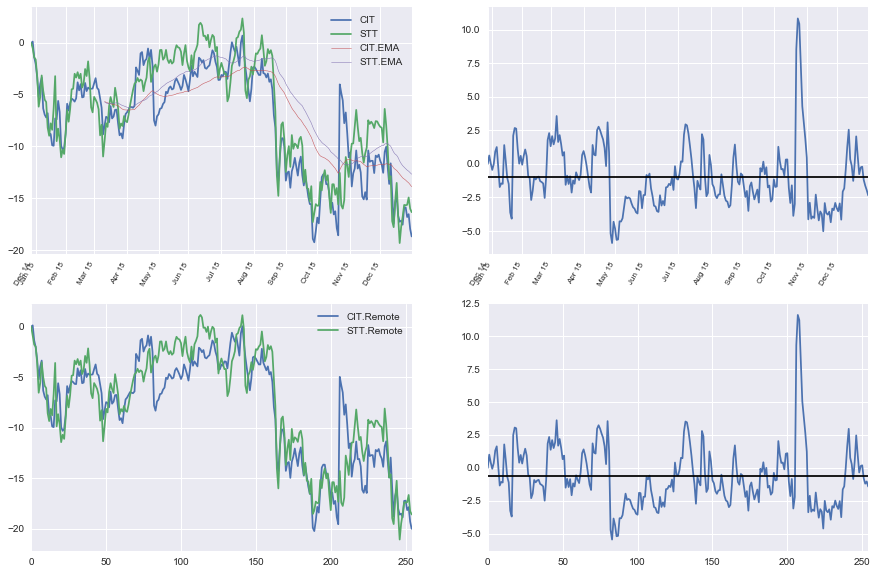

In [36]:
S1 = symbol_test_prices[pair[0]]
S2 = symbol_test_prices[pair[1]]

yprices = get_prices_remote([pair[0], pair[1]], dt_end=analyze_date, source='google')  # yahoo | google
Y1 = yprices[pair[0]].as_matrix()[-length_limit:]
Y2 = yprices[pair[1]].as_matrix()[-length_limit:]

# подготавливаем ряды
X, Y = prepare_pair(S1, S2, to_performance=True, is_log=True)
YX, YY = prepare_pair(Y1, Y2, to_performance=True, is_log=True)

period = 50
ema1 = talib.EMA(X, timeperiod=period)
ema2 = talib.EMA(Y, timeperiod=period)

# расчеты
diff = (ema1[period-1:] - ema2[period-1:])
diff_mean = abs(diff).mean()
diff_median = np.median(abs(diff))
diff_percentile = np.percentile(abs(diff), 80)

# prepare charts
X = pd.Series(X, name=pair[0])
Y = pd.Series(Y, name=pair[1])
YX = pd.Series(YX, name=pair[0] + '.Remote')
YY = pd.Series(YY, name=pair[1] + '.Remote')
X_ema = pd.Series(ema1, name=pair[0] + '.EMA')
Y_ema = pd.Series(ema2, name=pair[1] + '.EMA')

# xticks
dates = symbol_dates[pair[0]][-len(X):].astype(date)
months = list(months_generator(dates))
xticks = [i for i in range(0, len(X)) if dates[i] in months]
xticklabels = [dt.strftime('%b %y') for dt in months]

# draw performance and MAs
fig, axs = plt.subplots(2,2, figsize=(15, 10))
pd.concat([X, Y], axis=1).plot(xticks=xticks, ax=axs[0][0]) # Performance
pd.concat([X_ema, Y_ema], axis=1).plot(ax=axs[0][0], linewidth=0.5) # SMA50
# xtick labels
axs[0][0].set_xticklabels(xticklabels, size=8, rotation=60, ha='right')

# draw spread
diff_series = pd.Series(X - Y, name='-'.join(pair))
diff_series.plot(xticks=xticks, ax=axs[0][1])
axs[0][1].axhline(diff_series.mean(), color='black')
# xtick labels
axs[0][1].set_xticklabels(xticklabels, size=8, rotation=60, ha='right')

# Yahoo.Finance for comparison
pd.concat([YX, YY], axis=1).plot(ax=axs[1][0]) # Performance
Ydiff_series = pd.Series(YX - YY, name='-'.join(pair))
Ydiff_series.plot(ax=axs[1][1])
axs[1][1].axhline(Ydiff_series.mean(), color='black')

result = adfuller(X-Y)
score, pvalue, crit = result[0], result[1], result[4]
print(
    'Score={0:.4f}; P-value={1:.4f}; Cointegrated={2}; Crit[5%]={3:.4f}'.format(score, pvalue, score < crit['5%'], crit['5%']),
    '\nSpread mean={0:.5f}; Spread median={1:.5f}; Percentile 80%={2:.5f};'.format(diff_mean, diff_median, diff_percentile)
)

(255,)

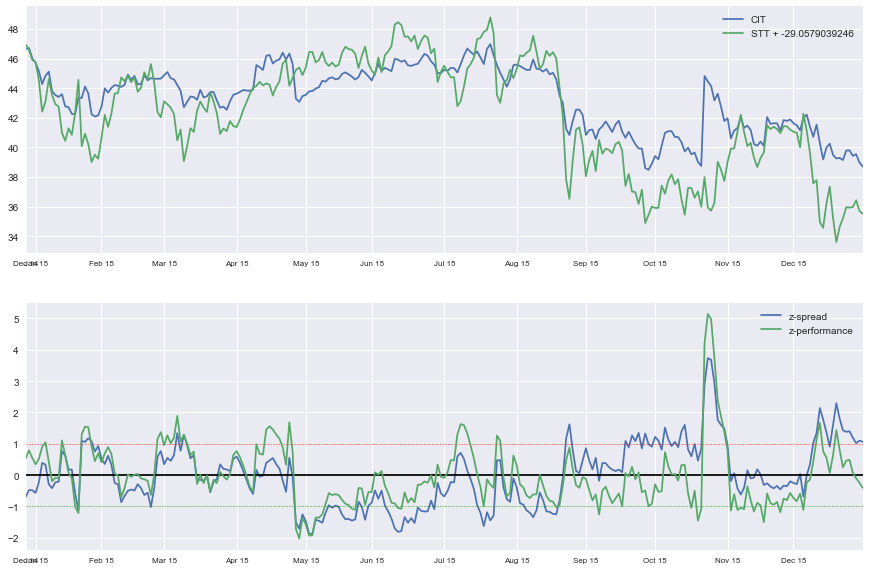

In [37]:
# Draw prices with z-score 
P1, P2 = prepare_pair(S1, S2, to_performance=False)

assets_diff = get_diff(P1 - P2)

coef_idx = -1 # 0/-1
ratio = S1[coef_idx]/S2[coef_idx]
P1 = pd.Series(P1, name=pair[0]) # приводим к одной цене по первому отношению
#P2 = pd.Series(P2, name=pair[1] + ' x ' + str(ratio))
P2 = pd.Series(P2, name=pair[1] + ' + ' + str(assets_diff))

# convert to same price
P2 = P2 + assets_diff

fig, axs = plt.subplots(2, 1, figsize=(15, 10))
pd.concat([P1, P2], axis=1).plot(xticks=xticks, ax=axs[0]) # рисуем оба ряда

# xtick labels
axs[0].set_xticklabels(xticklabels, size=8, rotation=0, ha='center')

diff_series = P1 - P2
zscore_std(diff_series, name="z-spread").plot(xticks=xticks, ax=axs[1], legend=True)
axs[1].axhline(zscore_std(diff_series).mean(), color='black')
axs[1].axhline(1.0, color='red', linestyle='--', linewidth=0.5)
axs[1].axhline(-1.0, color='green', linestyle='--', linewidth=0.5)
# xtick labels
axs[1].set_xticklabels(xticklabels, size=8, rotation=0, ha='center')

Perf1, Perf2 = prepare_pair(S1, S2, to_performance=True)
Perf1 = pd.Series(Perf1, name=pair[0])
Perf2 = pd.Series(Perf2, name=pair[1])
zscore_std(Perf1 - Perf2, name="z-performance").plot(xticks=xticks, ax=axs[1], legend=True)

# spread
#(P1 - P2).plot(xticks=xticks, ax=axs[2])
#(Perf1 - Perf2).plot(xticks=xticks, ax=axs[2])

# change background
fig.set_facecolor('white')

P1.shape

# OLS

Строим регрессию и анализируем связь двух активов.

('CIT', 'STT') Correlation: 0.8667109201275116 r^2: 0.7511878190682778


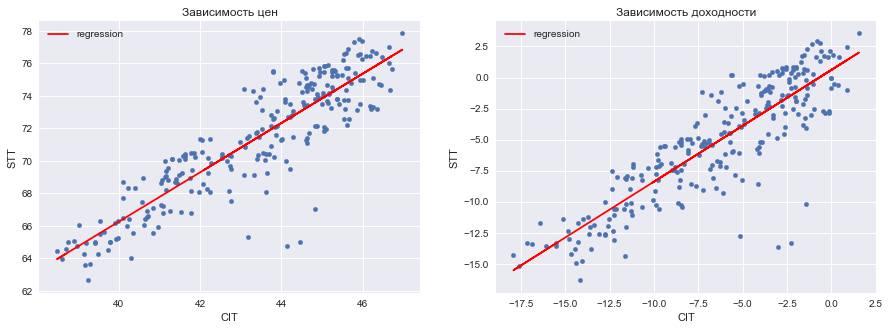

In [38]:
# one - data, second - index
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

price_xy = pd.DataFrame(S2, columns=[pair[1]], index=S1)
price_xy[pair[0]] = price_xy.index
price_xy.plot.scatter(x=pair[0], y=pair[1], ax=axs[0])
axs[0].set_title('Зависимость цен')

# draw regression
fit = np.polyfit(S1, S2, deg=1)
axs[0].plot(S1, fit[0] * S1 + fit[1], color='red', label="regression")
axs[0].legend()  # add legend

Perf1, Perf2 = prepare_pair(S1, S2, to_performance=True)  # , is_log=True
performance_xy = pd.DataFrame(Perf2, columns=[pair[1]], index=Perf1)
performance_xy[pair[0]] = performance_xy.index
performance_xy.plot.scatter(x=pair[0], y=pair[1], ax=axs[1])
axs[1].set_title('Зависимость доходности')
#performance_xy

# draw regression
fit = np.polyfit(Perf1, Perf2, deg=1)
axs[1].plot(Perf1, fit[0] * Perf1 + fit[1], color='red', label="regression")
axs[1].legend()  # add legend

# correlation
corr = talib.CORREL(Perf1, Perf2, timeperiod=len(Perf1))[-1]
r2 = corr**2
print(pair, 'Correlation: {0} r^2: {1}'.format(corr, r2))
#X, a + b*X[:, 1], fit[0] * X + fit[1]

# Коэф. смешанной корреляции

Хорошая пара после построения регрессии обладает значением **0.60 < R-squared < 0.95**. **R-squared** - коэффициент смешанной корреляции.

Когда **R-squared > 0.95**, активы сильно скоррелированы. Мало возможностей для хорошего движения.

Точки на графике Цены1(X) от Цены2(Y) имеют выраженный тренд и расположены скученно.

Но на доходности яркой зависимости нет. Хоть доходность есть на каждой такой паре. 
Иногда доходность подскакивала на **R-squared ~ 0.6**, при минимальном количестве сделок.

[ 0.86564576  0.99740395] 0.769666248991


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     845.4
Date:                Wed, 24 May 2017   Prob (F-statistic):           1.24e-82
Time:                        19:01:20   Log-Likelihood:                -593.39
No. Observations:                 255   AIC:                             1191.
Df Residuals:                     253   BIC:                             1198.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8656      0.234      3.697      0.000       0.404       1.327
x1             0.9974      0.034     29.076      0.000       0.930       1.065
==============================================================================
Omnibus:                        5.891   Durbin-Watson:                   0.385
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.985
Skew:                           0.272   Prob(JB):                       0.0502
Kurtosis:                       3.518   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

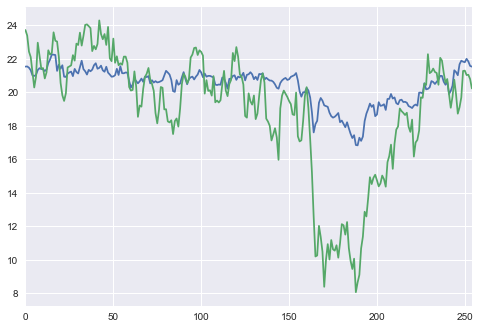

In [13]:
P1, P2 # цены
Perf1, Perf2 # доходность

def get_OLS(Perf1, Perf2):
    Y = Perf1.copy()[:]
    X = Perf2.copy()[:]

    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    return model

model = get_OLS(Perf1, Perf2)
print(model.params, model.rsquared)

P1.plot()
((P2 + model.params[0]) * model.params[1]).plot()
#pd.Series(model.fittedvalues, name='Prediction').plot()

model.summary()

## Сравнение разных значений $r^2$

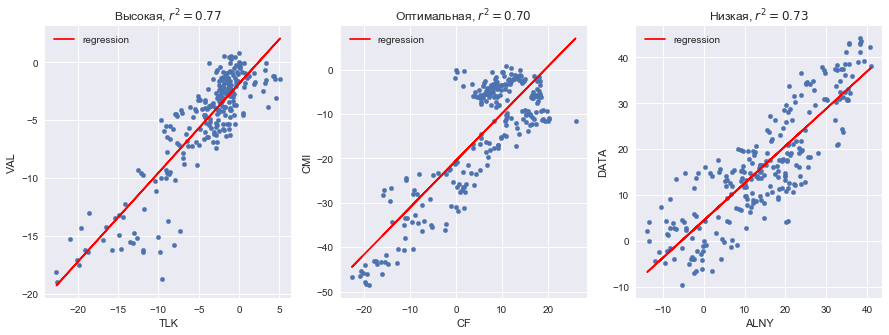

In [14]:
# one, two, three
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# change background
fig.set_facecolor('white')

def draw_chart_regres(pair, prices, axs, title="empty title"):
    S1 = prices[pair[0]]
    S2 = prices[pair[1]]
    
    Perf1, Perf2 = prepare_pair(S1, S2, to_performance=True)
    performance_xy = pd.DataFrame(Perf2, columns=[pair[1]], index=Perf1)
    performance_xy[pair[0]] = performance_xy.index
    performance_xy.plot.scatter(x=pair[0], y=pair[1], ax=axs)
    #performance_xy

    # draw regression
    fit = np.polyfit(Perf1, Perf2, deg=1)
    axs.plot(Perf1, fit[0] * Perf1 + fit[1], color='red', label="regression")
    axs.legend()  # add legend
    
    # correlation
    corr = talib.CORREL(Perf1, Perf2, timeperiod=len(Perf1))[-1]
    r2 = corr**2

    axs.set_title(title.format(r2))

draw_chart_regres(pair, symbol_test_prices, axs[0], title="Высокая, $r^2 = {0:.2f}$")
draw_chart_regres(pair_mid, symbol_test_prices, axs[1], title="Оптимальная, $r^2 = {0:.2f}$")
draw_chart_regres(pair_low, symbol_test_prices, axs[2], title="Низкая, $r^2 = {0:.2f}$")
    

## Цена, спред, $r^2$

Построение графиков для визуального анализа пары.

(255,)

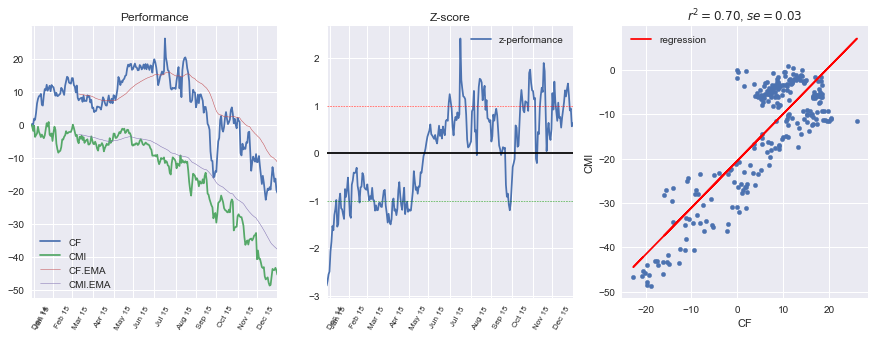

In [33]:
try:
  pair = pair_old
except NameError:
  pair_old = pair

pair = pair_mid
# one, two, three
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# change background
fig.set_facecolor('white')

# Draw performance
S1, S2 = symbol_test_prices[pair[0]], symbol_test_prices[pair[1]]

# подготавливаем ряды
X, Y = prepare_pair(S1, S2, to_performance=True)

period = 50
ema1 = talib.EMA(X, timeperiod=period)
ema2 = talib.EMA(Y, timeperiod=period)

# prepare charts
X = pd.Series(X, name=pair[0])
Y = pd.Series(Y, name=pair[1])
X_ema = pd.Series(ema1, name=pair[0] + '.EMA')
Y_ema = pd.Series(ema2, name=pair[1] + '.EMA')

# xticks
dates = symbol_dates[pair[0]][-len(X):].astype(date)
months = list(months_generator(dates))
xticks = [i for i in range(0, len(X)) if dates[i] in months]
xticklabels = [dt.strftime('%b %y') for dt in months]

# draw performance and MAs
pd.concat([X, Y], axis=1).plot(xticks=xticks, ax=axs[0]) # Performance
pd.concat([X_ema, Y_ema], axis=1).plot(ax=axs[0], linewidth=0.5) # SMA50
# xtick labels
axs[0].set_xticklabels(xticklabels, size=8, rotation=60, ha='left')
axs[0].set_title('Performance')

Perf1, Perf2 = prepare_pair(S1, S2, to_performance=True)
Perf1 = pd.Series(Perf1, name=pair[0])
Perf2 = pd.Series(Perf2, name=pair[1])
zscore_std(Perf1 - Perf2, name="z-performance").plot(xticks=xticks, ax=axs[1], legend=True)
axs[1].axhline(zscore_std(diff_series).mean(), color='black')
axs[1].axhline(1.0, color='red', linestyle='--', linewidth=0.5)
axs[1].axhline(-1.0, color='green', linestyle='--', linewidth=0.5)
# xtick labels
axs[1].set_xticklabels(xticklabels, size=8, rotation=60, ha='left')
axs[1].set_title('Z-score')

# OLS
model = get_OLS(Perf1, Perf2)
se = model.bse[1]

draw_chart_regres(pair, symbol_test_prices, axs[2], title="$r^2 = {0:.2f}$" + ", $se = {0:.2f}$".format(se))

P1.shape